# Packages

**Objectifs**
- Prouver en quoi LightGBM fait mieux en termes d'explicabilité que le modèle régression linéaire et RIDGE pour l'évolution du chômage
- Prouver que LightGBM fait mieux pour tous les modèles en prévision 

**Démarche**
- Etablir le dataframe des résultats
- Analyser la performance prédictive des modèles : 
** Comparaison graphique des données de test et de prévision ; 
** Analyse des erreurs ; 
- Mesurer l'importance des prédicateurs
** Calcul de Mean permutation values (absolute error)
** Calcul de Mean permutation values (Deviance)
** Calcul de Shapley share
- Présentation graphique des métriques d'importances de covariables
- Test de validation des variables importantes
- Expliquer comment les covariables déterminent le taux de chômage
- Expliquer si LightGBM tient compte automatiquement de l'effet cyclique de l'économie

**Résultats**
Les premiers résultats confirment que le cycle économique reste le déterminant central du chômage :

une hausse de la production, de la consommation (RPI) ou du crédit bancaire réduit le chômage futur,

tandis qu’une récession (USREC) ou une chute du S&P 500 l’augmente.

Cependant, la forte corrélation entre ces variables entraîne une multicolinéarité, ce qui limite la fiabilité de la régression linéaire.

L’estimation Ridge corrige partiellement ce problème en stabilisant les coefficients, tout en conservant une structure linéaire. Les résultats montrent que l’effet du cycle économique demeure majeur, mais que l’impact de certaines variables (INDPRO, prix du pétrole, masse monétaire) avait été surestimé.

Le modèle LightGBM dépasse ces limites en captant :
- des relations non linéaires,
- des effets de seuil,
- et des changements de régime économique.

Sur l’ensemble de la période, LightGBM prédit mieux que les modèles linéaires, surtout après la crise de 2008 et durant les périodes d’instabilité (ex. COVID). Il révèle que le chômage possède une forte inertie, avec UNRATE_lag_12 devenant l’un des déterminants principaux, et que les variables financières (S&P 500, taux courts TB3MS) influencent davantage le chômage lors des phases de crise.

**Rapprochement des résultats en théorie économique**
Les résultats empiriques confirment que le chômage est principalement déterminé par le cycle économique, conformément à l’approche keynésienne : une hausse de la demande, de la production ou du crédit soutient l’emploi, tandis qu’une récession accroît le chômage. Le modèle Ridge consolide cette lecture en corrigeant la multicolinéarité entre les variables cycliques, ce qui stabilise les estimations et confirme la prédominance du cycle.

Le modèle LightGBM enrichit cette analyse en mettant en évidence une forte inertie du chômage ainsi que des relations non linéaires entre facteurs réels, financiers et monétaires. Il montre notamment que l’impact de la politique monétaire dépend du régime économique : une expansion modérée favorise l’activité, tandis qu’un excès de liquidité peut générer des déséquilibres.

Ainsi, les résultats s’inscrivent dans une perspective néo-keynésienne, où le chômage découle d’interactions entre cycle économique, rigidités du marché du travail et conditions financières, plutôt que d’un mécanisme unique et linéaire.

**Limites et Perspectives**
Sur l’ensemble de la période, LightGBM est le modèle le plus précis (MAE = 0.78), et sa version avec retards (LGBM_LAGS, MAE = 0.76) obtient les meilleurs résultats. L’avantage de LightGBM est particulièrement net entre 2000 et 2008 et après 2008, où les relations deviennent plus complexes que dans les régimes économiques précédents.

En revanche, tous les modèles se dégradent fortement après 2019, et l’écart entre eux se resserre, ce qui montre que les périodes d’instabilité (COVID, retournements rapides) réduisent la capacité des modèles à exploiter les régularités historiques.
L’intérêt des versions avec retards (LAGS) ressort clairement. Elles améliorent systématiquement les performances de chaque famille de modèles (LINREG_LAGS < LINREG, RIDGE_LAGS < RIDGE, LGBM_LAGS < LGBM), ce qui confirme une forte inertie dans la dynamique du chômage.

Cependant, ces résultats présentent des limites. D’une part, LightGBM ne capture pas spontanément la dépendance temporelle : sans lags, il sous-estime l’inertie du chômage. D’autre part, ses performances demeurent sensibles aux changements de régime, ce qui se traduit par une perte de stabilité en période de crise. Enfin, la forte dégradation après 2019 indique que les relations structurelles apprises par les modèles ne sont pas robustes face aux chocs exogènes et aux ruptures de cycle.

La vraie problématique maintenant c'est d'avoir un modèle à la fois bon dans le moment de stabilité macroéconomique et qui anticipe mieux le chômage depuis la crise de Covid-19. Bien sûr, en ne perdant pas l'interprétabilité.

# Importation des données

In [26]:
# ==========================================
# Chargement
# ==========================================
import os
import pickle
import joblib
import numpy as np
import pandas as pd

from __future__ import annotations
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Union

from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Chargement des résultats

In [27]:
# ---------- Helpers ----------

def load_any(path):
    """Charge un objet avec joblib puis pickle si besoin."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable: {path}")
    try:
        return joblib.load(path)
    except Exception:
        with open(path, "rb") as f:
            return pickle.load(f)

def load_with_fallbacks(primary_path, *alt_paths, expect_type=None, label=None):
    """
    Charge primary_path puis essaie les alt_paths en fallback.
    - expect_type: type attendu (ex: dict), si fourni on vérifie isinstance.
    - label: nom lisible pour logs (ex: 'Ridge bundle OOS').
    """
    name = f" ({label})" if label else ""
    try:
        obj = load_any(primary_path)
        if expect_type and not isinstance(obj, expect_type):
            print(f"⚠️ Type inattendu{name} pour {primary_path}: {type(obj)} (attendu {expect_type}).")
        else:
            return obj
    except Exception as e:
        print(f"ℹ️ Impossible de charger {primary_path}{name} : {e}")

    for p in alt_paths:
        try:
            obj = load_any(p)
            print(f"ℹ️ Fallback utilisé{name} → {p}")
            if expect_type and not isinstance(obj, expect_type):
                print(f"⚠️ Type inattendu{name} pour {p}: {type(obj)} (attendu {expect_type}).")
            return obj
        except Exception as e:
            print(f"ℹ️ Fallback raté{name} → {p} : {e}")

    print(f"⚠️ Aucun fichier disponible{name} (essayé: {[primary_path, *alt_paths]})")
    return None

def try_read_meta(path):
    """Lit un CSV méta. Tente index_col=0 puis sans index si échec."""
    for use_index in (0, None):
        try:
            meta = pd.read_csv(path, index_col=use_index)
            # Si 1 colonne, exposer Series
            if isinstance(meta, pd.DataFrame) and meta.shape[1] == 1:
                meta = meta.iloc[:, 0]
            return meta
        except Exception as e:
            last_err = e
    print(f"⚠️ Impossible de lire {path} : {last_err}")
    return None

def safe_meta_print(meta, keys, title="Méta"):
    """Affiche les clés demandées sans lever d'erreur si elles manquent."""
    if meta is None:
        print("⚠️ Pas de méta disponible.")
        return
    if isinstance(meta, pd.Series):
        d = meta.to_dict()
    elif isinstance(meta, pd.DataFrame):
        d = meta.iloc[0].to_dict() if len(meta) else {}
    elif isinstance(meta, dict):
        d = meta
    else:
        print(f"(info) Type de méta inattendu: {type(meta)}")
        d = {}

    print(f"\n--- {title} (clé: valeur) ---")
    for k in keys:
        print(f"{k}: {d.get(k, None)}")

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

def ensure_ms_index_df(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.index = pd.to_datetime(out.index).to_period("M").to_timestamp(how="start")
    return out.sort_index().asfreq("MS")

def ensure_features_present(df: pd.DataFrame, features: list[str], target_col: str | None = None):
    missing = [c for c in (features or []) if c not in df.columns]
    if target_col is not None and target_col not in df.columns:
        missing.append(target_col)
    if missing:
        raise ValueError(f"Colonnes manquantes dans le DataFrame: {missing}")

def make_exp_from_loaded(*, models, features, train_periods, preprocs=None, step_months: int = 12) -> dict:
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise ValueError("'models' doit être une liste non vue.")
    if not isinstance(features, (list, tuple)) or len(features) == 0:
        raise ValueError("'features' doit être une liste non vide.")
    if not isinstance(train_periods, (list, tuple)) or len(train_periods) != len(models):
        raise ValueError("'train_periods' doit avoir la même longueur que 'models'.")
    if preprocs is not None and len(preprocs) != len(models):
        raise ValueError("'preprocs' doit avoir la même longueur que 'models' si fourni.")
    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(train_periods))),
        "step_months":   int(step_months),
    }

def exp_from_linreg_bundle_no_refit(linreg_bundle: dict) -> dict:
    if not isinstance(linreg_bundle, dict):
        raise ValueError("linreg_bundle invalide (pas un dict).")
    params = linreg_bundle.get("params", {}) or {}
    features = params.get("features", linreg_bundle.get("features", None))
    if not features:
        raise ValueError("Features absentes dans le bundle (params.features).")
    models = linreg_bundle.get("models", None)
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise RuntimeError(
            "Ce bundle ne contient pas la liste des modèles par fenêtre ('models'). "
            "Sauvegarde les modèles lors de l'apprentissage, puis recharge."
        )
    preprocs = linreg_bundle.get("preprocs", None)
    if preprocs is not None and len(preprocs) != len(models):
        raise RuntimeError("'preprocs' n'a pas la même longueur que 'models'.")
    train_periods = linreg_bundle.get("train_fit_dates", None)
    if train_periods is None or len(train_periods) != len(models):
        raise RuntimeError("'train_fit_dates' manquant ou de longueur différente de 'models'.")
    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(train_periods))),
        "step_months":   12,
    }

def extract_last_model_from_bundle(bundle: dict, model_key="models"):
    """Récupère le dernier modèle depuis un bundle, sinon None."""
    try:
        if isinstance(bundle, dict) and model_key in bundle and bundle[model_key]:
            return bundle[model_key][-1]
    except Exception as e:
        print(f"⚠️ Impossible d'extraire le dernier modèle: {e}")
    return None

In [28]:
# -------- Linear Regression
LINREG_PKL          = "linear_regression.pkl"
LINREG_META         = "linear_regression_meta.csv"
LINREG_LAGS_PKL     = "linear_regression__with_UNRATE_lags_h12.pkl"
LINREG_LAGS_META    = "linear_regression_meta__with_UNRATE_lags_h12.csv"

# -------- Ridge
RIDGE_PKL           = "ridge_regression.pkl"
RIDGE_META          = "ridge_regression_meta.csv"
RIDGE_LAGS_PKL      = "ridge_regression__with_UNRATE_lags_h12.pkl"
RIDGE_LAGS_META     = "ridge_regression_meta__with_UNRATE_lags_h12.csv"

# (optionnels si utilisés)
RIDGE_LAST_PKL      = "RIDGE_last_trained_model.pkl"
RIDGE_LAST_META     = "RIDGE_last_trained_model_meta.csv"
RIDGE_BUNDLE        = "RIDGE_h12_oos_bundle.pkl"
RIDGE_LAGS_LAST_PKL = "RIDGE_last_trained_model__with_UNRATE_lags_h12.pkl"
RIDGE_LAGS_LAST_META= "RIDGE_last_trained_model_meta__with_UNRATE_lags_h12.csv"
RIDGE_LAGS_BUNDLE   = "RIDGE_h12_oos_bundle__with_UNRATE_lags_h12.pkl"

# -------- LightGBM (AVEC USREC)
LGBM_PKL            = "lightgbm_regression.pkl"
LGBM_META           = "lightgbm_regression_meta.csv"
LGBM_LAST_PKL       = "LGBM_last_trained_model.pkl"
LGBM_LAST_META      = "LGBM_last_trained_model_meta.csv"

LGBM_LAGS_PKL       = "lightgbm_regression__with_UNRATE_lags_h12.pkl"
LGBM_LAGS_META      = "lightgbm_regression_meta__with_UNRATE_lags_h12.csv"
LGBM_LAGS_LAST_PKL  = "LGBM_last_trained_model__with_UNRATE_lags_h12.pkl"
LGBM_LAGS_LAST_META = "LGBM_last_trained_model_meta__with_UNRATE_lags_h12.csv"
LGBM_BUNDLE         = "LGBM_h12_oos_bundle.pkl"
LGBM_LAGS_BUNDLE    = "LGBM_h12_oos_bundle__with_UNRATE_lags_h12.pkl"

# -------- LightGBM (SANS USREC) — NOUVEAU
#   => correspond exactement aux fichiers que tu viens de générer
LGBM_NOUSREC_LAGS_PKL       = "lightgbm_regression__with_UNRATE_lags_h12__noUSREC.pkl"
LGBM_NOUSREC_LAGS_META      = "lightgbm_regression_meta__with_UNRATE_lags_h12__noUSREC.csv"
LGBM_NOUSREC_LAGS_LAST_PKL  = "LGBM_last_trained_model__with_UNRATE_lags_h12__noUSREC.pkl"
LGBM_NOUSREC_LAGS_LAST_META = "LGBM_last_trained_model_meta__with_UNRATE_lags_h12__noUSREC.csv"
# (alias “bundle” pour homogénéité avec tes autres modèles)
LGBM_NOUSREC_LAGS_BUNDLE    = LGBM_NOUSREC_LAGS_PKL

In [32]:
# -*- coding: utf-8 -*-
# Ce bloc n’écrase AUCUNE de tes fonctions existantes.
# Il ajoute :
#   - try_read_meta_with_fallbacks (nouvelle)
#   - detect_lags + helpers (nouveaux) avec regex corrigée
#   - is_bundle (nouvelle)
#   - assign_loaded_object (nouvelle)
#   - blocs de chargement AR1/ARP/Ridge/LGBM/LGBM_LAGS
# Puis il réalise les sanity-checks et le récap.

import re

# ==============================================================
# ✅ Constantes des chemins (adapter si sous-dossier)
# ==============================================================

# -------- Linear Regression
LINREG_PKL          = "linear_regression.pkl"
LINREG_META         = "linear_regression_meta.csv"
LINREG_LAGS_PKL     = "linear_regression__with_UNRATE_lags_h12.pkl"
LINREG_LAGS_META    = "linear_regression_meta__with_UNRATE_lags_h12.csv"

# -------- Ridge
RIDGE_PKL           = "ridge_regression.pkl"
RIDGE_META          = "ridge_regression_meta.csv"
RIDGE_LAGS_PKL      = "ridge_regression__with_UNRATE_lags_h12.pkl"
RIDGE_LAGS_META     = "ridge_regression_meta__with_UNRATE_lags_h12.csv"
RIDGE_LAST_PKL      = "RIDGE_last_trained_model.pkl"
RIDGE_LAST_META     = "RIDGE_last_trained_model_meta.csv"
RIDGE_LAGS_LAST_PKL = "RIDGE_last_trained_model__with_UNRATE_lags_h12.pkl"
RIDGE_LAGS_LAST_META= "RIDGE_last_trained_model_meta__with_UNRATE_lags_h12.csv"

# -------- LightGBM (AVEC USREC)
LGBM_PKL            = "lightgbm_regression.pkl"
LGBM_META           = "lightgbm_regression_meta.csv"
LGBM_LAST_PKL       = "LGBM_last_trained_model.pkl"
LGBM_LAST_META      = "LGBM_last_trained_model_meta.csv"
LGBM_LAGS_PKL       = "lightgbm_regression__with_UNRATE_lags_h12.pkl"
LGBM_LAGS_META      = "lightgbm_regression_meta__with_UNRATE_lags_h12.csv"
LGBM_LAGS_LAST_PKL  = "LGBM_last_trained_model__with_UNRATE_lags_h12.pkl"
LGBM_LAGS_LAST_META = "LGBM_last_trained_model_meta__with_UNRATE_lags_h12.csv"

# -------- LightGBM (SANS USREC)
LGBM_NOUSREC_LAGS_PKL       = "lightgbm_regression__with_UNRATE_lags_h12__noUSREC.pkl"
LGBM_NOUSREC_LAGS_META      = "lightgbm_regression_meta__with_UNRATE_lags_h12__noUSREC.csv"
LGBM_NOUSREC_LAGS_LAST_PKL  = "LGBM_last_trained_model__with_UNRATE_lags_h12__noUSREC.pkl"
LGBM_NOUSREC_LAGS_LAST_META = "LGBM_last_trained_model_meta__with_UNRATE_lags_h12__noUSREC.csv"

# -------- AR(1) / AR(p)  ✅ correspond exactement à ta capture
AR1_BUNDLE_PKL = "AR1_h12_oos_bundle.pkl"
AR1_PKL        = "AR1_last_trained_model.pkl"
AR1_META_CSV   = "AR1_last_trained_model_meta.csv"

ARP_BUNDLE_PKL = "ARp_h12_oos_bundle.pkl"
ARP_PKL        = "ARp_last_trained_model.pkl"
ARP_META_CSV   = "ARp_last_trained_model_meta.csv"


# ==============================================================
# ✅ Helper CSV fallback (nouveau, utilise ta try_read_meta)
# ==============================================================

def try_read_meta_with_fallbacks(primary_path, *alt_paths, label=None):
    """Lit un CSV méta avec fallback(s) — sans utiliser pickle/joblib.
    S'appuie sur ta fonction 'try_read_meta'.
    """
    name = f" ({label})" if label else ""
    meta = None
    try:
        meta = try_read_meta(primary_path)  # ← ta fonction existante
    except NameError:
        print("⚠️ try_read_meta non définie dans ce namespace.")
        return None

    if meta is not None:
        print(f"ℹ️ Meta CSV chargé{name} → {primary_path}")
        return meta

    print(f"ℹ️ Impossible de lire {primary_path}{name} (CSV).")
    for p in alt_paths:
        m = try_read_meta(p)  # ← ta fonction existante
        if m is not None:
            print(f"ℹ️ Fallback CSV utilisé{name} → {p}")
            return m
        else:
            print(f"ℹ️ Fallback CSV raté{name} → {p}")

    print(f"⚠️ Aucun CSV méta disponible{name} (essayé: {[primary_path, *alt_paths]})")
    return None


# ==============================================================
# ✅ Détection robuste des lags (structure d'abord, sinon regex)
# ==============================================================

_LAG_KEYS_PARAMS = ("lags_h", "with_lags", "use_lags")
_LAG_KEYS_FEATS  = ("lag_cols", "lags_h", "lags", "features_lags")

# regex tolérante: "with UNRATE_lags", "with_UNRATE_lags_h12", etc.
# (corrigé : pas de \b final, on autorise une suite comme "__noUSREC")
_LAG_LABEL_REGEX = re.compile(
    r"with[_\s]?UNRATE_lags(?:[_\s]*h?(\d+))?",
    flags=re.I
)
# Fallback encore plus permissif
_LAG_LABEL_REGEX_FALLBACK = re.compile(r"lags[_\s]*h?(\d+)", flags=re.I)

def _detect_lags_from_structure(bundle: dict):
    """Retourne (has_lags: bool, h: Optional[int]) via clés structurées."""
    if not isinstance(bundle, dict):
        return False, None

    params = bundle.get("params") or {}
    features_block = bundle.get("features")
    if features_block is None:
        features_block = params.get("features")
    features = features_block or {}

    # horizon explicite
    h = None
    for k in ("lags_h",):
        v = params.get(k, None)
        if isinstance(v, int):
            h = v
            break
        v = features.get(k, None) if isinstance(features, dict) else None
        if isinstance(v, int):
            h = v
            break

    # présence de lags (flags/cols)
    has_flag = any(bool(params.get(k)) for k in _LAG_KEYS_PARAMS)
    has_cols = False
    if isinstance(features, dict):
        has_cols = bool(features.get("lag_cols")) or bool(features.get("lags")) or bool(features.get("features_lags"))
    has_lags = has_flag or has_cols or (h is not None)
    return has_lags, h

def _detect_lags_from_label(bundle: dict):
    """Retourne (has_lags: bool, h: Optional[int]) via parsing du label texte."""
    if not isinstance(bundle, dict):
        return False, None
    params = bundle.get("params") or {}
    label  = (params.get("model") or "").strip()
    if not label:
        return False, None

    m = _LAG_LABEL_REGEX.search(label) or _LAG_LABEL_REGEX_FALLBACK.search(label)
    if not m:
        return False, None
    h = int(m.group(1)) if m.group(1) else None
    return True, h

def detect_lags(bundle: dict):
    """Retourne (has_lags: bool, h: Optional[int], source: {'struct','label','none'})"""
    has_lags, h = _detect_lags_from_structure(bundle)
    if has_lags:
        return True, h, "struct"
    has_lags, h = _detect_lags_from_label(bundle)
    if has_lags:
        return True, h, "label"
    return False, None, "none"


# ==============================================================
# ✅ Helpers bundle & features
# ==============================================================

def is_bundle(x):
    """Vérifie que x ressemble à un bundle (dict avec structure plausible)."""
    if not isinstance(x, dict):
        return False
    return any(k in x for k in ("params", "model", "features"))

def _bundle_features(bndl: dict):
    """Retourne la liste des features si accessible, [] sinon."""
    if not isinstance(bndl, dict):
        return []
    params = bndl.get("params") or {}
    feats = params.get("features")
    if isinstance(feats, (list, tuple)):
        return list(feats)
    if isinstance(bndl.get("features"), (list, tuple)):
        return list(bndl["features"])
    return []

def _bundle_has_usrec(bndl: dict) -> bool:
    feats = _bundle_features(bndl)
    return any("USREC" in str(c).upper() for c in feats)

def assign_loaded_object(obj, *, bundle_var: str, model_var: str):
    """
    Si obj est un dict "bundle-like", assigne globals()[bundle_var] = obj.
    Sinon, assigne globals()[model_var] = obj.
    """
    if isinstance(obj, dict) and is_bundle(obj):
        globals()[bundle_var] = obj
    else:
        globals()[model_var] = obj


# ==============================================================
# ✅ Intégration — chargements + sanity check des lags
#    ⚠️ N’écrase rien : si une variable existe déjà, on la garde.
# ==============================================================

# ---------- Linear (avec lags) ----------
print("\n=== Chargement Régression Linéaire (avec lags) ===")
if "linreg_lags_bundle" in globals() and linreg_lags_bundle is not None:
    pass
else:
    try:
        linreg_lags_bundle = load_with_fallbacks(
            LINREG_LAGS_PKL,
            LINREG_PKL,            # fallback si un ancien run a écrasé par erreur
            expect_type=dict,
            label="Linear (lags) bundle"
        )
    except NameError:
        linreg_lags_bundle = None

try:
    linreg_lags_meta = try_read_meta_with_fallbacks(
        LINREG_LAGS_META,
        LINREG_META,           # fallback CSV
        label="Linear (lags) meta"
    )
except NameError:
    linreg_lags_meta = None

if is_bundle(globals().get("linreg_lags_bundle")):
    _has_lags, _h, _src = detect_lags(linreg_lags_bundle)
    _label = ((linreg_lags_bundle.get("params") or {}).get("model") or "")
    print(f"ℹ️ Linear (lags) — label: {_label!r} | lags détectés: {_has_lags} | h={_h} | via={_src}")
else:
    print("⚠️ Linear (lags) — bundle invalide, manquant, ou chemins non fournis.")


# ---------- LGBM (lags, SANS USREC) ----------
print("\n=== Chargement LightGBM (lags, SANS USREC) ===")
if "lgbm_nousrec_lags_bundle" in globals() and lgbm_nousrec_lags_bundle is not None:
    pass
else:
    try:
        lgbm_nousrec_lags_bundle = load_with_fallbacks(
            LGBM_NOUSREC_LAGS_PKL,
            expect_type=dict,
            label="LGBM (lags, no USREC) bundle"
        )
    except NameError:
        lgbm_nousrec_lags_bundle = None

try:
    lgbm_nousrec_lags_meta = try_read_meta_with_fallbacks(
        LGBM_NOUSREC_LAGS_META,
        label="LGBM (lags, no USREC) meta"
    )
except NameError:
    lgbm_nousrec_lags_meta = None

if is_bundle(globals().get("lgbm_nousrec_lags_bundle")):
    _has_lags, _h, _src = detect_lags(lgbm_nousrec_lags_bundle)
    _label = ((lgbm_nousrec_lags_bundle.get("params") or {}).get("model") or "")
    has_usrec = _bundle_has_usrec(lgbm_nousrec_lags_bundle)
    print(f"ℹ️ LGBM (lags, no USREC) — label: {_label!r} | lags: {_has_lags} (h={_h}, via={_src}) | USREC present? {has_usrec}")
    if has_usrec:
        print("⚠️ Attention: ce bundle 'no USREC' contient des colonnes USREC dans ses features.")
else:
    print("⚠️ LGBM (lags, no USREC) — bundle invalide, manquant, ou chemins non fournis.")


# ---------- AR(1) ----------
print("\n=== Chargement AR(1) ===")
try:
    ar1_obj = load_with_fallbacks(
        AR1_BUNDLE_PKL,  # bundle (dict)
        AR1_PKL,         # estimator "nu"
        expect_type=None,
        label="AR1"
    )
    if ar1_obj is not None and ("ar1_bundle" not in globals() and "ar1_model" not in globals()):
        assign_loaded_object(ar1_obj, bundle_var="ar1_bundle", model_var="ar1_model")

    try:
        ar1_meta = try_read_meta_with_fallbacks(
            AR1_META_CSV,
            label="AR1 meta"
        )
    except NameError:
        ar1_meta = None

    if is_bundle(globals().get("ar1_bundle")):
        _has_lags, _h, _src = detect_lags(ar1_bundle)
        _label = ((ar1_bundle.get("params") or {}).get("model") or "")
        print(f"ℹ️ AR(1) — label: {_label!r} | lags détectés: {_has_lags} | h={_h} | via={_src}")
except NameError:
    pass


# ---------- AR(p) ----------
print("\n=== Chargement AR(p) ===")
try:
    arp_obj = load_with_fallbacks(
        ARP_BUNDLE_PKL,  # bundle (dict)
        ARP_PKL,         # estimator "nu"
        expect_type=None,
        label="ARP"
    )
    if arp_obj is not None and ("arp_bundle" not in globals() and "arp_model" not in globals()):
        assign_loaded_object(arp_obj, bundle_var="arp_bundle", model_var="arp_model")

    try:
        arp_meta = try_read_meta_with_fallbacks(
            ARP_META_CSV,
            label="ARP meta"
        )
    except NameError:
        arp_meta = None

    if is_bundle(globals().get("arp_bundle")):
        _has_lags, _h, _src = detect_lags(arp_bundle)
        _label = ((arp_bundle.get("params") or {}).get("model") or "")
        print(f"ℹ️ AR(p) — label: {_label!r} | lags détectés: {_has_lags} | h={_h} | via={_src}")
except NameError:
    pass


# ---------- Ridge (sans lags) ----------
print("\n=== Chargement Ridge (sans lags) ===")
try:
    ridge_obj = load_with_fallbacks(
        RIDGE_PKL,
        RIDGE_LAST_PKL,
        expect_type=None,
        label="Ridge"
    )
    if ridge_obj is not None and ("ridge_bundle" not in globals() and "ridge_model" not in globals()):
        assign_loaded_object(ridge_obj, bundle_var="ridge_bundle", model_var="ridge_model")
    try:
        ridge_meta = try_read_meta_with_fallbacks(
            RIDGE_META,
            RIDGE_LAST_META,
            label="Ridge meta"
        )
    except NameError:
        ridge_meta = None
except NameError:
    ridge_meta = None


# ---------- Ridge (avec lags) ----------
print("\n=== Chargement Ridge (avec lags) ===")
try:
    ridge_lags_obj = load_with_fallbacks(
        RIDGE_LAGS_PKL,
        RIDGE_LAGS_LAST_PKL,
        expect_type=None,
        label="Ridge (lags)"
    )
    if ridge_lags_obj is not None and ("ridge_lags_bundle" not in globals() and "ridge_lags_model" not in globals()):
        assign_loaded_object(ridge_lags_obj, bundle_var="ridge_lags_bundle", model_var="ridge_lags_model")

    try:
        ridge_lags_meta = try_read_meta_with_fallbacks(
            RIDGE_LAGS_META,
            RIDGE_LAGS_LAST_META,
            label="Ridge (lags) meta"
        )
    except NameError:
        ridge_lags_meta = None

    if is_bundle(globals().get("ridge_lags_bundle")):
        _has_lags, _h, _src = detect_lags(ridge_lags_bundle)
        _label = ((ridge_lags_bundle.get("params") or {}).get("model") or "")
        print(f"ℹ️ Ridge (lags) — label: {_label!r} | lags détectés: {_has_lags} | h={_h} | via={_src}")
except NameError:
    ridge_lags_meta = None


# ---------- LGBM (AVEC USREC, sans lags) ----------
print("\n=== Chargement LightGBM (AVEC USREC) ===")
try:
    lgbm_obj = load_with_fallbacks(
        LGBM_PKL,
        LGBM_LAST_PKL,
        expect_type=None,
        label="LGBM"
    )
    if lgbm_obj is not None and ("lgbm_bundle" not in globals() and "lgbm_model" not in globals()):
        assign_loaded_object(lgbm_obj, bundle_var="lgbm_bundle", model_var="lgbm_model")
    try:
        lgbm_meta = try_read_meta_with_fallbacks(
            LGBM_META,
            LGBM_LAST_META,
            label="LGBM meta"
        )
    except NameError:
        lgbm_meta = None
except NameError:
    lgbm_meta = None


# ---------- LGBM (AVEC lags & AVEC USREC) ----------
print("\n=== Chargement LightGBM (AVEC lags & AVEC USREC) ===")
try:
    lgbm_lags_obj = load_with_fallbacks(
        LGBM_LAGS_PKL,
        LGBM_LAGS_LAST_PKL,
        expect_type=None,
        label="LGBM (lags)"
    )
    if lgbm_lags_obj is not None and ("lgbm_lags_bundle" not in globals() and "lgbm_lags_model" not in globals()):
        assign_loaded_object(lgbm_lags_obj, bundle_var="lgbm_lags_bundle", model_var="lgbm_lags_model")

    try:
        lgbm_lags_meta = try_read_meta_with_fallbacks(
            LGBM_LAGS_META,
            LGBM_LAGS_LAST_META,
            label="LGBM (lags) meta"
        )
    except NameError:
        lgbm_lags_meta = None

    if is_bundle(globals().get("lgbm_lags_bundle")):
        _has_lags, _h, _src = detect_lags(lgbm_lags_bundle)
        _label = ((lgbm_lags_bundle.get("params") or {}).get("model") or "")
        has_usrec = _bundle_has_usrec(lgbm_lags_bundle)
        print(f"ℹ️ LGBM (lags) — label: {_label!r} | lags: {_has_lags} (h={_h}, via={_src}) | USREC present? {has_usrec}")
except NameError:
    lgbm_lags_meta = None


# ==============================================================
# ✅ Récapitulatif
# ==============================================================

loaded_summary = {
    "AR1":                  is_bundle(globals().get("ar1_bundle"))  or (globals().get("ar1_model")  is not None),
    "ARP":                  is_bundle(globals().get("arp_bundle"))  or (globals().get("arp_model")  is not None),
    "LINREG":               is_bundle(globals().get("linreg_bundle")),
    "LINREG_LAGS":          is_bundle(globals().get("linreg_lags_bundle")),
    "RIDGE":                is_bundle(globals().get("ridge_bundle")) or (globals().get("ridge_model") is not None),
    "RIDGE_LAGS":           is_bundle(globals().get("ridge_lags_bundle")) or (globals().get("ridge_lags_model") is not None),
    "LGBM":                 is_bundle(globals().get("lgbm_bundle")) or (globals().get("lgbm_model") is not None),
    "LGBM_LAGS":            is_bundle(globals().get("lgbm_lags_bundle")) or (globals().get("lgbm_lags_model") is not None),
    "LGBM_NOUSREC_LAGS":    is_bundle(globals().get("lgbm_nousrec_lags_bundle")),
}

print("\n=== Récap chargements ===")
for k, v in loaded_summary.items():
    print(f"{k:20s}: {'OK' if v else '—'}")


=== Chargement Régression Linéaire (avec lags) ===
ℹ️ Meta CSV chargé (Linear (lags) meta) → linear_regression_meta__with_UNRATE_lags_h12.csv
ℹ️ Linear (lags) — label: 'LinearRegression (with UNRATE_lags)' | lags détectés: True | h=None | via=label

=== Chargement LightGBM (lags, SANS USREC) ===
ℹ️ Meta CSV chargé (LGBM (lags, no USREC) meta) → lightgbm_regression_meta__with_UNRATE_lags_h12__noUSREC.csv
ℹ️ LGBM (lags, no USREC) — label: 'LightGBM + Bagging (with_UNRATE_lags_h12__noUSREC)' | lags: True (h=12, via=label) | USREC present? False

=== Chargement AR(1) ===
ℹ️ Meta CSV chargé (AR1 meta) → AR1_last_trained_model_meta.csv
ℹ️ AR(1) — label: 'AR(1)' | lags détectés: False | h=None | via=none

=== Chargement AR(p) ===
ℹ️ Meta CSV chargé (ARP meta) → ARp_last_trained_model_meta.csv
ℹ️ AR(p) — label: 'AR(p)' | lags détectés: False | h=None | via=none

=== Chargement Ridge (sans lags) ===
ℹ️ Meta CSV chargé (Ridge meta) → ridge_regression_meta.csv

=== Chargement Ridge (avec lags) =

In [33]:
import os, glob

print("Fichiers présents ?")
for p in [LINREG_PKL, LINREG_META, LINREG_LAGS_PKL, LINREG_LAGS_META]:
    print(f"{p} -> {'OK' if os.path.exists(p) else 'ABSENT'}")

# Si tu veux retrouver un nom approchant en cas d'erreur de frappe :
if not os.path.exists(LINREG_LAGS_PKL):
    print("\nSuggestions proches pour le bundle lags :")
    for g in glob.glob("linear_regression*lags*.pkl"):
        print(" -", g)

# Chargement rapide avec ton helper existant
linreg_bundle = load_any(LINREG_PKL)
linreg_lags_bundle = load_any(LINREG_LAGS_PKL)

print("\nLabels modèles :")
print("LINREG      :", (linreg_bundle.get('params') or {}).get('model'))
print("LINREG_LAGS :", (linreg_lags_bundle.get('params') or {}).get('model'))

Fichiers présents ?
linear_regression.pkl -> OK
linear_regression_meta.csv -> OK
linear_regression__with_UNRATE_lags_h12.pkl -> OK
linear_regression_meta__with_UNRATE_lags_h12.csv -> OK

Labels modèles :
LINREG      : LinearRegression
LINREG_LAGS : LinearRegression (with UNRATE_lags)


# Etablir de dataframe des résultats.

In [34]:
# ====== Imports requis (n'écrasent rien) ======
import numpy as np
import pandas as pd
import re
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =============== STANDARDISATION ===============
def standardize_oos_predictions(
    oos: pd.DataFrame,
    *,
    method_name: str | None = None,
    date_candidates=("date","dates"),
    true_candidates=("y_true","true","target","y"),
    pred_candidates=("y_pred","pred","prediction","forecast","yhat"),
) -> pd.DataFrame:
    """
    Convertit un DataFrame OOS quelconque en colonnes standardisées: (date, true, pred[, method]).
    - Ne dépend d'aucun modèle particulier.
    - Suppose que oos contient au moins une des colonnes candidates pour date/true/pred.
    """
    d = oos.copy()
    if d.index.name is not None:
        d = d.reset_index()

    cols = {c.lower(): c for c in d.columns}

    def _pick(cands):
        for k in cands:
            if k in cols:
                return cols[k]
        return None

    date_col = _pick(date_candidates)
    true_col = _pick(true_candidates)
    pred_col = _pick(pred_candidates)
    if not (date_col and true_col and pred_col):
        raise ValueError(f"Colonnes manquantes (date/true/pred) dans {d.columns.tolist()}")

    out = d[[date_col, true_col, pred_col]].rename(
        columns={date_col: "date", true_col: "true", pred_col: "pred"}
    )
    # utilise ta fonction existante _normalize_month_start
    out["date"] = _normalize_month_start(out["date"])
    if method_name:
        out["method"] = method_name
    return out.reset_index(drop=True)

def build_df_from_bundle(bundle: dict, default_method: str = "Model") -> pd.DataFrame:
    """
    Extrait/standardise 'oos_predictions' depuis un bundle générique.
    - Bundle attendu: {'oos_predictions': DataFrame, 'params': {'model': ...}, ...}
    - Aucune logique spécifique à un modèle.
    """
    if not isinstance(bundle, dict) or "oos_predictions" not in bundle:
        return pd.DataFrame(columns=["date", "true", "pred", "method"])
    params = bundle.get("params", {}) or {}
    method = params.get("model", default_method)
    return standardize_oos_predictions(bundle["oos_predictions"], method_name=method)


def assemble_long_from_bundles(*bundles: dict) -> pd.DataFrame:
    """
    Fusionne un nombre quelconque de bundles génériques en un long DataFrame homogène.
    Colonnes finales: (date, true, pred, method).
    """
    dfs = [build_df_from_bundle(b) for b in bundles if isinstance(b, dict)]
    dfs = [d for d in dfs if not d.empty]
    if not dfs:
        return pd.DataFrame(columns=["date", "true", "pred", "method"])
    out = pd.concat(dfs, ignore_index=True)
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.dropna(subset=["date", "true", "pred"]).sort_values(["date", "method"]).reset_index(drop=True)
    return out

In [35]:
# =================== SCORES ====================
def scores_basic(df: pd.DataFrame) -> dict[str, float]:
    """
    Calcule MAE, RMSE, R2 sur un DataFrame standardisé (date,true,pred[,method]).
    Totalement générique.
    """
    if df.empty:
        return {"MAE": np.nan, "RMSE": np.nan, "R2": np.nan}
    mae  = float(mean_absolute_error(df["true"], df["pred"]))
    rmse = float(np.sqrt(mean_squared_error(df["true"], df["pred"])))
    r2   = float(r2_score(df["true"], df["pred"])) if len(df) > 1 else np.nan
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def scores_by_method_and_window(
    df_long: pd.DataFrame,
    eval_window=("1983-01-01", "1989-12-31"),
    test_window=("1990-01-01", "2025-12-31"),
) -> dict[str, dict[str, dict[str, float]]]:
    """
    Scores par méthode pour deux fenêtres (Validation/Test).
    N’emploie aucun modèle spécifique.
    """
    if df_long.empty:
        return {"validation": {}, "test": {}}
    df = df_long.copy()
    df["date"] = pd.to_datetime(df["date"])
    e0, e1 = map(pd.Timestamp, eval_window)
    t0, t1 = map(pd.Timestamp, test_window)

    out = {"validation": {}, "test": {}}
    for m in sorted(df["method"].unique()):
        dval = df[(df["method"] == m) & (df["date"] >= e0) & (df["date"] <= e1)]
        dtes = df[(df["method"] == m) & (df["date"] >= t0) & (df["date"] <= t1)]
        out["validation"][m] = scores_basic(dval)
        out["test"][m]       = scores_basic(dtes)
    return out

In [36]:
# ============== OOS EXPANDING (générique) ==============
def oos_expanding_predict(
    *,
    y: pd.Series,
    X: pd.DataFrame | None = None,   # None = univarié ; sinon multivarié
    h: int = 12,
    min_train_n: int = 36,
    model_factory,                   # callable -> objet modèle avec fit(...) et predict(...)
    preproc_fit_fn=None,             # callable(X_train) -> (X_train_proc, prep)
    preproc_apply_fn=None,           # callable(X, prep) -> X_proc
    y_transform=None,                # callable(y) -> y_t
    y_inverse=None,                  # callable(y_t) -> y
    method_name: str = "Model",
) -> pd.DataFrame:
    """
    Moteur PSEUDO-OOS rolling-origin (expanding) **générique**.
    - Aucun modèle imposé : injecte ton modèle via `model_factory`.
    - `X` optionnel: univarié si None, multivarié sinon.
    - `preproc_fit_fn` et `preproc_apply_fn` optionnels (winsor/norm ou autre).
    - `y_transform`/`y_inverse` optionnels (différenciation, log, etc.).
    """
    # Alignement indices (MS)
    y = y.astype(float).copy()
    y.index = pd.to_datetime(y.index).to_period("M").to_timestamp(how="start")
    y = y.asfreq("MS")
    if X is not None:
        X = X.astype(float).copy()
        X.index = pd.to_datetime(X.index).to_period("M").to_timestamp(how="start")
        X = X.asfreq("MS")
        X, y = X.align(y, join="inner")

    rows = []
    last_t_end = y.index.max() - relativedelta(months=h)

    for t_end in y.index:
        if t_end > last_t_end:
            break
        y_tr = y.loc[:t_end]
        if len(y_tr) < min_train_n:
            continue

        X_tr = X.loc[:t_end] if X is not None else None
        y_tr_fit = y_transform(y_tr) if y_transform else y_tr

        if X_tr is not None and preproc_fit_fn:
            X_tr_p, prep = preproc_fit_fn(X_tr)
        else:
            X_tr_p, prep = (X_tr, None)

        model = model_factory()
        if X_tr_p is None:
            # univarié: le wrapper du modèle doit offrir .fit(y_series)
            model.fit(y_tr_fit)
        else:
            model.fit(X_tr_p, y_tr_fit.values)

        t_fore = t_end + relativedelta(months=h)
        if t_fore in y.index:
            if X is not None:
                x_fore_raw = X.loc[[t_fore]]
                x_fore_p = preproc_apply_fn(x_fore_raw, prep) if (preproc_apply_fn and prep is not None) else x_fore_raw
                yhat_h = float(model.predict(x_fore_p)[0])
            else:
                # univarié: le wrapper doit offrir predict(y_full, t_end, h)
                yhat_h = float(model.predict(y, t_end=t_end, h=h))

            if y_inverse:
                yhat_h = float(y_inverse(pd.Series([yhat_h], index=[t_fore]))[0])

            rows.append((t_fore, float(y.loc[t_fore]), yhat_h))

    out = pd.DataFrame(rows, columns=["date", "true", "pred"]).sort_values("date")
    out["date"] = _normalize_month_start(out["date"])  # ta fonction existante
    out["method"] = method_name
    return out.reset_index(drop=True)

In [37]:
# ========= Standardisation & fusion (patch LINREG vs LINREG_LAGS) =========
# 1) Récupérer les bundles AVEC leurs noms (indispensable pour trancher LINREG)
_bundle_items = [
    ("ar1_bundle",          globals().get("ar1_bundle")),
    ("arp_bundle",          globals().get("arp_bundle")),
    ("linreg_bundle",       globals().get("linreg_bundle")),
    ("linreg_lags_bundle",  globals().get("linreg_lags_bundle")),
    ("ridge_bundle",        globals().get("ridge_bundle")),
    ("ridge_lags_bundle",   globals().get("ridge_lags_bundle")),
    ("lgbm_bundle",         globals().get("lgbm_bundle")),
    ("lgbm_lags_bundle",    globals().get("lgbm_lags_bundle")),
]
available_bundles = [(name, b) for (name, b) in _bundle_items if isinstance(b, dict)]

if not available_bundles:
    raise RuntimeError("Aucun bundle dispo.")

import re
import pandas as pd

def _infer_ar_order_from_params(params: dict):
    if not isinstance(params, dict): return None
    if isinstance(params.get("lag"), int): return params["lag"]
    if isinstance(params.get("p"), int):   return params["p"]
    ordv = params.get("order")
    if isinstance(ordv, (list, tuple)) and ordv and isinstance(ordv[0], int):
        return ordv[0]
    p_grid = params.get("p_grid")
    if isinstance(p_grid, (list, tuple)) and p_grid:
        try:
            uniq = sorted({int(x) for x in p_grid if x is not None})
        except Exception:
            return None
        return 1 if uniq == [1] else (max(uniq) if uniq else None)
    return None

def _canon_base_from_label_and_params(label: str, params: dict) -> str:
    s = str(label or "").strip()
    base = s.split("(")[0].strip()
    base = re.sub(r"(?i)\blightgbm\s*\+\s*bagging\b", "LightGBM", base)
    low = base.lower()
    if low == "ar(1)": return "AR1"
    if low == "ar(p)": return "ARP"
    if low == "ar":
        p = _infer_ar_order_from_params(params or {})
        if p == 1: return "AR1"
        if isinstance(p, int) and p >= 2: return "ARP"
        return "AR"
    if low == "linearregression": return "LINREG"
    if low == "ridge":            return "RIDGE"
    if low == "lightgbm":         return "LGBM"
    return base.upper().replace(" ", "_").replace("-", "_")

def _label_has_lags(label: str) -> bool:
    return bool(re.search(r"(?i)\bwith[_\s]*unrate_lags\b", str(label or "")))

def _has_lag_columns(features) -> bool:
    if features is None: return False
    try: cols = list(features)
    except Exception: return False
    for c in cols:
        if re.search(r"(?i)\b(unrate[_\s]*lags?|lag(_?\d+)?|lags?(_?\d+)?)\b", str(c)):
            return True
    return False

def _struct_has_lags(b: dict) -> bool:
    if not isinstance(b, dict): return False
    params = b.get("params") or {}
    feats  = b.get("features", None) or params.get("features", None)
    if any(bool(params.get(k)) for k in ("lags_h","with_lags","use_lags")): return True
    if _has_lag_columns(feats): return True
    return False

def _bundle_has_lags_general(b: dict) -> bool:
    if _struct_has_lags(b): return True
    params = b.get("params") or {}
    if _label_has_lags(params.get("model")): return True
    try:
        ok, _, _ = detect_lags(b)  # si dispo dans ton script
        return bool(ok)
    except Exception:
        return False

def _canon_method_name_from_bundle(bundle_name: str, b: dict) -> str:
    """Force LINREG/LINREG_LAGS via le NOM du bundle ; autres via règle générale."""
    params = (b.get("params") or {})
    base   = _canon_base_from_label_and_params(params.get("model"), params)

    # 🔒 RÈGLE cible: régler uniquement LINREG
    if base == "LINREG":
        if bundle_name == "linreg_lags_bundle": return "LINREG_LAGS"
        if bundle_name == "linreg_bundle":      return "LINREG"
        # fallback si renommé : structure sinon LINREG
        return "LINREG_LAGS" if _struct_has_lags(b) else "LINREG"

    # Autres familles: lags via règle générale
    return f"{base}_LAGS" if _bundle_has_lags_general(b) else base

# 3) Assemblage canonisé par bundle AVANT concat
dfs = []
for bundle_name, b in available_bundles:
    if "oos_predictions" not in b: 
        continue
    df_b = build_df_from_bundle(b)
    if df_b.empty: 
        continue
    df_b["method"] = _canon_method_name_from_bundle(bundle_name, b)
    dfs.append(df_b)

df_pred_long = (
    pd.concat(dfs, ignore_index=True)
      .dropna(subset=["date","true","pred"])
      .assign(date=lambda d: pd.to_datetime(d["date"], errors="coerce"))
      .sort_values(["date","method"])
      .reset_index(drop=True)
)

# Optionnel: supprimer d'éventuels doublons stricts (utile si un OOS a été concaténé 2x à la source)
# df_pred_long = df_pred_long.drop_duplicates(subset=["date","method","true","pred"]).reset_index(drop=True)

print("Méthodes :", sorted(df_pred_long["method"].unique().tolist()))
print(df_pred_long["method"].value_counts())

Méthodes : ['AR1', 'ARP', 'LGBM', 'LGBM_LAGS', 'LINREG', 'LINREG_LAGS', 'RIDGE', 'RIDGE_LAGS']
method
AR1            741
ARP            741
LGBM           741
LGBM_LAGS      741
LINREG         741
LINREG_LAGS    741
RIDGE          741
RIDGE_LAGS     741
Name: count, dtype: int64


# Filtrer

In [38]:
def filter_df_by_start_date(df: pd.DataFrame, start_date: str = "1990-01-01") -> pd.DataFrame:
    """
    Filtre un DataFrame standardisé (date, true, pred, method)
    en ne gardant que les observations à partir de `start_date`.
    Retourne un DataFrame trié + index propre.
    """
    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce")

    out = (
        out[out["date"] >= pd.Timestamp(start_date)]
        .sort_values(["date", "method"])
        .reset_index(drop=True)
    )

    print(f"\n✅ Filtrage appliqué — période: {out['date'].min().date()} → {out['date'].max().date()} | n={len(out)}")
    print("Méthodes présentes :", sorted(out["method"].unique().tolist()))
    print("\nAperçu post-filtrage :")
    print(out.head(10))

    return out

In [39]:
df_pred_long = filter_df_by_start_date(df_pred_long, start_date="1990-01-01")


✅ Filtrage appliqué — période: 1990-01-01 → 2025-08-01 | n=3424
Méthodes présentes : ['AR1', 'ARP', 'LGBM', 'LGBM_LAGS', 'LINREG', 'LINREG_LAGS', 'RIDGE', 'RIDGE_LAGS']

Aperçu post-filtrage :
        date  true      pred       method
0 1990-01-01   0.0 -0.092641          AR1
1 1990-01-01   0.0 -0.105509          ARP
2 1990-01-01   0.0 -0.293035         LGBM
3 1990-01-01   0.0 -0.281137    LGBM_LAGS
4 1990-01-01   0.0 -0.198600       LINREG
5 1990-01-01   0.0 -0.145525  LINREG_LAGS
6 1990-01-01   0.0 -0.123126        RIDGE
7 1990-01-01   0.0 -0.123020   RIDGE_LAGS
8 1990-02-01   0.1 -0.050509          AR1
9 1990-02-01   0.1 -0.083438          ARP


In [40]:
df_pred_long.head()

,date,true,pred,method
0,1990-01-01,0.0,-0.092641,AR1
1,1990-01-01,0.0,-0.105509,ARP
2,1990-01-01,0.0,-0.293035,LGBM
3,1990-01-01,0.0,-0.281137,LGBM_LAGS
4,1990-01-01,0.0,-0.198600,LINREG


# Analyser la performance prédictive des modèles

## Comparaison des données de test et de prévision

✅ wide prêt : (428, 4) | Colonnes : ['AR1', 'RIDGE', 'LGBM_LAGS', 'true']


C:\Users\Mita\AppData\Local\Temp\ipykernel_15136\2998253903.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap("tab10", max(1, len(methods)))


💾 Figure enregistrée → global_forecasts.png


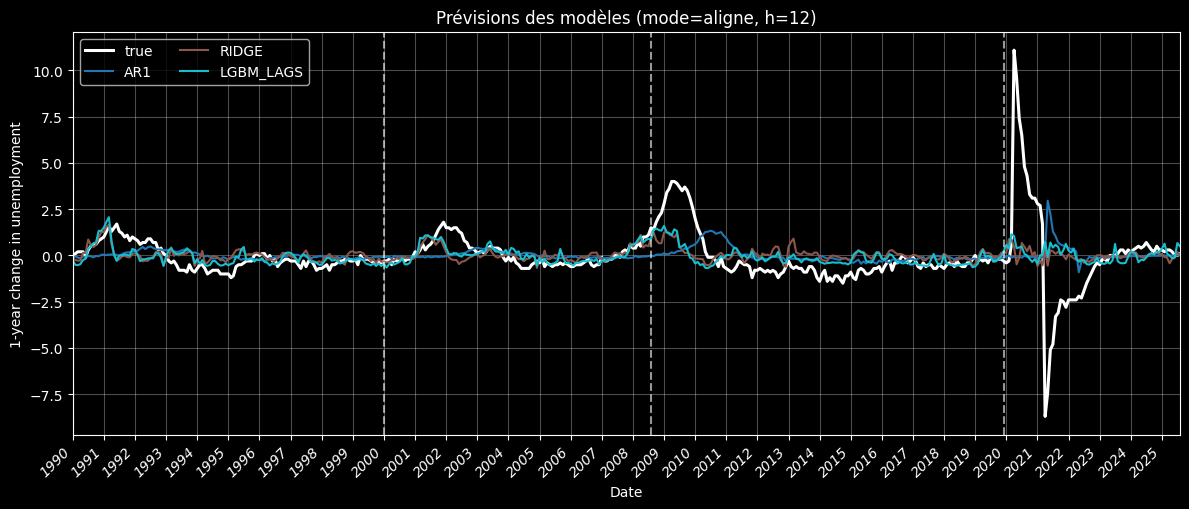

💾 Figure enregistrée → global_errors.png


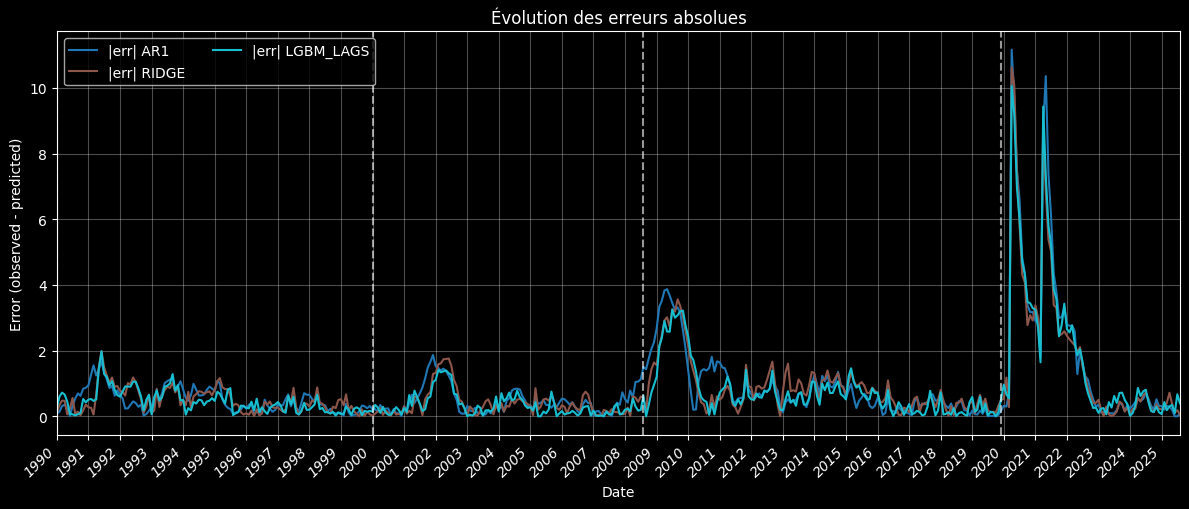

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- mapping d'alias / typos acceptés (clé = demandé, valeur = réel dans les données)
METHOD_ALIAS = {
    "LGMM_LAGS": "LGBM_LAGS",  # tolérance typo
}

def _normalize_methods_to_keep(methods_to_keep: list[str] | None) -> list[str] | None:
    if methods_to_keep is None:
        return None
    out = [METHOD_ALIAS.get(m, m) for m in methods_to_keep]
    # dédoublonnage en gardant l'ordre
    seen, dedup = set(), []
    for m in out:
        if m not in seen:
            dedup.append(m); seen.add(m)
    return dedup

def build_wide_from_long(df_long: pd.DataFrame, methods_to_keep: list[str] | None = None) -> pd.DataFrame:
    """
    Transforme un DataFrame long (date, method, pred, true)
    en un tableau large : une colonne par méthode + la vérité.
    Option: 'methods_to_keep' filtre les colonnes à la fin.
    """
    df = df_long.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Valeur "true" médiane par date
    true_by_date = df.groupby("date")["true"].median().rename("true")

    # Moyenne des prédictions par méthode
    wide = (
        df.pivot_table(index="date", columns="method", values="pred", aggfunc="mean")
          .sort_index()
    )
    wide = wide.join(true_by_date, how="left")

    # Filtrage éventuel des méthodes
    methods_to_keep = _normalize_methods_to_keep(methods_to_keep)
    if methods_to_keep is not None:
        present = [m for m in methods_to_keep if m in wide.columns]
        missing = [m for m in methods_to_keep if m not in wide.columns]
        if missing:
            print(f"ℹ️ Méthodes demandées absentes (ignorées) : {missing}")
        cols = [*present, *([ "true" ] if "true" in wide.columns else [])]
        wide = wide[[c for c in cols if c in wide.columns]]

    print("✅ wide prêt :", wide.shape, "| Colonnes :", wide.columns.tolist())
    return wide

def make_color_map(methods: list[str]) -> dict:
    """Crée une palette de couleurs cohérente pour chaque méthode."""
    cmap = {}
    base_colors = plt.cm.get_cmap("tab10", max(1, len(methods)))
    for i, m in enumerate(methods):
        cmap[m] = base_colors(i)
    cmap["true"] = "white"  # la vérité en blanc (fond noir)
    return cmap

def get_split_dates(segments):
    """Extrait les dates de séparation à partir d'une liste de segments."""
    return sorted({pd.to_datetime(start) for (start, _, _) in segments})

def _style_year_axis(ax, dates_index):
    """
    Force un tick par année, format YYYY, en italique + incliné,
    et couvre toute l'étendue des données.
    """
    ax.set_xlim(dates_index.min(), dates_index.max())
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))          # toutes les années
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))        # format 4 chiffres
    # italique + rotation
    for lbl in ax.get_xticklabels():
        lbl.set_fontstyle('italic')
        lbl.set_rotation(45)
        lbl.set_ha('right')

def plot_two_global_charts(
    df_long: pd.DataFrame,
    segments: list[tuple[str, str | None, str]],
    *,
    H: int = 12,
    mode: str = "aligne",   # "aligne" ou "decale"
    save: bool = True,
    title_prefix: str = "",
    methods_to_plot: list[str] | None = None,
):
    """
    Trace deux graphiques globaux :
    1) Prévisions des modèles
    2) Évolution des erreurs absolues
    avec les dates de séparation affichées sur les deux.

    'methods_to_plot' permet de sélectionner un sous-ensemble par nom.
    Tolère 'LGMM_LAGS' en l'interprétant comme 'LGBM_LAGS'.
    """
    plt.style.use("dark_background")

    # --- Construction du wide ---
    wide = build_wide_from_long(df_long, methods_to_keep=methods_to_plot)
    wide = wide.dropna(subset=["true"])  # sécurité

    methods = [c for c in wide.columns if c != "true"]
    if not methods:
        raise ValueError("Aucune méthode à tracer après filtrage. Vérifie les noms disponibles dans df_long['method'].")

    colors = make_color_map(methods)
    split_dates = get_split_dates(segments)

    # ============================================================
    # 1️⃣  Prévisions des modèles
    # ============================================================
    fig1, ax1 = plt.subplots(figsize=(12, 5.2))
    ax1.plot(wide.index, wide["true"], label="true", color=colors["true"], linewidth=2.2)

    for m in methods:
        if mode == "aligne":
            ax1.plot(wide.index, wide[m], label=m, color=colors[m], linewidth=1.5)
        elif mode == "decale":
            ax1.plot(wide.index - pd.DateOffset(months=H), wide[m], label=f"{m} (−{H}m)", color=colors[m], linewidth=1.5)
        else:
            raise ValueError("mode inconnu (utiliser 'aligne' ou 'decale')")

    for d in split_dates:
        ax1.axvline(d, linestyle="--", alpha=0.6)

    ax1.set_title(f"{title_prefix}Prévisions des modèles (mode={mode}, h={H})".strip())
    ax1.set_xlabel("Date")
    ax1.set_ylabel("1-year change in unemployment")  # ✅ demandé
    ax1.grid(alpha=0.3)
    ax1.legend(ncols=2)
    _style_year_axis(ax1, wide.index)                # ✅ années en italique & toutes présentes
    fig1.tight_layout()

    if save:
        fig1.savefig("global_forecasts.png", dpi=150)
        print("💾 Figure enregistrée → global_forecasts.png")

    plt.show()

    # ============================================================
    # 2️⃣  Évolution des erreurs absolues
    # ============================================================
    errs = pd.DataFrame({m: (wide["true"] - wide[m]).abs() for m in methods}, index=wide.index)

    fig2, ax2 = plt.subplots(figsize=(12, 5.2))
    for m in methods:
        ax2.plot(errs.index, errs[m], label=f"|err| {m}", color=colors[m], linewidth=1.5)

    for d in split_dates:
        ax2.axvline(d, linestyle="--", alpha=0.6)

    ax2.set_title(f"{title_prefix}Évolution des erreurs absolues".strip())
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Error (observed - predicted)")   # ✅ demandé
    ax2.grid(alpha=0.3)
    ax2.legend(ncols=2)
    _style_year_axis(ax2, errs.index)                # ✅ années en italique & toutes présentes
    fig2.tight_layout()

    if save:
        fig2.savefig("global_errors.png", dpi=150)
        print("💾 Figure enregistrée → global_errors.png")

    plt.show()


# ===================== Fenêtres temporelles =====================
segments = [
    ("1990-01-01", "1999-12-31", "1990-1999"),
    ("2000-01-01", "2008-07-31", "2000-2008"),
    ("2008-08-01", "2019-11-30", "2008-2019"),
    ("2019-12-01", None,         "2019-fin"),
]

# ===================== Appel principal =====================
# Ne tracer QUE AR1, RIDGE et LGMM_LAGS (aliasé sur LGBM_LAGS si besoin)
plot_two_global_charts(
    df_pred_long,
    segments,
    H=12,
    mode="aligne",  # ou "decale"
    save=True,
    title_prefix="",
    methods_to_plot=["AR1", "RIDGE", "LGMM_LAGS"],
)

Nous analysons l’importance des variables dans les modèles d’apprentissage automatique et dans la régression linéaire utilisée comme base. L’objectif principal est d’expliquer les prédictions en situation quasi temps réel. Parfois, il est toutefois utile d’examiner un modèle entraîné sur l’ensemble de la période.

Pour celà, nous analysons les 04 périodes de test avec des données hyper variées : 
- 1990 à 2000 ; 
- 2000 à 2008 ; 
- 2008 à 2020 ; 
- 2020 jusqu'à aujourd'hui (Octobre 2025).

Pour cela, nous utilisons les 30 modèles obtenus par bootstrap. Chaque modèle produit des prédictions pour les données qui n’ont pas servi à son entraînement, ce qui nous donne plusieurs prédictions par observation, ensuite moyennées. Cette approche peut introduire un biais car elle utilise des données futures pour expliquer le passé, mais elle permet d’évaluer un modèle unique sur toute la série.

Nous comparons ensuite deux méthodes d’interprétation globales : les valeurs de Shapley (figure II, panneau gauche) et l’importance par permutation (panneau central).

## Analyse des erreurs

In [48]:
import numpy as np
import pandas as pd
from typing import Iterable, Optional, Tuple, List, Dict
from math import sqrt, erf, isfinite

# ============================================================
# 0) Petits utilitaires généraux
# ============================================================

def _ensure_wide(df_wide: pd.DataFrame) -> pd.DataFrame:
    """
    - S'assure que l'index est un DatetimeIndex (ou convertit la colonne 'date' si présente)
    - Trie, vérifie la présence de 'true'
    """
    wide = df_wide.copy()
    if "date" in wide.columns:
        wide["date"] = pd.to_datetime(wide["date"], errors="coerce")
        wide = wide.set_index("date")
    if not isinstance(wide.index, pd.DatetimeIndex):
        raise ValueError("df_wide doit avoir un DatetimeIndex ou une colonne 'date' convertible en datetime.")
    wide = wide.sort_index()
    if "true" not in wide.columns:
        raise ValueError("df_wide doit contenir la colonne 'true'.")
    return wide

def _resolve_methods(wide: pd.DataFrame, methods: Optional[Iterable[str]]) -> List[str]:
    """Renvoie la liste finale des colonnes modèles à évaluer (exclut 'true')."""
    if methods is None:
        return [c for c in wide.columns if c != "true"]
    return [m for m in methods if m in wide.columns and m != "true"]

def _build_windows(
    wide: pd.DataFrame,
    periods: List[Tuple[str, Optional[str], str]],
    *,
    include_overall: bool = True,
    overall_label: str = "Ensemble",
) -> List[Tuple[pd.Timestamp, pd.Timestamp, str]]:
    """Construit la liste des fenêtres (start, end, label), avec 'Ensemble' en premier si demandé."""
    full_start, full_end = wide.index.min(), wide.index.max()
    windows: List[Tuple[pd.Timestamp, pd.Timestamp, str]] = []
    if include_overall:
        windows.append((full_start, full_end, overall_label))
    for start, end, label in periods:
        s = pd.to_datetime(start)
        e = pd.to_datetime(end) if end is not None else full_end
        windows.append((s, e, label))
    return windows

In [49]:
# ============================================================
# 1) Calcul des MAE & erreurs par fenêtre
# ============================================================

def _mae_and_errors_for_window(
    sub: pd.DataFrame,
    methods: List[str],
    *,
    min_obs: int = 20,
) -> Tuple[Dict[str, float], Dict[str, pd.Series]]:
    """
    Renvoie:
      - maes:    {model -> MAE} (NaN si pas assez d'observations)
      - err_abs: {model -> série |true - pred| alignée sur l'index de sub}
    """
    maes: Dict[str, float] = {}
    err_abs: Dict[str, pd.Series] = {}
    for m in methods:
        diffs = (sub["true"] - sub[m]).abs()
        valid = diffs.dropna()
        err_abs[m] = valid
        maes[m] = float(valid.mean()) if valid.shape[0] >= min_obs else np.nan
    return maes, err_abs

In [50]:
# ============================================================
# 2) Test de Diebold–Mariano (version sans SciPy)
# ============================================================

def _phi(z: float) -> float:
    """CDF N(0,1)."""
    return 0.5 * (1.0 + erf(z / sqrt(2.0)))

def _dm_pvalue(diff: np.ndarray, lags: int = 0) -> float:
    """
    p-value bilatérale du test DM avec variance HAC (poids de Bartlett).
    diff = l_t = loss_model - loss_best (ici MAE via erreurs absolues).
    lags=0 : erreurs 1-step non chevauchées (cas le plus simple).
    """
    x = np.asarray(diff, dtype=float)
    x = x[np.isfinite(x)]
    T = x.size
    if T < 3:
        return np.nan

    dbar = x.mean()
    gamma0 = np.dot(x - dbar, x - dbar) / T
    var = gamma0
    if lags > 0:
        for k in range(1, min(lags, T - 1) + 1):
            w = 1.0 - k / (lags + 1.0)
            cov = np.dot(x[k:] - dbar, x[:-k] - dbar) / T
            var += 2.0 * w * cov
    if var <= 0:
        return np.nan

    stat = dbar / sqrt(var / T)
    p = 2.0 * (1.0 - _phi(abs(stat)))
    return max(0.0, min(1.0, p))

In [51]:

# ============================================================
# 3) Formatage cellule "MAE (p)" par fenêtre
# ============================================================

def _format_cells_for_window(
    sub: pd.DataFrame,
    methods: List[str],
    maes: Dict[str, float],
    err_abs: Dict[str, pd.Series],
    *,
    min_obs: int,
    add_dm: bool,
    dm_lags: int,
    show_p_for_best: bool,
    round_digits: int,
    label_map: Optional[Dict[str, str]] = None,
) -> List[Tuple[str, str]]:
    """
    Pour une fenêtre donnée, retourne une liste [(model_label, cell_text), ...]
    où cell_text = "MAE" ou "MAE (p)".
    """
    # Trouver le meilleur modèle sur la fenêtre (MAE minimale)
    finite_models = [m for m in methods if isfinite(maes.get(m, np.nan))]
    best_m = min(finite_models, key=lambda m: maes[m]) if finite_models else None

    out: List[Tuple[str, str]] = []
    for m in methods:
        label = label_map.get(m, m) if label_map else m
        mae_val = maes.get(m, np.nan)

        if not isfinite(mae_val):
            out.append((label, np.nan))
            continue

        p_txt = ""
        if add_dm and best_m is not None and m != best_m:
            # DM vs meilleur : réaligner sur dates communes
            v1 = err_abs[m]
            v2 = err_abs[best_m]
            common = v1.index.intersection(v2.index)
            diff = (v1.loc[common] - v2.loc[common]).values
            if diff.size >= min_obs:
                pval = _dm_pvalue(diff, lags=dm_lags)
                if isfinite(pval):
                    p_txt = f" ({pval:.3f})"
        elif add_dm and show_p_for_best and m == best_m:
            p_txt = " (—)"

        cell = f"{mae_val:.{round_digits}f}{p_txt}"
        out.append((label, cell))
    return out

In [52]:
def make_mae_dm_pivot(
    df_wide: pd.DataFrame,
    periods: list[tuple[str, str | None, str]],
    *,
    methods: Optional[Iterable[str]] = None,   # None → toutes les colonnes ≠ 'true'
    include_overall: bool = True,
    overall_label: str = "Ensemble",
    min_obs: int = 20,
    round_digits: int = 4,
    add_dm: bool = True,                       # ajoute " (p)" pour les non-meilleurs
    dm_lags: int = 11,                         # ex. h-1 si h=12
    show_p_for_best: bool = False,             # affiche " (—)" pour le meilleur
    label_map: Optional[Dict[str, str]] = None # mapping optionnel noms→étiquettes
) -> pd.DataFrame:
    """
    Produit un pivot (index=model, colonnes=périodes) où chaque cellule est:
      - pour le meilleur modèle de la période: "MAE"
      - pour les autres modèles               : "MAE (p)" avec p = p-value DM vs meilleur.

    Les DM utilisent la perte absolue (MAE) et une variance HAC (poids de Bartlett).
    """
    # 0) Large "propre" + méthodes + fenêtres
    wide = _ensure_wide(df_wide)
    meths = _resolve_methods(wide, methods)
    if len(meths) == 0:
        return pd.DataFrame()

    windows = _build_windows(
        wide, periods,
        include_overall=include_overall,
        overall_label=overall_label
    )

    rows = []  # (model_label, period_label, cell_text)

    # 1) Parcours des fenêtres
    for start, end, label in windows:
        sub = wide.loc[start:end, ["true"] + meths].copy()
        sub = sub.dropna(subset=["true"])
        if len(sub) < min_obs:
            # Remplir NaN pour cohérence d’affichage
            for m in meths:
                model_label = label_map.get(m, m) if label_map else m
                rows.append((model_label, label, np.nan))
            continue

        # 2) MAE & vecteurs d'erreurs absolues
        maes, err_abs = _mae_and_errors_for_window(sub, meths, min_obs=min_obs)

        # 3) Formater les cellules pour cette fenêtre
        pairs = _format_cells_for_window(
            sub=sub,
            methods=meths,
            maes=maes,
            err_abs=err_abs,
            min_obs=min_obs,
            add_dm=add_dm,
            dm_lags=dm_lags,
            show_p_for_best=show_p_for_best,
            round_digits=round_digits,
            label_map=label_map,
        )
        # accumulate
        for model_label, cell in pairs:
            rows.append((model_label, label, cell))

    # 4) Long → pivot
    df_fmt = pd.DataFrame(rows, columns=["model", "period", "MAE_fmt"])

    # Colonnes dans l’ordre souhaité
    desired_cols = ([overall_label] if include_overall else []) + [lbl for _, _, lbl in periods]
    pivot = df_fmt.pivot(index="model", columns="period", values="MAE_fmt")
    pivot = pivot.reindex(columns=desired_cols)

    # Lignes dans l’ordre des méthodes fournies (ou trouvées), après mapping éventuel
    order_index = [label_map.get(m, m) if label_map else m for m in meths]
    pivot = pivot.reindex(index=order_index)

    return pivot

In [53]:
wide = df_pred_long.pivot(
    index=['date', 'true'],  # les colonnes qui identifient une ligne unique
    columns='method',        # les valeurs uniques deviennent les noms de colonnes
    values='pred'            # les valeurs placées dans le tableau
).reset_index()

In [54]:
# === Harmonise les noms demandés vers les colonnes de `wide`
alias_to_cols = {
    "ar(1)": "AR1",
    "ar1": "AR1",
    "ar(p)": "ARP",
    "arp": "ARP",
    
    "ar": "AR",  # <-- laissé neutre car l'identification AR1 vs ARP se fait via params, pas le nom
    
    "linearregression": "LINREG",
    "linreg": "LINREG",
    
    "ridge": "RIDGE",
    
    "lightgbm": "LGBM",
    "lightgbm+bagging": "LGBM",
    "lightgbm + bagging": "LGBM",
}

# Si tu veux tout prendre, mets methods_keep = None
methods_keep = None

def _normalize_methods(methods_keep, wide_cols):
    if methods_keep is None:
        return [c for c in wide_cols if c != "true"]
    wanted = []
    for m in methods_keep:
        key = str(m).lower().strip()
        col = alias_to_cols.get(key, None)
        if col is None:  # peut-être que le nom correspond déjà
            col = m
        if col in wide_cols and col != "true":
            wanted.append(col)
    # Si rien ne matche, fallback: tout sauf 'true'
    return sorted(set(wanted)) or [c for c in wide_cols if c != "true"]

available_methods = _normalize_methods(methods_keep, wide.columns)

# === MAE pivot
table_pivot = make_mae_dm_pivot(
    df_wide=wide,
    periods=segments,
    methods=available_methods,
    include_overall=True,
    overall_label="Ensemble",
    min_obs=20,
    round_digits=4,
)

print("Méthodes utilisées :", available_methods)
print(table_pivot)

Méthodes utilisées : ['date', 'AR1', 'ARP', 'LGBM', 'LGBM_LAGS', 'LINREG', 'LINREG_LAGS', 'RIDGE', 'RIDGE_LAGS']
period             Ensemble       1990-1999       2000-2008       2008-2019  \
model                                                                         
AR1          0.8670 (0.015)  0.5078 (0.413)  0.4742 (0.013)  0.8775 (0.155)   
ARP          0.8651 (0.033)  0.4951 (0.532)  0.4671 (0.024)  0.8512 (0.269)   
LGBM         0.7766 (0.476)  0.4599 (0.920)  0.3710 (0.338)  0.8009 (0.008)   
LGBM_LAGS            0.7611          0.4565          0.3410          0.7336   
LINREG       0.8317 (0.003)  0.5396 (0.015)  0.4390 (0.035)  0.8433 (0.009)   
LINREG_LAGS  0.7962 (0.144)  0.4965 (0.190)  0.4080 (0.075)  0.7494 (0.733)   
RIDGE        0.8205 (0.015)  0.4970 (0.260)  0.4066 (0.114)  0.8776 (0.000)   
RIDGE_LAGS   0.7942 (0.081)  0.4698 (0.610)  0.3939 (0.117)  0.7965 (0.079)   

period             2019-fin  
model                        
AR1          2.0573 (0.268)  
ARP   

## **Règle d’interprétation**

Le test de **Diebold–Mariano (DM)** vérifie si le modèle ayant le **plus petit MAE** est **significativement meilleur** que les autres.

- **Modèle sans parenthèse** → Meilleur modèle de la période.  
- **Valeur entre parenthèses** → *p-value* du test DM comparant ce modèle au meilleur.

### **Hypothèses**
- **H₀ :** Les deux modèles ont des performances **équivalentes** (pas de différence significative).  
- **H₁ :** Le meilleur modèle (MAE minimal) est **statistiquement plus performant**.

### **Interprétation des p-values**

| p-value | Signification | Conclusion |
|:--:|:--|:--|
| **p < 0.05** | Différence **significative** | Le modèle testé est **moins performant** |
| **0.05 ≤ p < 0.10** | Différence marginale | Le modèle testé est **légèrement moins bon** |
| **p ≥ 0.10** | Aucune différence significative | Les modèles sont **équivalents** |

Le Tableau présente les résultats des différents modèles de prévision. Pour garantir des comparaisons équitables, toutes les séries ont été winsorisées, normalisées et les hyperparamètres ont été choisis grâce à une validation croisée hv-block. De plus, chaque modèle final est obtenu en moyennant les prédictions de dix modèles entraînés avec des graines aléatoires différentes, afin de stabiliser les résultats.

Les modèles sont classés selon leur erreur absolue moyenne (MAE) sur la période complète allant de 1990 à 2025. Le tableau détaille aussi la performance sur quatre sous-périodes : les années 1990, l’avant-crise financière mondiale (jusqu’en septembre 2008), et l’après-crise, le début de la crise de coronavirus jusqu'en 2025. Le meilleur modèle de chaque période apparaît en gras, et ses performances sont comparées aux autres grâce au test de Diebold-Mariano.

Il y a lieu de constater que la régression linéaire fait mieux que les modèles auto-régressifs à partir de la sous-période de crise de 2008.  

Ridge a permis d'améliorer une petite marge la régression linéaire. Ce qui confirme la présence de la multicolinéarité des variables explicatives explorées. Mais que cette multicolinéarité n'est pas majoritairement linéaire.

Sur l’ensemble de la période, le modèle d’apprentissage automatique LightGBM fait mieux que les modèles linéaires. Avant la crise, les écarts entre modèles restent limités, mais ils deviennent plus importants après la crise. Cela suggère que les modèles non linéaires sont plus efficaces lorsqu’il y a des changements de régime économique ou des relations complexes.

Notons que durant la période de coronavirus de 2019, on constate une nette dégradation des modèles avec des retards. Ce qui confirme que dans la période d'une forte instabilité, la prévision est surtout guidée par les variables extérieure que le passé du taux de chômage lui-même. 

**Leçons**

Prévoir une variable impactée par des chocs nécessite une approche multivariée. Plus le choc est fréquent, moins est pertinent l'approche univariée notamment le modèle auto-régréssif.

Voici des exemples dont cette approche est utile : 
* **marchés financiers** influencés par les annonces économiques,
* **prix de l’énergie** affectés par des tensions géopolitiques,
* **ventes en marketing** dépendantes des promotions et de la concurrence.

# Mesurer l'importance des prédicateurs

## Calcul de Mean permutation values (absolute error)

In [71]:
# ==========================================================
# IMPORTS
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [72]:
# ==========================================================
# PARTIE 1 — Helpers internes (généraux)
# ==========================================================
def _ensure_ms_index(idx_like):
    idx = pd.to_datetime(idx_like)
    return idx.to_period("M").to_timestamp(how="start")

def _rng(random_state=None):
    return np.random.default_rng(random_state)

def _validate_exp_results(exp_results: dict):
    models = exp_results.get("models", None)
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise ValueError("exp_results['models'] doit être une liste non vide.")
    features = exp_results.get("features", None)
    if not isinstance(features, (list, tuple)) or len(features) == 0:
        raise ValueError("exp_results['features'] doit être une liste non vide.")
    preprocs = exp_results.get("preprocs", None)
    if preprocs is not None and len(preprocs) != len(models):
        raise ValueError("Si fourni, exp_results['preprocs'] doit avoir la même longueur que 'models'.")
    return {
        "models":   models,
        "features": list(features),
        "preprocs": preprocs,
        "train_periods": exp_results.get("train_periods", None),
        "step_months": int(exp_results.get("step_months", 12)),
    }

def _prepare_df(df_all: pd.DataFrame, target_col: str) -> pd.DataFrame:
    df = df_all.copy()
    df.index = _ensure_ms_index(df.index)
    df = df.sort_index()
    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' n'existe pas dans df_all.")
    return df

def _check_features_exist(df: pd.DataFrame, features: list[str]):
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise ValueError(f"Features manquantes dans df_all: {missing}")

def _eval_window_bounds(restrict_eval_window: tuple[str, str] | None):
    if restrict_eval_window is None:
        return None, None
    return pd.Timestamp(restrict_eval_window[0]), pd.Timestamp(restrict_eval_window[1])

In [63]:
# ==========================================================
# PARTIE 2 — Fenêtrage & construction X/y
# ==========================================================
def _window_end_time(df: pd.DataFrame, i: int, train_periods, step_months: int) -> pd.Timestamp:
    if train_periods is not None:
        return pd.Timestamp(train_periods[i])
    all_times = df.index.unique().sort_values()
    end_idx = min((i + 1) * step_months, len(all_times) - 1)
    return all_times[end_idx]

def _build_X_y_for_window(df_win: pd.DataFrame, features: list[str], target_col: str, h: int):
    """Construit X_t et y_{t+h} alignés sur t (mêmes longueurs)."""
    if len(df_win) <= h:
        return None, None
    X_raw = df_win.loc[:, features].iloc[:-h].copy()
    y     = df_win.loc[:, target_col].shift(-h).iloc[:-h].copy()
    return X_raw, y

def _mask_eval_window(df_win: pd.DataFrame, y_len: int, h: int, eval_start, eval_end):
    """Masque booléen sur la date cible y_{t+h} ∈ [eval_start, eval_end]."""
    if eval_start is None or eval_end is None:
        return np.ones(y_len, dtype=bool)
    target_index = df_win.index[h : h + y_len]
    return (target_index >= eval_start) & (target_index <= eval_end)

def _mask_valid_rows(X_raw: pd.DataFrame, y: pd.Series, mask_window: np.ndarray):
    valid = ~(X_raw.isnull().any(axis=1) | y.isnull())
    valid &= mask_window
    return valid

In [64]:
# ==========================================================
# PARTIE 3 — Prétraitement & scoring
# ==========================================================
def _apply_preproc_if_any(X_raw: pd.DataFrame, preprocs, i: int, preproc_apply_fn):
    if preprocs is not None and preproc_apply_fn is not None:
        return preproc_apply_fn(X_raw, preprocs[i])
    return X_raw

def _compute_base_score(model, X_pp: pd.DataFrame, y_true: pd.Series, metric) -> float:
    yhat = model.predict(X_pp)  # garder DataFrame pour éviter les warnings de features names
    return float(metric(y_true.to_numpy(), yhat))

def _permute_feature_scores_metric(model, X_pp: pd.DataFrame, y_true: pd.Series, col: str, n_repeats: int, rng, metric) -> float:
    perms = np.empty(n_repeats, dtype=float)
    src = X_pp[col].to_numpy()
    for r in range(n_repeats):
        X_perm = X_pp.copy()
        X_perm[col] = src[rng.permutation(len(src))]
        yhat_perm = model.predict(X_perm)
        perms[r] = metric(y_true.to_numpy(), yhat_perm)
    return float(np.mean(perms))

In [65]:
# ==========================================================
# PARTIE 4 — Agrégation (patché pour gérer le cas vide)
# ==========================================================
def _aggregate_importance(var_imp: dict[str, list[float]], metric) -> pd.DataFrame:
    rows = []
    for col, ratios in var_imp.items():
        if ratios:
            rows.append({
                "variable": col,
                "perm_score_ratio_mean": float(np.mean(ratios)),
                "perm_score_ratio_std":  float(np.std(ratios)),
                "n_windows": int(len(ratios)),
                "metric": getattr(metric, "__name__", str(metric)),
            })
    if not rows:
        # ✅ évite KeyError lors de sort si vide
        return pd.DataFrame(
            columns=["variable","perm_score_ratio_mean","perm_score_ratio_std","n_windows","metric"]
        )
    return pd.DataFrame(rows).sort_values("perm_score_ratio_mean", ascending=False).reset_index(drop=True)

In [66]:
# ==========================================================
# PARTIE 5 — Orchestrateur : permutation_importance_pseudo_oos
# ==========================================================
def permutation_importance_pseudo_oos(
    *,
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    n_repeats: int = 20,
    metric=mean_absolute_error,
    random_state=None,
    restrict_eval_window: tuple[str, str] | None = ("1983-01-01", "1989-12-31"),
    preproc_apply_fn=None,   # callable(X, prep) -> X_processed
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Importance par permutation en pseudo-OOS (expanding) *sans refit*.
    Retourne un DataFrame trié par importance décroissante (ratio > 1 ⇒ plus important).
    """
    cfg = _validate_exp_results(exp_results)
    models      = cfg["models"]
    features    = cfg["features"]
    preprocs    = cfg["preprocs"]
    periods     = cfg["train_periods"]
    step_months = cfg["step_months"]

    df = _prepare_df(df_all, target_col)
    _check_features_exist(df, features)

    eval_start, eval_end = _eval_window_bounds(restrict_eval_window)
    rng = _rng(random_state)

    var_imp = {col: [] for col in features}

    for i, model in enumerate(models):
        end_time = _window_end_time(df, i, periods, step_months)
        df_win = df.loc[:end_time].copy()

        X_raw, y = _build_X_y_for_window(df_win, features, target_col, h)
        if X_raw is None:
            continue

        mask_window = _mask_eval_window(df_win, len(y), h, eval_start, eval_end)
        valid = _mask_valid_rows(X_raw, y, mask_window)
        if not np.any(valid):
            continue

        X_raw = X_raw.loc[valid]
        y_use = y.loc[valid]

        X_pp = _apply_preproc_if_any(X_raw, preprocs, i, preproc_apply_fn)

        base = _compute_base_score(model, X_pp, y_use, metric)
        if not np.isfinite(base) or base == 0:
            if verbose:
                print(f"[PI] fenêtre {i:02d} — base_score non fini/0 → ignorée.")
            continue

        for col in features:
            perm_mean = _permute_feature_scores_metric(model, X_pp, y_use, col, n_repeats, rng, metric)
            var_imp[col].append(float(perm_mean / base))

        if verbose:
            print(f"[PI] fenêtre {i:02d} — obs={len(X_pp)} — base={base:.4f}")

    imp_df = _aggregate_importance(var_imp, metric)
    exp_results["permutation_importance_oos"] = imp_df  # stockage optionnel
    return imp_df

In [67]:
# ==========================================================
# PARTIE 6 — Reconstruction LR par fenêtres (unique, pas de doublon)
# ==========================================================
def rebuild_linreg_exp_from_bundle(
    df_all: pd.DataFrame,
    linreg_bundle: dict,
    *,
    target_col: str = "UNRATE",
    preproc_fit_fn=None,   # callable(X_train, wins=..., do_norm=...) -> (X_train_proc, prep)
):
    """
    Reconstruit les modèles LinearRegression pour chaque fenêtre de 'train_fit_dates'
    à partir de linreg_bundle (mêmes features / mêmes fenêtres / même préproc).
    Retourne un exp_results dict compatible avec permutation_importance_pseudo_oos.
    """
    if not isinstance(linreg_bundle, dict):
        raise ValueError("linreg_bundle invalide.")

    params = linreg_bundle.get("params", {}) or {}
    features = params.get("features", linreg_bundle.get("features", None))
    if not features:
        raise ValueError("Features absentes dans linreg_bundle['params']['features'].")

    train_ends = linreg_bundle.get("train_fit_dates", None)
    if train_ends is None or len(train_ends) == 0:
        raise ValueError("'train_fit_dates' absent dans linreg_bundle.")

    winsor_level = float(params.get("winsor_level", 0.01))
    norm_var     = bool(params.get("norm_var", True))
    min_train_n  = int(params.get("min_train_n", 36))
    h            = int(params.get("horizon", 12))

    df = df_all.copy()
    df.index = pd.to_datetime(df.index).to_period("M").to_timestamp(how="start")
    df = df.sort_index()

    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' manquant dans df_all.")
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise ValueError(f"Features manquantes dans df_all: {missing}")

    models, preprocs, periods = [], [], []
    for t_end in pd.to_datetime(pd.Index(train_ends)):
        df_win = df.loc[:t_end]
        if len(df_win) <= max(min_train_n, h + 1):
            continue

        X_tr = df_win[features]
        y_tr = df_win[target_col]

        if preproc_fit_fn is not None:
            X_tr_p, prep = preproc_fit_fn(X_tr, wins=winsor_level, do_norm=norm_var)
        else:
            X_tr_p, prep = X_tr, None

        model = LinearRegression()
        model.fit(X_tr_p, y_tr.values)

        models.append(model)
        preprocs.append(prep)
        periods.append(t_end)

    if not models:
        raise RuntimeError("Aucun modèle LR reconstruit (fenêtres trop courtes ?).")

    exp_lin = {
        "models": models,
        "features": list(features),
        "preprocs": preprocs if any(p is not None for p in preprocs) else None,
        "train_periods": periods,
        "step_months": 12,
        "horizon": h,
        "min_train_n": min_train_n,
        "winsor_level": winsor_level,
        "norm_var": norm_var,
    }
    return exp_lin

In [68]:
def apply_preproc(X, prep):
    """Applique le préproc appris (pas de fuite)."""
    Xp = X.clip(lower=prep["lower"], upper=prep["upper"], axis=1)
    if prep["norm"]:
        Xp = (Xp - prep["mean"]) / prep["std"].replace(0, 1)
    return Xp

In [69]:
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = (
    pd.to_datetime(df_stationary_test.index)
      .to_period("M")
      .to_timestamp(how="start")
)
df_stationary_test = df_stationary_test.sort_index()

In [70]:
# ==========================================================
# ⚙️ Post-entrainement : Importance par permutation — GÉNÉRIQUE (Option 1)
#   - Découvre automatiquement tous les *_bundle en mémoire
#   - Ignore les univariés (sans features) et bundles incomplets
#   - Ajoute UNRATE_lag12 si besoin (UNRATE déjà différencié)
#   - Conserve DataFrame pendant la permutation (par noms de colonnes)
#   - ✅ Wrap des modèles pour forcer NumPy au .predict (supprime les warnings)
#   - Sauve un CSV par modèle
# ==========================================================
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import re
import os
import warnings

# --- Réduction des warnings verbeux (feature names) ---
warnings.filterwarnings(
    "ignore",
    message=r"X has feature names, but .* was fitted without feature names"
)
warnings.filterwarnings(
    "ignore",
    message=r"X does not have valid feature names, but .* was fitted with feature names"
)

# ---------- Wrapper modèle : force NumPy au moment du predict ----------
class _NPWrapper:
    """Convertit X -> np.ndarray(float) au moment du .predict()."""
    def __init__(self, base):
        self._base = base
    def __getattr__(self, name):
        # Transparence : délègue tout le reste à l'objet sous-jacent
        return getattr(self._base, name)
    def predict(self, X, *args, **kwargs):
        try:
            X_np = X.to_numpy(dtype=float)  # DataFrame -> numpy
        except AttributeError:
            X_np = np.asarray(X, dtype=float)  # déjà numpy / liste
        return self._base.predict(X_np, *args, **kwargs)

# ---------- Helpers robustes ----------
def exp_from_bundle_no_refit(bundle: dict) -> dict:
    """Reconstruit l'expérience (sans refit) depuis un bundle multi-fenêtres
       et wrappe les modèles pour forcer NumPy au predict."""
    if not isinstance(bundle, dict):
        raise ValueError("Bundle invalide (pas un dict).")
    params   = bundle.get("params", {}) or {}
    features = params.get("features", bundle.get("features"))
    if not features or len(features) == 0:
        raise ValueError("Features absentes/vides dans le bundle (params.features).")
    models = bundle.get("models")
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise RuntimeError("Ce bundle ne contient pas 'models' (un par fenêtre).")
    preprocs = bundle.get("preprocs", None)
    if preprocs is not None and len(preprocs) != len(models):
        raise RuntimeError("'preprocs' doit avoir la même longueur que 'models'.")
    train_periods = bundle.get("train_fit_dates", None)
    if train_periods is None or len(train_periods) != len(models):
        raise RuntimeError("'train_fit_dates' manquant / longueur ≠ 'models'.")

    # ✅ wrap : supprime les warnings de noms de features côté sklearn
    models_wrapped = [_NPWrapper(m) for m in models]

    return {
        "models":        list(models_wrapped),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(train_periods))),
        "step_months":   12,
    }

def _get_h(bundle, default=12) -> int:
    return int((bundle.get("params") or {}).get("horizon", default))

def _infer_ar_order_from_params(params: dict):
    if not isinstance(params, dict): return None
    if isinstance(params.get("lag"), int): return params["lag"]
    if isinstance(params.get("p"),   int): return params["p"]
    ordv = params.get("order")
    if isinstance(ordv, (list, tuple)) and ordv and isinstance(ordv[0], int): return ordv[0]
    p_grid = params.get("p_grid")
    if isinstance(p_grid, (list, tuple)) and p_grid:
        try:
            uniq = sorted({int(x) for x in p_grid if x is not None})
        except Exception:
            return None
        return 1 if uniq == [1] else (max(uniq) if uniq else None)
    return None

def _canon_base_from_label_and_params(label: str, params: dict) -> str:
    s = str(label or "").strip()
    base = s.split("(")[0].strip()
    base = re.sub(r"(?i)\blightgbm\s*\+\s*bagging\b", "LightGBM", base)
    low = base.lower()
    if low == "ar(1)": return "AR1"
    if low == "ar(p)": return "ARP"
    if low == "ar":
        p = _infer_ar_order_from_params(params or {})
        if p == 1: return "AR1"
        if isinstance(p, int) and p >= 2: return "ARP"
        return "AR"
    if low == "linearregression": return "LINREG"
    if low == "ridge":            return "RIDGE"
    if low == "lightgbm":         return "LGBM"
    return base.upper().replace(" ", "_").replace("-", "_")

def _label_has_lags(label: str) -> bool:
    return bool(re.search(r"(?i)\bwith[_\s]*unrate_lags\b", str(label or "")))

def _has_lag_columns(features) -> bool:
    if features is None: return False
    try:
        cols = list(features)
    except Exception:
        return False
    for c in cols:
        if re.search(r"(?i)\b(unrate[_\s]*lags?|lag(_?\d+)?|lags?(_?\d+)?)\b", str(c)):
            return True
    return False

def _struct_has_lags(bundle: dict) -> bool:
    if not isinstance(bundle, dict): return False
    params = bundle.get("params") or {}
    feats  = bundle.get("features") or params.get("features")
    if any(bool(params.get(k)) for k in ("lags_h","with_lags","use_lags")): return True
    if _has_lag_columns(feats): return True
    return False

def _bundle_has_lags_general(bundle: dict) -> bool:
    if _struct_has_lags(bundle): return True
    params = bundle.get("params") or {}
    if _label_has_lags(params.get("model")): return True
    try:
        ok, _, _ = detect_lags(bundle)  # si dispo dans ton code amont
        return bool(ok)
    except Exception:
        return False

def _canon_method_from_bundle(bundle_name: str, bundle: dict) -> str:
    """Nom canonique final (force LINREG/LINREG_LAGS via le nom de variable)."""
    params = (bundle.get("params") or {})
    base   = _canon_base_from_label_and_params(params.get("model"), params)
    if base == "LINREG":
        if bundle_name == "linreg_lags_bundle": return "LINREG_LAGS"
        if bundle_name == "linreg_bundle":      return "LINREG"
        return "LINREG_LAGS" if _struct_has_lags(bundle) else "LINREG"
    return f"{base}_LAGS" if _bundle_has_lags_general(bundle) else base

def _bundle_is_multivariate(bundle: dict) -> bool:
    params = bundle.get("params") or {}
    feats  = bundle.get("features") or params.get("features")
    try:
        return isinstance(feats, (list, tuple, pd.Index)) and len(feats) > 0
    except Exception:
        return False

def _bundle_has_models(bundle: dict) -> bool:
    return isinstance(bundle.get("models"), (list, tuple)) and len(bundle["models"]) > 0

def _bundle_has_oos(bundle: dict) -> bool:
    return isinstance(bundle.get("oos_predictions"), pd.DataFrame) and not bundle["oos_predictions"].empty

# ---------- 1) Découverte automatique de tous les bundles en mémoire ----------
_bundle_items = [(n, v) for n, v in globals().items() if n.endswith("_bundle") and isinstance(v, dict)]
if not _bundle_items:
    raise RuntimeError("Aucun *_bundle en mémoire.")

# ---------- 2) Charger/valider le dataset de test (index = MS) ----------
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = (
    pd.to_datetime(df_stationary_test.index)
      .to_period("M")
      .to_timestamp(how="start")
)
df_stationary_test = df_stationary_test.sort_index().astype(float)

# 👉 Ajouter le lag requis pour les variantes *_LAGS (UNRATE déjà différencié)
if "UNRATE" not in df_stationary_test.columns:
    raise ValueError("Colonne 'UNRATE' manquante dans df_stationary_test.")
if "UNRATE_lag12" not in df_stationary_test.columns:
    df_stationary_test["UNRATE_lag12"] = df_stationary_test["UNRATE"].shift(12)

# ---------- Préproc "apply" qui CONSERVE DataFrame ----------
def apply_preproc_df(X: pd.DataFrame, prep: dict) -> pd.DataFrame:
    """
    Réutilise ton apply_preproc d'entraînement et renvoie un DataFrame
    aligné sur X (mêmes colonnes/ordre + index) pour que la permutation
    par noms de colonnes fonctionne correctement.
    """
    Xp = apply_preproc(X, prep)  # <- ta fonction d'entraînement (déjà définie ailleurs)
    if isinstance(Xp, pd.DataFrame):
        try:
            Xp = Xp[X.columns]
        except Exception:
            pass
        return Xp.astype(float)
    else:
        return pd.DataFrame(Xp, index=X.index, columns=X.columns).astype(float)

# ---------- 3) Boucle générique d'importance par permutation ----------
results_perm = {}
for bundle_name, bundle in _bundle_items:
    method = _canon_method_from_bundle(bundle_name, bundle)

    # Filtrer les cas non éligibles
    if not _bundle_is_multivariate(bundle):
        print(f"↷ {method}: ignoré (pas de features multivariées).")
        continue
    if not _bundle_has_models(bundle):
        print(f"↷ {method}: ignoré (bundle sans 'models').")
        continue

    # Déterminer horizon et cible
    h = _get_h(bundle, 12)
    params = bundle.get("params") or {}
    target_col = params.get("target") or "UNRATE"

    # Vérifier la présence des features nécessaires
    exp = exp_from_bundle_no_refit(bundle)   # ⚠️ wrap des modèles ici
    needed_cols = list(pd.Index(exp["features"]).astype(str))
    missing = [c for c in needed_cols if c not in df_stationary_test.columns]

    # Si la seule manquante est UNRATE_lag12, (re)crée-la par sécurité
    if "UNRATE_lag12" in missing and "UNRATE" in df_stationary_test.columns:
        df_stationary_test["UNRATE_lag12"] = df_stationary_test["UNRATE"].shift(12)
        missing = [c for c in needed_cols if c not in df_stationary_test.columns]

    if missing:
        print(f"⚠️ {method}: échec importance par permutation → Features manquantes: {missing}")
        continue

    print(f"\n=== Importance par permutation — {method} (h={h}, target={target_col}) ===")
    try:
        imp = permutation_importance_pseudo_oos(
            exp_results=exp,
            df_all=df_stationary_test,
            target_col=target_col,
            h=h,
            n_repeats=20,
            metric=mean_absolute_error,
            random_state=42,
            restrict_eval_window=("1990-01-01", "2025-12-31"),  # Test
            preproc_apply_fn=apply_preproc_df,  # conserve DataFrame (permutation par noms)
            verbose=True,
        )
    except Exception as e:
        print(f"⚠️ {method}: échec importance par permutation → {e}")
        continue

    results_perm[method] = imp
    print(f"\n✅ {method} — top 10")
    try:
        print(imp.head(10))
    except Exception:
        print(imp.iloc[:10])

    # Sauvegarde CSV
    out_name = f"perm_importance_{method.lower()}.csv"
    imp.to_csv(out_name, index=True)
    print(f"💾 Sauvé → {out_name}")

# ---------- 4) Résumé ----------
print("\n=== RÉCAP IMPORTANCE (modèles traités) ===")
print(sorted(results_perm.keys()))


=== Importance par permutation — LINREG_LAGS (h=12, target=UNRATE) ===
[PI] fenêtre 336 — obs=1 — base=1.0550
[PI] fenêtre 337 — obs=2 — base=1.0977
[PI] fenêtre 338 — obs=3 — base=1.2729
[PI] fenêtre 339 — obs=4 — base=1.4654
[PI] fenêtre 340 — obs=5 — base=1.5326
[PI] fenêtre 341 — obs=6 — base=1.5263
[PI] fenêtre 342 — obs=7 — base=1.5379
[PI] fenêtre 343 — obs=8 — base=1.3578
[PI] fenêtre 344 — obs=9 — base=1.2114
[PI] fenêtre 345 — obs=10 — base=1.0982
[PI] fenêtre 346 — obs=11 — base=1.0074
[PI] fenêtre 347 — obs=12 — base=0.9639
[PI] fenêtre 348 — obs=13 — base=0.9224
[PI] fenêtre 349 — obs=14 — base=0.9027
[PI] fenêtre 350 — obs=15 — base=0.9208
[PI] fenêtre 351 — obs=16 — base=0.9686
[PI] fenêtre 352 — obs=17 — base=0.9234
[PI] fenêtre 353 — obs=18 — base=0.8837
[PI] fenêtre 354 — obs=19 — base=0.8835
[PI] fenêtre 355 — obs=20 — base=0.8809
[PI] fenêtre 356 — obs=21 — base=0.8658
[PI] fenêtre 357 — obs=22 — base=0.8514
[PI] fenêtre 358 — obs=23 — base=0.8282
[PI] fenêtre 359 

In [73]:
# Vérification
# ==========================================================
# ✅ Vérification des résultats MAE (Permutation importance)
# ==========================================================
import pandas as pd
import numpy as np

def _check_perm_results_mae(results_perm: dict):
    """
    Vérifie pour chaque modèle si les résultats d’importance par permutation (MAE)
    contiennent toutes les variables attendues, et s’il y a des NaN.
    """
    print("\n🔍 Vérification des importances par permutation (MAE)\n")

    if not isinstance(results_perm, dict) or len(results_perm) == 0:
        print("⚠️ Aucun résultat trouvé dans results_perm.")
        return

    models = list(results_perm.keys())
    print(f"📦 Modèles détectés : {models}\n")

    # Collecte de toutes les variables rencontrées
    all_features = set()
    for name, df in results_perm.items():
        if isinstance(df, pd.DataFrame) and "variable" in df.columns:
            all_features |= set(df["variable"].tolist())
    print(f"🔢 Nombre total de variables rencontrées : {len(all_features)}\n")

    # Résumé par modèle
    rows = []
    for name, df in results_perm.items():
        if not isinstance(df, pd.DataFrame):
            rows.append((name, 0, "⚠️ Aucun DataFrame", "-", "-"))
            continue
        if not {"variable", "perm_score_ratio_mean"}.issubset(df.columns):
            rows.append((name, len(df), "⚠️ Colonnes manquantes", "-", "-"))
            continue

        n_feat = len(df)
        n_missing = len(all_features - set(df["variable"]))
        n_nan_mean = int(df["perm_score_ratio_mean"].isna().sum())
        n_nan_std = int(df["perm_score_ratio_std"].isna().sum()) if "perm_score_ratio_std" in df.columns else 0
        rows.append((name, n_feat, n_missing, n_nan_mean, n_nan_std))

    summary = pd.DataFrame(rows, columns=["Model", "n_features", "n_missing", "n_nan_mean", "n_nan_std"])
    print("✅ Résumé de cohérence :")
    print(summary.to_string(index=False))

    # Alerte si anomalies
    issues = summary[(summary["n_missing"] > 0) | (summary["n_nan_mean"] > 0) | (summary["n_nan_std"] > 0)]
    if not issues.empty:
        print("\n⚠️ Anomalies détectées :")
        print(issues.to_string(index=False))
    else:
        print("\n🎉 Tous les modèles ont des résultats complets et sans NaN.")

    return summary

# Lance la vérification MAE uniquement
mae_audit = _check_perm_results_mae(results_perm)


🔍 Vérification des importances par permutation (MAE)

📦 Modèles détectés : ['LINREG_LAGS', 'LGBM_LAGS', 'LINREG', 'RIDGE', 'RIDGE_LAGS', 'LGBM']

🔢 Nombre total de variables rencontrées : 11

✅ Résumé de cohérence :
      Model  n_features  n_missing  n_nan_mean  n_nan_std
LINREG_LAGS          11          0           0          0
  LGBM_LAGS          11          0           0          0
     LINREG          10          1           0          0
      RIDGE          10          1           0          0
 RIDGE_LAGS          11          0           0          0
       LGBM          10          1           0          0

⚠️ Anomalies détectées :
 Model  n_features  n_missing  n_nan_mean  n_nan_std
LINREG          10          1           0          0
 RIDGE          10          1           0          0
  LGBM          10          1           0          0


## Calcul de Mean permutation values (Deviance)

In [74]:
# ==========================================================
# 🔧 AJOUTS — Importance par permutation en Deviance = MSE
#     (réutilise tout ce que tu as déjà: bundles, wrappers, etc.)
# ==========================================================

# 1) Métrique Deviance = MSE
def deviance_mse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask):
        return np.nan
    return float(np.mean((y_true[mask] - y_pred[mask])**2))

# 2) Runner générique réutilisant tes helpers/boucles existants
def _run_perm_all_bundles_with_metric(metric_fn, file_suffix: str):
    results = {}
    for bundle_name, bundle in _bundle_items:
        method = _canon_method_from_bundle(bundle_name, bundle)

        if not _bundle_is_multivariate(bundle):
            print(f"↷ {method}: ignoré (pas de features multivariées).")
            continue
        if not _bundle_has_models(bundle):
            print(f"↷ {method}: ignoré (bundle sans 'models').")
            continue

        h = _get_h(bundle, 12)
        params = bundle.get("params") or {}
        target_col = params.get("target") or "UNRATE"

        # Reconstruit exp + wrap modèles (tu l’as déjà dans exp_from_bundle_no_refit)
        exp = exp_from_bundle_no_refit(bundle)

        needed_cols = list(pd.Index(exp["features"]).astype(str))
        missing = [c for c in needed_cols if c not in df_stationary_test.columns]
        if "UNRATE_lag12" in missing and "UNRATE" in df_stationary_test.columns:
            df_stationary_test["UNRATE_lag12"] = df_stationary_test["UNRATE"].shift(12)
            missing = [c for c in needed_cols if c not in df_stationary_test.columns]
        if missing:
            print(f"⚠️ {method}: échec (features manquantes: {missing})")
            continue

        print(f"\n=== Importance par permutation — {method} | metric={getattr(metric_fn,'__name__','metric')} ===")
        try:
            imp = permutation_importance_pseudo_oos(
                exp_results=exp,
                df_all=df_stationary_test,
                target_col=target_col,
                h=h,
                n_repeats=20,
                metric=metric_fn,                    # ← ✅ Deviance/MSE ici
                random_state=42,
                restrict_eval_window=("1990-01-01", "2025-12-31"),
                preproc_apply_fn=apply_preproc_df,   # ← conserve DataFrame
                verbose=True,
            )
        except Exception as e:
            print(f"⚠️ {method}: échec importance par permutation → {e}")
            continue

        results[method] = imp
        out_name = f"perm_importance_{method.lower()}_{file_suffix}.csv"
        try:
            print(imp.head(10))
        except Exception:
            print(imp.iloc[:10])
        imp.to_csv(out_name, index=True)
        print(f"💾 Sauvé → {out_name}")
    return results

# 3) Lancement spécifique Deviance = MSE (fichiers suffixés _deviance)
results_perm_deviance = _run_perm_all_bundles_with_metric(deviance_mse, file_suffix="deviance")

# 4) (Optionnel) Mini-audit rapide comme sanity check
if results_perm_deviance:
    feats_union = set()
    for df in results_perm_deviance.values():
        if isinstance(df, pd.DataFrame) and "variable" in df.columns:
            feats_union |= set(df["variable"])
    rows = []
    for name, df in results_perm_deviance.items():
        if not isinstance(df, pd.DataFrame) or "variable" not in df.columns:
            rows.append((name, 0, "no DF", "-", "-")); continue
        n_feat = len(df)
        n_missing = len(feats_union - set(df["variable"]))
        n_nan_mean = int(df["perm_score_ratio_mean"].isna().sum()) if "perm_score_ratio_mean" in df.columns else "-"
        n_nan_std  = int(df["perm_score_ratio_std"].isna().sum())  if "perm_score_ratio_std"  in df.columns else "-"
        rows.append((name, n_feat, n_missing, n_nan_mean, n_nan_std))
    audit_dev = pd.DataFrame(rows, columns=["Model","n_features","n_missing","n_nan_mean","n_nan_std"])
    print("\n🔎 Audit rapide (Deviance=MSE):")
    print(audit_dev.to_string(index=False))



=== Importance par permutation — LINREG_LAGS | metric=deviance_mse ===
[PI] fenêtre 336 — obs=1 — base=1.1130
[PI] fenêtre 337 — obs=2 — base=1.2073
[PI] fenêtre 338 — obs=3 — base=1.6863
[PI] fenêtre 339 — obs=4 — base=2.3089
[PI] fenêtre 340 — obs=5 — base=2.4970
[PI] fenêtre 341 — obs=6 — base=2.4563
[PI] fenêtre 342 — obs=7 — base=2.4761
[PI] fenêtre 343 — obs=8 — base=2.1511
[PI] fenêtre 344 — obs=9 — base=1.8901
[PI] fenêtre 345 — obs=10 — base=1.6872
[PI] fenêtre 346 — obs=11 — base=1.5169
[PI] fenêtre 347 — obs=12 — base=1.4025
[PI] fenêtre 348 — obs=13 — base=1.2964
[PI] fenêtre 349 — obs=14 — base=1.2284
[PI] fenêtre 350 — obs=15 — base=1.2341
[PI] fenêtre 351 — obs=16 — base=1.3365
[PI] fenêtre 352 — obs=17 — base=1.2569
[PI] fenêtre 353 — obs=18 — base=1.1849
[PI] fenêtre 354 — obs=19 — base=1.1613
[PI] fenêtre 355 — obs=20 — base=1.1351
[PI] fenêtre 356 — obs=21 — base=1.0939
[PI] fenêtre 357 — obs=22 — base=1.0575
[PI] fenêtre 358 — obs=23 — base=1.0161
[PI] fenêtre 359 

In [76]:
# ==========================================================
# ✅ Vérification que tous les modèles sont présents dans results_perm
# ==========================================================

expected = [
    "LinearRegression",
    "LinearRegression_LAGS",
    "Ridge",
    "Ridge_LAGS",
    "LightGBM",
    "LightGBM_LAGS",
]

print("📦 Modèles attendus :", expected)
print("📦 Modèles réellement présents :", list(results_perm.keys()), "\n")

missing = [m for m in expected if m not in results_perm]
extra   = [m for m in results_perm if m not in expected]

if missing:
    print("❌ Modèles manquants :", missing)
else:
    print("✅ Aucun modèle manquant.")

if extra:
    print("⚠️ Modèles en trop :", extra)
else:
    print("✅ Aucun modèle en trop.")

print("\n🎯 Vérification terminée.")

📦 Modèles attendus : ['LinearRegression', 'LinearRegression_LAGS', 'Ridge', 'Ridge_LAGS', 'LightGBM', 'LightGBM_LAGS']
📦 Modèles réellement présents : ['LINREG_LAGS', 'LGBM_LAGS', 'LINREG', 'RIDGE', 'RIDGE_LAGS', 'LGBM'] 

❌ Modèles manquants : ['LinearRegression', 'LinearRegression_LAGS', 'Ridge', 'Ridge_LAGS', 'LightGBM', 'LightGBM_LAGS']
⚠️ Modèles en trop : ['LINREG_LAGS', 'LGBM_LAGS', 'LINREG', 'RIDGE', 'RIDGE_LAGS', 'LGBM']

🎯 Vérification terminée.


## Calcul de Shapley share

In [91]:
# ============================================================
# SHAP OOS — tous les modèles attendus (build + run + export)
# Compat SHAP anciennes versions (≤ 0.48.0 et antérieures)
# ============================================================

import re
import pickle
import numpy as np
import pandas as pd
import shap

# ---------- (0) Compatibilité SHAP : helpers version & appels sûrs ----------

def _parse_version(vs: str) -> tuple:
    try:
        parts = re.split(r"[.\-+]", str(vs))
        out = []
        for p in parts:
            try:
                out.append(int(p))
            except Exception:
                # texte (e.g. 'dev'), pousse à 0
                out.append(0)
        # normalise à 4 composantes
        out = (out + [0, 0, 0, 0])[:4]
        return tuple(out)
    except Exception:
        return (0, 0, 0, 0)

_SHAP_VERSION = _parse_version(getattr(shap, "__version__", "0.0.0"))

def _version_lt(a: tuple, b: tuple) -> bool:
    return a < b

def _unwrap_estimator(m):
    base = m._base if (m.__class__.__name__ == "_NPWrapper" and hasattr(m, "_base")) else m
    try:
        from sklearn.pipeline import Pipeline
        if isinstance(base, Pipeline):
            base = base.steps[-1][1]
    except Exception:
        pass
    return base

def _safe_tree_shap_values(model_shap, X):
    """
    Essaie plusieurs signatures TreeExplainer selon la version SHAP :
    - vieilles versions : TreeExplainer(model).shap_values(X)
    - versions récentes : TreeExplainer(model, X, check_additivity=False).shap_values(X)
    Retours compatibles (array pour régression).
    """
    # 1) Ancienne signature (la plus tolérante)
    try:
        explainer = shap.TreeExplainer(model_shap)
        sv = explainer.shap_values(X)
        return sv
    except Exception:
        pass

    # 2) Avec data au constructeur (certaines versions l’exigent)
    try:
        explainer = shap.TreeExplainer(model_shap, X)
        try:
            sv = explainer.shap_values(X, check_additivity=False)
        except TypeError:
            sv = explainer.shap_values(X)
        return sv
    except Exception:
        pass

    # 3) Avec check_additivity=False dès la construction (versions récentes)
    try:
        explainer = shap.TreeExplainer(model_shap, X, check_additivity=False)
        try:
            sv = explainer.shap_values(X, check_additivity=False)
        except TypeError:
            sv = explainer.shap_values(X)
        return sv
    except Exception as e:
        raise e

def _safe_linear_shap_values(model_shap, X):
    """
    LinearExplainer avec rétro-compat :
    - anciennes versions : LinearExplainer(model, X) puis .shap_values(X)
    - fallback : approximation via coef_ et centrage
    """
    # 1) Tentative standard ancienne
    try:
        explainer = shap.LinearExplainer(model_shap, X)
        try:
            sv = explainer.shap_values(X)
        except TypeError:
            # certaines versions exigent seulement un arg
            sv = explainer.shap_values(X)
        return sv
    except Exception:
        pass

    # 2) Tentative sans X au constructeur (certaines variantes)
    try:
        explainer = shap.LinearExplainer(model_shap)
        sv = explainer.shap_values(X)
        return sv
    except Exception:
        pass

    # 3) Fallback robuste (coef_ et centrage)
    coef = getattr(model_shap, "coef_", None)
    if coef is None:
        raise RuntimeError("LinearExplainer indisponible et pas de coef_ pour fallback.")
    mu = X.mean(axis=0)
    return (X - mu).to_numpy() * np.asarray(coef).reshape(1, -1)

def _safe_generic_shap_values(model_shap, X):
    """
    Dernier recours : shap.Explainer (peut ne pas exister/être stable sur très vieilles versions).
    """
    try:
        explainer = shap.Explainer(model_shap, X)
        vals = explainer(X).values
        return vals
    except Exception as e:
        raise e

# ---------- (1) Fonction SHAP (moyenne + DISPERSION inter-fenêtres) ----------

def shap_oos_windows(
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    *,
    max_samples: int = 2000,
    require_lags=None,          # True / False / None
    families=None               # None => PAS de filtre (tous les modèles)
) -> pd.DataFrame:

    def _get_apply_preproc_general():
        if "_apply_preproc_general" in globals():
            return globals()["_apply_preproc_general"]
        return lambda X, _: X

    models     = list(exp_results["models"])
    features   = list(exp_results["features"])
    preprocs   = exp_results.get("preprocs", None)
    periods    = list(exp_results["train_periods"])

    # contrainte lags (optionnelle)
    if require_lags is not None:
        has_lags = any(re.search(r"(?:^|[_:\-\s])lag\d*(?:$|[_:\-\s])", f, flags=re.I) or ("lag" in f.lower())
                       for f in features)
        if (require_lags and not has_lags) or ((require_lags is False) and has_lags):
            raise RuntimeError("Aucune fenêtre SHAP valide après filtre lags.")

    # données
    df = df_all.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Validation features
    missing = [f for f in features if f not in df.columns]
    if missing:
        raise KeyError(f"Features absentes du DataFrame: {missing[:8]}{'...' if len(missing) > 8 else ''}")

    # Préprocesseur
    _apply_preproc_general = _get_apply_preproc_general()

    # Filtre familles éventuel
    idx_keep = list(range(len(models)))
    if families:
        idx_keep = []
        for i, m in enumerate(models):
            base = _unwrap_estimator(m)
            name = type(base).__name__.lower()
            mod  = getattr(base.__class__, "__module__", "").lower()
            if any(fam in f"{name}|{mod}" for fam in families):
                idx_keep.append(i)
        if not idx_keep:
            raise RuntimeError("Aucun modèle ne correspond au filtre 'families'.")

    models   = [models[i] for i in idx_keep]
    periods  = [pd.to_datetime(periods[i]) for i in idx_keep]
    if preprocs is not None:
        preprocs = [preprocs[i] for i in idx_keep]

    shap_store = []
    win_labels = []

    for i, model in enumerate(models):
        end_time = pd.to_datetime(periods[i])
        df_win = df.loc[:end_time]
        if df_win.empty:
            continue

        X = df_win[features].copy()

        prep = preprocs[i] if preprocs is not None else None
        if prep is not None:
            X = _apply_preproc_general(X, prep)

        if len(X) == 0:
            continue
        if len(X) > max_samples:
            X = X.sample(max_samples, random_state=42)

        model_shap = _unwrap_estimator(model)
        name = type(model_shap).__name__.lower()

        # Choix du calcul SHAP selon famille (avec compat)
        try:
            if any(k in name for k in ["lgbm","lightgbm","xgb","catboost","histgradient","randomforest","gbt","gbm"]):
                sv = _safe_tree_shap_values(model_shap, X)
            elif any(k in name for k in ["linear","lasso","ridge","elasticnet","sgdregressor"]):
                sv = _safe_linear_shap_values(model_shap, X)
            else:
                sv = _safe_generic_shap_values(model_shap, X)
        except Exception:
            # Fallback ultime pour linéaire si dispo
            coef = getattr(model_shap, "coef_", None)
            if coef is None:
                print(f"⚠️ SHAP indisponible pour {type(model_shap).__name__} — fenêtre {end_time.date()} ignorée.")
                continue
            mu = X.mean(axis=0)
            sv = (X - mu).to_numpy() * np.asarray(coef).reshape(1, -1)

        sv = np.array(sv)
        # SHAP multi-sorties / multi-classes -> on prend la première sortie
        if sv.ndim == 3:
            sv = sv[0]
        if sv.size == 0 or sv.shape[0] == 0:
            continue

        shap_abs = np.abs(sv).mean(axis=0)
        if shap_abs.shape[0] != len(features):
            k = min(shap_abs.shape[0], len(features))
            shap_abs = shap_abs[:k]
            features = features[:k]
        shap_store.append(shap_abs)
        win_labels.append(end_time)

    if not shap_store:
        raise RuntimeError("Aucune fenêtre SHAP valide (vérifie alignement features/données ou support SHAP du modèle).")

    shap_matrix = np.vstack(shap_store)                 # (n_windows × n_features)
    shap_mean   = shap_matrix.mean(axis=0)
    shap_std    = shap_matrix.std(axis=0, ddof=1) if shap_matrix.shape[0] > 1 else np.zeros_like(shap_mean)
    n_windows   = shap_matrix.shape[0]

    out = pd.DataFrame({
        "feature"       : features,
        "shap_abs_mean" : shap_mean,
        "shap_abs_std"  : shap_std,
        "n_windows"     : n_windows,
    }).sort_values("shap_abs_mean", ascending=False).reset_index(drop=True)

    return out

# ---------- (2) Helper : convertir un "bundle" → exp_results ----------

def bundle_to_exp_results(bundle: dict) -> dict:
    if not isinstance(bundle, dict):
        raise TypeError("bundle doit être un dict.")
    models   = bundle.get("models", [])
    preprocs = bundle.get("preprocs", None)
    params   = bundle.get("params", {}) or {}
    features = params.get("features") or bundle.get("features")
    if features is None:
        try:
            features = list(getattr(models[-1], "feature_names_in_", []))
        except Exception:
            pass
    if not features:
        raise KeyError("Features introuvables dans le bundle.")
    if "train_fit_dates" in bundle:
        periods = [pd.to_datetime(d) for d in bundle["train_fit_dates"]]
    elif "train_periods" in bundle:
        periods = [pd.to_datetime(d) for d in bundle["train_periods"]]
    else:
        periods = [pd.Timestamp.utcnow().normalize()] * max(1, len(models))
        if len(models) and len(periods) != len(models):
            periods = periods[:len(models)]
    if len(periods) != len(models):
        if len(periods) < len(models):
            periods = periods + [periods[-1]] * (len(models) - len(periods))
        else:
            periods = periods[:len(models)]
    return {
        "models": models,
        "features": list(features),
        "preprocs": preprocs,
        "train_periods": periods,
    }

# ---------- (3) Construction de exp_models à partir des bundles chargés ----------

EXPECTED_MODELS = [
    "LinearRegression",
    "LinearRegression_LAGS",
    "Ridge",
    "Ridge_LAGS",
    "LightGBM",
    "LightGBM_LAGS",
]

def _get_global(name):
    return globals().get(name, None)

def _ensure_bundle(varname: str, bundle_const: str | None = None, *, label: str = "") -> dict | None:
    """
    Essaie d'obtenir un bundle dict :
      1) s'il existe déjà en mémoire (globals()[varname])
      2) sinon, si bundle_const est fourni et existe, tente load_with_fallbacks(bundle_const)
    Renvoie None si rien trouvé.
    """
    obj = _get_global(varname)
    if isinstance(obj, dict) and (("params" in obj) or ("features" in obj) or ("models" in obj)):
        return obj
    if bundle_const and bundle_const in globals():
        try:
            bpath = globals()[bundle_const]
            b = load_with_fallbacks(bpath, expect_type=dict, label=label or varname)
            if isinstance(b, dict) and (("params" in b) or ("features" in b) or ("models" in b)):
                globals()[varname] = b
                return b
        except Exception as e:
            print(f"ℹ️ Impossible de charger {bundle_const} ({label}) : {e}")
    return None

def _bundle_to_exp_or_none(bundle: dict, name: str) -> dict | None:
    try:
        exp = bundle_to_exp_results(bundle)
        return exp
    except Exception as e:
        print(f"⚠️ {name}: échec conversion bundle→exp_results : {e}")
        return None

COLLECT_MAP = {
    "LinearRegression":       ("linreg_bundle",         None),
    "LinearRegression_LAGS":  ("linreg_lags_bundle",    None),
    "Ridge":                  ("ridge_bundle",          "RIDGE_BUNDLE"),
    "Ridge_LAGS":             ("ridge_lags_bundle",     "RIDGE_LAGS_BUNDLE"),
    "LightGBM":               ("lgbm_bundle",           "LGBM_BUNDLE"),
    "LightGBM_LAGS":          ("lgbm_lags_bundle",      "LGBM_LAGS_BUNDLE"),
}

exp_models = {}
for nice_name, (varname, bundle_const) in COLLECT_MAP.items():
    bundle = _ensure_bundle(varname, bundle_const, label=nice_name)
    if bundle is None:
        print(f"ℹ️ {nice_name}: bundle introuvable — ignoré pour SHAP OOS.")
        continue
    exp = _bundle_to_exp_or_none(bundle, nice_name)
    if exp is None:
        continue
    exp_models[nice_name] = exp

# ---------- (4) Vérifs DataFrame source & liste des modèles ----------

print("\n[2] Vérifs exp_models")
if not exp_models:
    raise RuntimeError("Aucun modèle prêt pour SHAP OOS. Vérifie les bundles chargés.")
print(f"✅ exp_models ok ({len(exp_models)} entrée(s)) → {list(exp_models.keys())}")

print("\n[1] Vérifs DataFrame source")
_df = df_stationary_test.copy()
_df.index = pd.to_datetime(_df.index)
_df = _df.sort_index()
missing_any = []
for k, exp in exp_models.items():
    missing = [f for f in exp["features"] if f not in _df.columns]
    if missing:
        missing_any.append((k, missing[:5]))
if missing_any:
    msg = "; ".join([f"{k}: {m}" for k, m in missing_any])
    raise KeyError(f"Features absentes pour certains modèles → {msg}")
print("✅ df ok (index temporel trié, features présentes)")

# ---------- (5) Smoke test rapide (petit échantillon) ----------

print("\n[3] Smoke test SHAP (rapide)")
for name, exp in exp_models.items():
    try:
        df_smoke = shap_oos_windows(
            exp_results=exp,
            df_all=_df,
            target_col="UNRATE",
            max_samples=256,
            families=None
        )
        nfeat = len(df_smoke)
        nwins = int(df_smoke['n_windows'].iloc[0]) if nfeat else 0
        approx_mean = float(df_smoke['shap_abs_mean'].mean()) if nfeat else float('nan')
        print(f"✅ {name}: {nfeat} features, n_windows={nwins}, mean(|SHAP|)≈{approx_mean:.5f}")
    except Exception as e:
        print(f"⚠️ Smoke {name}: {e}")

# ---------- (6) Calcul complet + sauvegarde CSV pour tous ----------

print("\n[4] Calcul complet SHAP + CSV")
shap_oos_results = {}
for name, exp in exp_models.items():
    print(f"\n=== SHAP OOS — {name} ===")
    try:
        df_shap = shap_oos_windows(
            exp_results=exp,
            df_all=_df,
            target_col="UNRATE",
            max_samples=2000,
            families=None
        )
        shap_oos_results[name] = df_shap
        out_path = f"shap_oos_{name}.csv"
        df_shap.to_csv(out_path, index=False)
        nfeat = len(df_shap)
        nwins = int(df_shap['n_windows'].iloc[0]) if nfeat else 0
        print(f"💾 Sauvé → {out_path}  |  n_features={nfeat}  |  n_windows≈{nwins}")
    except Exception as e:
        print(f"⚠️ {name}: SHAP OOS échoué → {e}")

# ---------- (7) Contrôle final des CSV écrits ----------

print("\n[5] Vérifs des CSV écrits")
all_ok = True
for name in exp_models.keys():
    path = f"shap_oos_{name}.csv"
    try:
        tmp = pd.read_csv(path)
        nfeat = len(tmp)
        nwins = int(tmp['n_windows'].iloc[0]) if nfeat else 0
        print(f"✅ {path}: {nfeat} features, n_windows={nwins}")
    except Exception as e:
        all_ok = False
        print(f"⚠️ {path}: lecture/format KO → {e}")
if all_ok:
    print("✅ Tous les CSV sont présents et cohérents.")


[2] Vérifs exp_models
✅ exp_models ok (6 entrée(s)) → ['LinearRegression', 'LinearRegression_LAGS', 'Ridge', 'Ridge_LAGS', 'LightGBM', 'LightGBM_LAGS']

[1] Vérifs DataFrame source
✅ df ok (index temporel trié, features présentes)

[3] Smoke test SHAP (rapide)
✅ LinearRegression: 10 features, n_windows=417, mean(|SHAP|)≈0.07543
✅ LinearRegression_LAGS: 11 features, n_windows=417, mean(|SHAP|)≈0.07897
✅ Ridge: 10 features, n_windows=417, mean(|SHAP|)≈0.05391
✅ Ridge_LAGS: 11 features, n_windows=417, mean(|SHAP|)≈0.05820
✅ LightGBM: 10 features, n_windows=35, mean(|SHAP|)≈0.05652
✅ LightGBM_LAGS: 11 features, n_windows=35, mean(|SHAP|)≈0.07096

[4] Calcul complet SHAP + CSV

=== SHAP OOS — LinearRegression ===
💾 Sauvé → shap_oos_LinearRegression.csv  |  n_features=10  |  n_windows≈417

=== SHAP OOS — LinearRegression_LAGS ===
💾 Sauvé → shap_oos_LinearRegression_LAGS.csv  |  n_features=11  |  n_windows≈417

=== SHAP OOS — Ridge ===
💾 Sauvé → shap_oos_Ridge.csv  |  n_features=10  |  n_win

# Présentation graphique des métriques d'importances de covariables

C:\Users\Mita\AppData\Local\Temp\ipykernel_15136\2005049042.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


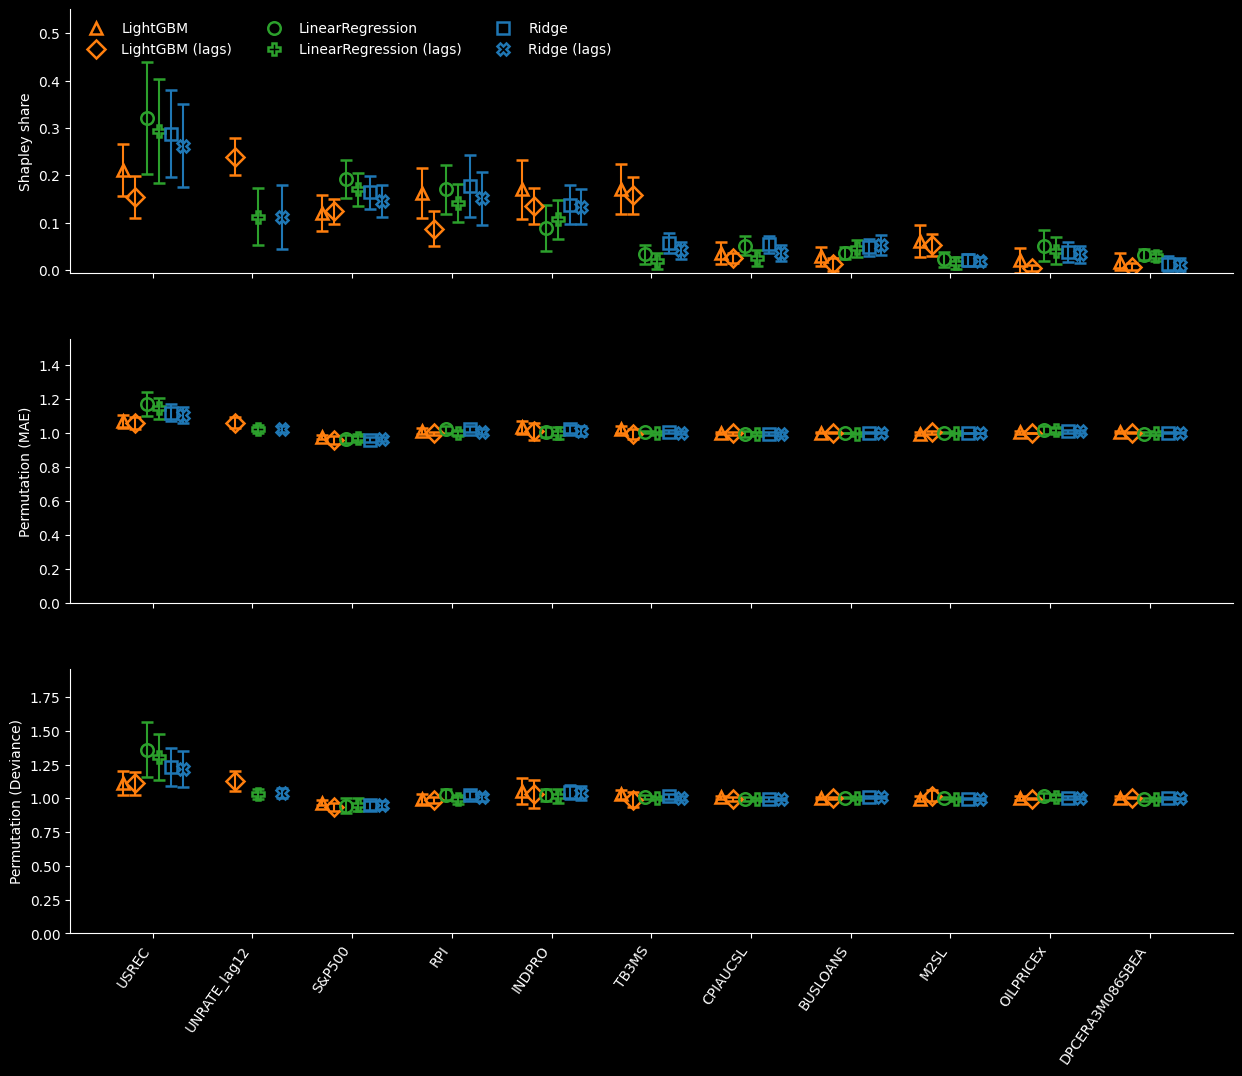

In [92]:
# ============================================================
# Figure "Shapley / Permutation importance" — SHAP mean+std + versions lags
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Optional, Mapping

# =======================
# Utils de conversion
# =======================

def _prep_shap_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Attend un DF avec colonnes:
      - 'feature'
      - 'shap_abs_mean'
      - 'shap_abs_std' (dispersion inter-fenêtres)
    Retourne un DF indexé par feature avec colonnes:
      - 'mean' (parts, somme=1)
      - 'std'  (parts, écart-type mis à l'échelle par le même facteur)
    """
    if not {"feature","shap_abs_mean"}.issubset(df.columns):
        raise ValueError("Le DataFrame SHAP doit contenir 'feature' et 'shap_abs_mean' (+ 'shap_abs_std' recommandé).")
    out = df[["feature","shap_abs_mean"]].copy()
    out = out.rename(columns={"shap_abs_mean":"mean"})
    if "shap_abs_std" in df.columns:
        out["std"] = df["shap_abs_std"].values.astype(float)
    else:
        out["std"] = np.nan
    out = out.set_index("feature").astype(float).abs()
    scale = out["mean"].sum()
    if scale and np.isfinite(scale) and scale > 0:
        out["mean"] /= scale
        out["std"]  /= scale
    return out

def _prep_perm_df(imp_df: pd.DataFrame) -> pd.DataFrame:
    """
    Uniformise permutation importance (MAE ou Deviance):
      colonnes attendues:
        - 'variable'
        - 'perm_score_ratio_mean'
        - optionnel: 'perm_score_ratio_std'
    Renvoie DF index=variable, colonnes ['mean','std'].
    """
    need = {"variable", "perm_score_ratio_mean"}
    if not need.issubset(imp_df.columns):
        raise ValueError("imp_df doit contenir 'variable' et 'perm_score_ratio_mean'.")
    out = imp_df[["variable", "perm_score_ratio_mean"]].copy()
    out = out.rename(columns={"perm_score_ratio_mean": "mean"})
    out["std"] = imp_df["perm_score_ratio_std"].values if "perm_score_ratio_std" in imp_df.columns else np.nan
    return out.set_index("variable").astype(float)

def _unify_feature_axis(shapleys, perm_abs, perm_dev, top_k: Optional[int]) -> list[str]:
    """
    Ordre commun des features basé d’abord sur SHAP (mean normalisé),
    sinon fallback sur permutation (mean).
    """
    features = set()
    if shapleys:
        for df in shapleys.values():
            features |= set(df.index)
    if perm_abs:
        for df in perm_abs.values():
            features |= set(df.index)
    if perm_dev:
        for df in perm_dev.values():
            features |= set(df.index)
    if not features:
        return []

    score = pd.Series(0.0, index=sorted(features))
    nseen = pd.Series(0,   index=score.index)

    if shapleys:
        for df in shapleys.values():
            s = df["mean"].reindex(score.index).fillna(0.0)
            score += s
            nseen += (s > 0).astype(int)

    if (nseen == 0).all() and perm_abs:
        for df in perm_abs.values():
            s = df["mean"].reindex(score.index).fillna(0.0)
            score += s
            nseen += (s > 0).astype(int)

    nseen = nseen.replace(0, 1)
    order = (score / nseen).sort_values(ascending=False).index.tolist()
    if top_k:
        order = order[:top_k]
    return order

def _model_styles() -> dict[str, dict]:
    # Couleurs distinctes par famille; variantes "(lags)" réutilisent la même couleur avec marqueur différent
    return {
        "LinearRegression": dict(color="#2ca02c", marker="o"),
        "LinearRegression (lags)": dict(color="#2ca02c", marker="P"),
        "Ridge": dict(color="#1f77b4", marker="s"),
        "Ridge (lags)": dict(color="#1f77b4", marker="X"),
        "LightGBM": dict(color="#ff7f0e", marker="^"),
        "LightGBM (lags)": dict(color="#ff7f0e", marker="D"),
    }

def _family_label(raw_key: str) -> Optional[str]:
    """
    Mappe les clés brutes (ex: 'LINREG', 'RIDGE_LAGS', 'LGBM_LAG') en labels affichés,
    avec suffixe ' (lags)' quand la clé contient 'lag'/'lags'.
    """
    k = str(raw_key).lower()
    has_lag = ("lag" in k)
    if k.startswith("linreg") or k.startswith("linear"):
        return "LinearRegression (lags)" if has_lag else "LinearRegression"
    if k.startswith("ridge"):
        return "Ridge (lags)" if has_lag else "Ridge"
    if k.startswith("lgbm") or "lightgbm" in k or "light" in k:
        return "LightGBM (lags)" if has_lag else "LightGBM"
    return None

# =======================
# Plot principal
# =======================

def plot_importance_panels(
    *,
    shapleys: Optional[Dict[str, pd.DataFrame]] = None,
    perm_abs: Optional[Dict[str, pd.DataFrame]] = None,
    perm_dev: Optional[Dict[str, pd.DataFrame]] = None,
    top_k: int = 12,
    figsize=(14, 20),     # ← plus haut !
    rotate=60,
    ylabels=("Shapley share", "Permutation (MAE)", "Permutation (Deviance)"),
    jitter=0.30,
    markersize=9,
    mew=1.8,
    elinewidth=1.5,
    capsize=4,
    hspace=0.25,          # ← plus d’espace vertical
    scale_y_factor=1.25   # ← étire un peu la dynamique verticale
):
    order = _unify_feature_axis(shapleys, perm_abs, perm_dev, top_k)
    if not order:
        raise ValueError("Aucune feature à afficher.")

    panels = []
    if shapleys is not None: panels.append("shap")
    if perm_abs is not None: panels.append("perm_abs")
    if perm_dev is not None: panels.append("perm_dev")

    fig, axes = plt.subplots(len(panels), 1, figsize=figsize, sharex=True,
                             gridspec_kw={"hspace": hspace})

    if len(panels) == 1:
        axes = [axes]

    model_names = sorted(list(set(
        ([] if shapleys is None else list(shapleys.keys())) +
        ([] if perm_abs is None else list(perm_abs.keys())) +
        ([] if perm_dev is None else list(perm_dev.keys()))
    )))

    styles = _model_styles()
    x = np.arange(len(order))

    if len(model_names) <= 1:
        offsets = {model_names[0]: 0.0} if model_names else {}
    else:
        offs = np.linspace(-jitter, jitter, len(model_names))
        offsets = {m: float(o) for m, o in zip(model_names, offs)}

    def _panel(ax, data: Dict[str, pd.DataFrame], title: str):
        ymax = 0
        ymin = 0
        for m in model_names:
            if m not in data:
                continue
            st = styles.get(m, {"color": "k", "marker": "o"})
            xv = x + offsets.get(m, 0.0)
            M = data[m].reindex(order)
            y = M["mean"].values
            yerr = M["std"].values if "std" in M.columns else None

            ax.errorbar(
                xv, y, yerr=yerr,
                fmt=st["marker"], ms=markersize, mew=mew, mfc="none",
                elinewidth=elinewidth, ecolor=st["color"], capsize=capsize,
                linestyle="none", color=st["color"]
            )
            ymax = max(ymax, np.nanmax(y + (yerr if yerr is not None else 0)))
            ymin = min(ymin, np.nanmin(y - (yerr if yerr is not None else 0)))

        ax.set_ylabel(title)
        ax.set_xticks(x)
        ax.set_xticklabels(order, rotation=rotate, ha="right")

        # ✅ Échelle verticale distincte + plus confortable
        if np.isfinite(ymax):
            ax.set_ylim(ymin * 1.05, ymax * scale_y_factor)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    titles = {"shap": ylabels[0], "perm_abs": ylabels[1], "perm_dev": ylabels[2]}
    for ax, pane in zip(axes, panels):
        _panel(ax, {"shap": shapleys, "perm_abs": perm_abs, "perm_dev": perm_dev}[pane], titles[pane])

    handles = [
        plt.Line2D([], [], marker=styles[m]["marker"], linestyle="none",
                   color=styles[m]["color"], label=m,
                   markerfacecolor="none", markeredgewidth=mew, markersize=markersize)
        for m in model_names
    ]
    axes[0].legend(handles=handles, loc="upper left", frameon=False, ncol=3)

    plt.tight_layout()
    return fig

# ============================================================
# Construction des entrées depuis TES dictionnaires
# (shap_oos_results, results_perm, results_perm_deviance)
# ============================================================

# --- SHAP (moyenne + std) ---
shapleys_in: Dict[str, pd.DataFrame] = {}
for raw_key, df in shap_oos_results.items():
    label = _family_label(raw_key)
    if label is None:
        continue
    shapleys_in[label] = _prep_shap_df(df)

# --- Permutation MAE ---
perm_abs_in: Dict[str, pd.DataFrame] = {}
for raw_key, df in results_perm.items():
    label = _family_label(raw_key)
    if label is None:
        continue
    perm_abs_in[label] = _prep_perm_df(df)

# --- Permutation Deviance ---
perm_dev_in: Dict[str, pd.DataFrame] = {}
for raw_key, df in results_perm_deviance.items():
    label = _family_label(raw_key)
    if label is None:
        continue
    perm_dev_in[label] = _prep_perm_df(df)

# ============================================================
# APPEL
# ============================================================
fig = plot_importance_panels(
    shapleys=shapleys_in or None,
    perm_abs=perm_abs_in or None,
    perm_dev=perm_dev_in or None,
    top_k=12,
    figsize=(15, 12),
    rotate=55
)
plt.show()

# Sauvegarde optionnelle
# fig.savefig("importance_panels_shap_perm_with_lags.png", dpi=300, bbox_inches="tight")

Les variables sont ici classées selon leur contribution moyenne (valeurs de Shapley) calculée à partir des modèles. Pour chaque variable, les lignes verticales relient la contribution minimale et maximale observée entre les modèles afin de mettre en évidence les divergences d’évaluation.

On remarque que les valeurs de Shapley et l’importance par permutation n’aboutissent pas aux mêmes classements nécessairement. Par exemple, avec LightGBM, le taux des bons du Trésor à 3 mois apparaît nettement plus important selon Shapley values que selon l’importance par permutation.

Cette différence vient du fait que l’importance par permutation mesure l’effet d’une variable sur la précision du modèle, ce qui dépend des relations statistiques présentes à une période donnée. À l’inverse, les valeurs de Shapley mesurent l’effet d’une variable sur la valeur prédite, indépendamment de l’exactitude globale de la prédiction. En contexte de prévision, cette approche est souvent plus informative, car elle peut être utilisée même lorsque la valeur réelle n’est pas encore observée (ce qui rend l’importance par permutation inutilisable).

On montre une variante de l’importance par permutation. Au lieu de mesurer l’impact sur l’erreur, on mesure l’impact sur la prédiction elle-même. Cette version se rapproche davantage des valeurs de Shapley. De plus, lorsque l’importance par permutation est calculée à l’aide des prédictions “out-of-bag”, elle se rapproche également des résultats Shapley, car la relation entre variables reste cohérente entre l’apprentissage et l’évaluation.

Dans l’ensemble, les modèles donnent un classement des variables relativement cohérent selon les valeurs de Shapley. Les 05 premiers variables les plus déterminantes ont changé. Si au départ, ils sont dans l'ordre USREC, INDPRO, TB3MS, SP500, OILPRICE, actuellement il s'agit de USREC, UNRATE_lags_12, SP500, RPI, INDPRO.

UNRATE_lag_12 ressort comme la variable la plus importante. Elle met en lumière un effet du revenu qui était moins visible avant. Les modèles réduisent maintenant clairement l’importance de INDPRO : au lieu de 20–30 %, elle tourne autour de 12 %, ce qui est plus réaliste. L’effet trop fort de OILPRICE disparaît aussi. L’offre monétaire compte moins qu’avant. Enfin, TB3MS reste très important pour LightGBM, mais l’importance par permutation montre que ce modèle a tendance à le surestimer.

Des différences subsistent concernant les résultats des modèles. La régression ridge et régression s’écarte régulièrement de LightGBM. 

Même si le calcul des valeurs de Shapley est techniquement sophistiqué, leur interprétation est intuitive. Elles indiquent la part de chaque variable dans les prédictions du modèle. Un graphique présentant seulement le modèle le plus performant peut donc être communiqué efficacement à des décideurs.

Cette analyse est globale et donne l'importance moyenne des variables sur toute la période. Pour interpréter une prévision précise, il vaut mieux regarder les explications locales, observation par observation, notamment pour les valeurs récentes.

# Test de validation des variables importantes

# 🧩 Règles d’interprétation — *Shapley Regression*

La *Shapley regression* repose sur la relation suivante :

$$
y_t = \beta_0^S + \sum_{k=1}^K \beta_k^S \, \phi_{k,t} + \varepsilon_t
$$

où :  
- $y_t$ : variable cible (par ex. le taux de chômage à horizon $h$) ;  
- $\phi_{k,t}$ : valeur SHAP de la variable $k$ à la période $t$ ;  
- $\beta_k^S$ : coefficient d’alignement *Shapley* ;  
- $\Gamma_k^S$ : part moyenne absolue (*Shapley share*) ;  
- $p\text{-value}$ : significativité statistique de $\beta_k^S$.

---

## 🔹 1️⃣ Coefficient d’alignement — $\beta_k^S$

Le coefficient $\beta_k^S$ mesure **dans quelle mesure la composante SHAP** d’une variable est alignée avec la cible réelle $y$.  
Il évalue si le modèle **apprend correctement l’effet de la variable**.

| Valeur de $\beta_k^S$ | Interprétation |
|:-----------------------|:----------------|
| **$\beta_k^S = 1$** | Le modèle estime **exactement** l’effet réel de la variable (*apprentissage parfait*). |
| **$\beta_k^S > 1$** | Le modèle **sous-estime** l’effet réel → la variable a un impact plus fort dans les données que dans le modèle. |
| **$\beta_k^S < 1$** | Le modèle **surestime** l’effet → l’influence de la variable est exagérée. |
| **$\beta_k^S < 0$** | Le modèle attribue à la variable un **effet de signe inverse** à celui observé empiriquement. |

---

## 🔹 2️⃣ Significativité statistique — *p-value*

La p-value teste l’hypothèse nulle $H_0: \beta_k^S = 0$.  
Elle indique si la composante SHAP de la variable $k$ est **statistiquement alignée** avec la cible.

| p-value | Interprétation |
|:---------|:----------------|
| **< 0.01** | Effet **hautement significatif** (***). |
| **< 0.05** | Effet **significatif** (**). |
| **< 0.10** | Effet **marginalement significatif** (*). |
| **≥ 0.10** | Effet **non significatif**. |

---

## 🔹 3️⃣ Importance relative — $\Gamma_k^S$

$$
\Gamma_k^S = \frac{\overline{|\phi_k|}}{\sum_j \overline{|\phi_j|}}
$$

La part moyenne absolue (*Shapley share*) mesure **l’importance relative** d’une variable dans la décomposition SHAP.  
Elle indique **dans quelle proportion** la variable contribue à la prédiction du modèle.

| Valeur de $\Gamma_k^S$ | Interprétation |
|:------------------------|:----------------|
| **élevée (≥ 0.15)** | Variable **majeure** : le modèle s’appuie fortement dessus. |
| **moyenne (≈ 0.05–0.15)** | Variable **complémentaire** : contribue modérément. |
| **faible (< 0.05)** | Variable **secondaire** ou redondante. |

---

## 🔹 4️⃣ Corrélation — $\rho(\phi_k, y)$

La corrélation entre la composante SHAP et la cible indique **le signe et la direction de la relation** :

| Valeur de $\rho(\phi_k, y)$ | Interprétation |
|:-----------------------------|:----------------|
| **$\rho > 0$** | La variable a un **effet positif** sur la cible (sa hausse augmente $y$). |
| **$\rho < 0$** | La variable a un **effet négatif** sur la cible (sa hausse réduit $y$). |
| **$|\rho| \approx 0$** | Effet **instable** ou **non directionnel**. |

---

## 🧭 Résumé visuel

| Élément | Notation | Interprétation principale |
|:----------|:-----------:|:--------------------------|
| **Coefficient Shapley** | $\beta_k^S$ | Alignement entre la contribution SHAP et la cible $y$. |
| **p-value** | — | Test de significativité de $\beta_k^S$. |
| **Part Shapley** | $\Gamma_k^S$ | Importance relative moyenne de la variable. |
| **Corrélation** | $\rho(\phi_k, y)$ | Signe et direction de l’effet de la variable sur la cible. |

In [97]:
# ==========================================================
# STEP 3 — Shapley regressions (Linear, Ridge, LightGBM) + versions lags
# Compatible SHAP 0.48.0 et versions antérieures
# ==========================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import shap
from typing import Optional, Tuple, List, Dict

print(f"[INFO] Version SHAP détectée : {shap.__version__}")

# ==========================================================
# 🔧 UTILITAIRES
# ==========================================================
def _sigstars(p: float) -> str:
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.1 else ""))

def _shap_shares_with_dispersion(phi: np.ndarray, feat_names: list[str]) -> pd.DataFrame:
    """Γˢ = mean(|phi|)/sum(mean(|phi|)) ; Γˢ_std = std(|phi|)/sum(mean(|phi|))"""
    abs_vals = np.abs(phi)
    mu = abs_vals.mean(axis=0)
    sd = abs_vals.std(axis=0, ddof=1) if abs_vals.shape[0] > 1 else np.zeros_like(mu)
    denom = mu.sum() if mu.sum() > 0 else 1.0
    shares = mu / denom
    shares_std = sd / denom
    return pd.DataFrame({"Γˢ": shares, "Γˢ_std": shares_std}, index=feat_names).sort_values("Γˢ", ascending=False)

def _apply_preproc_general(X: pd.DataFrame, prep: Optional[dict]) -> pd.DataFrame:
    if prep is None:
        return X
    Xp = X.copy()
    lower = prep.get("lower_wins", prep.get("lower", None))
    upper = prep.get("upper_wins", prep.get("upper", None))
    if lower is not None and upper is not None:
        lower_s = pd.Series(lower, index=Xp.columns) if not isinstance(lower, pd.Series) else lower.reindex(Xp.columns)
        upper_s = pd.Series(upper, index=Xp.columns) if not isinstance(upper, pd.Series) else upper.reindex(Xp.columns)
        Xp = Xp.clip(lower=lower_s, upper=upper_s, axis=1)
    if prep.get("norm", False):
        mean = prep.get("mean", None)
        std  = prep.get("std",  None)
        if mean is not None and std is not None:
            mean_s = pd.Series(mean, index=Xp.columns) if not isinstance(mean, pd.Series) else mean.reindex(Xp.columns)
            std_s  = pd.Series(std,  index=Xp.columns) if not isinstance(std,  pd.Series) else std.reindex(Xp.columns)
            Xp = (Xp - mean_s) / std_s.replace(0, 1)
    return Xp

def _get_preproc_apply_fn():
    return globals().get("apply_preproc", _apply_preproc_general)

# ==========================================================
# ⚙️ HELPERS FENÊTRE OOS (auto-contents si pas déjà définis)
# ==========================================================
def _unwrap_estimator(m):
    base = m
    if hasattr(base, "_base"):
        try: base = base._base
        except Exception: pass
    try:
        from sklearn.pipeline import Pipeline
        if isinstance(base, Pipeline):
            base = base.steps[-1][1]
    except Exception:
        pass
    return base

def _get_last_model_and_data(exp_results: dict, df_all: pd.DataFrame, target_col: str):
    """Récupère le dernier modèle/fenêtre + X complet brut aligné aux features."""
    models   = exp_results["models"]
    features = list(exp_results["features"])
    preprocs = exp_results.get("preprocs", None)
    periods  = list(exp_results["train_periods"])
    if not isinstance(df_all.index, pd.DatetimeIndex):
        df_all = df_all.copy()
        df_all.index = pd.to_datetime(df_all.index)

    last_i = len(models) - 1
    end_time = pd.to_datetime(periods[last_i])
    df_win = df_all.loc[:end_time].copy()
    X_full = df_win[features].copy()
    y_full = df_win[target_col].copy() if target_col in df_win.columns else None
    model_final = models[last_i]
    prep_final  = preprocs[last_i] if preprocs is not None else None
    return X_full, y_full, model_final, prep_final, end_time

def _build_X_y_for_window(df_win: pd.DataFrame, feat_names: list[str], target_col: str, h: int = 12):
    """Construit X_t et y_{t+h} (alignement horizon)."""
    X = df_win[feat_names].copy()
    if target_col not in df_win.columns:
        return None, None
    y = df_win[target_col].shift(-h).copy()
    keep = X.index.intersection(y.dropna().index)
    X = X.loc[keep]
    y = y.loc[keep]
    return X, y

def _eval_window_bounds(restrict_eval_window: Optional[Tuple[str, str]]):
    if not restrict_eval_window:
        return None, None
    a, b = restrict_eval_window
    return (None if a in (None, "") else pd.to_datetime(a),
            None if b in (None, "") else pd.to_datetime(b))

def _mask_eval_window(df_win: pd.DataFrame, n_y: int, h: int, eval_start, eval_end):
    idx = df_win.index[:n_y]  # X_t aligné avec y_{t+h} (après shift)
    mask = pd.Series(True, index=idx)
    if eval_start is not None:
        mask &= (idx >= eval_start)
    if eval_end is not None:
        mask &= (idx <= eval_end)
    return mask.values

def _mask_valid_rows(X_raw: pd.DataFrame, y: pd.Series, mask_window: np.ndarray):
    ok = (~X_raw.isna().any(axis=1)).values & (~y.isna().values) & mask_window
    return ok

# ==========================================================
# ⚙️ SHAP Extraction robuste (compat 0.48.0 et avant)
# ==========================================================
def shap_components_oos_for_last_window(
    *,
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    restrict_eval_window: Optional[Tuple[str, str]] = None,
) -> Tuple[np.ndarray, np.ndarray, list[str], float, str]:
    if not isinstance(df_all.index, pd.DatetimeIndex):
        df_all = df_all.copy()
        df_all.index = pd.to_datetime(df_all.index)

    X_full, Y_full, model_final, prep_final, end_time_final = _get_last_model_and_data(
        exp_results, df_all, target_col
    )
    feat_names = list(X_full.columns)
    df_win = df_all.loc[:end_time_final].copy()

    X_raw, y = _build_X_y_for_window(df_win, feat_names, target_col, h=h)
    if X_raw is None or len(X_raw) == 0:
        raise RuntimeError("Fenêtre trop courte pour construire X_t / y_{t+h}.")

    eval_start, eval_end = _eval_window_bounds(restrict_eval_window)
    mask_window = _mask_eval_window(df_win, len(y), h, eval_start, eval_end)
    valid = _mask_valid_rows(X_raw, y, mask_window)
    if not np.any(valid):
        raise RuntimeError("Aucune observation valide après masquage.")

    X_raw = X_raw.loc[valid]
    y_use = y.loc[valid]
    X_pp = _get_preproc_apply_fn()(X_raw, prep_final)

    base_model = _unwrap_estimator(model_final)
    name = type(base_model).__name__.lower()
    module = getattr(base_model.__class__, "__module__", "").lower()
    blob = f"{name}|{module}"

    # --- SHAP computation (versions compatibles) ---
    phi = None
    base_values = None
    try:
        if any(k in blob for k in ["lgbm", "lightgbm", "xgboost", "catboost", "histgradient", "randomforest", "gradientboost"]):
            try:
                expl = shap.TreeExplainer(base_model, X_pp, check_additivity=False)
                sv = expl.shap_values(X_pp)
            except TypeError:
                expl = shap.TreeExplainer(base_model, X_pp)
                sv = expl.shap_values(X_pp, check_additivity=False)
            phi = sv
            base_values = getattr(expl, "expected_value", None)
        else:
            try:
                expl = shap.Explainer(base_model, X_pp)   # 0.48.0
                expn = expl(X_pp)
                phi = getattr(expn, "values", None)
                if phi is None:
                    phi = np.array(expn)
                base_values = getattr(expl, "expected_value", None)
            except Exception:
                coef = getattr(base_model, "coef_", None)
                intercept = getattr(base_model, "intercept_", 0.0)
                if coef is None:
                    raise
                phi = X_pp.to_numpy() * np.asarray(coef).reshape(1, -1)
                base_values = np.asarray(intercept)
    except Exception as e:
        raise RuntimeError(f"Échec SHAP pour {type(base_model).__name__}: {e}")

    if isinstance(phi, list):
        phi = phi[0]
    phi = np.asarray(phi)
    if phi.ndim == 3:
        phi = phi[0]
    if phi.shape[1] != X_pp.shape[1]:
        raise ValueError("Dimensions SHAP et features incompatibles.")
    model_name = type(base_model).__name__.lower()
    return phi, y_use.to_numpy(), feat_names, base_values, model_name

# ==========================================================
# 📊 Régression de Shapley
# ==========================================================
def shapley_regression(y_true: np.ndarray, phi: np.ndarray, feat_names: list[str], cov_type: str = "HC1") -> pd.DataFrame:
    X = sm.add_constant(phi)
    res = sm.OLS(y_true, X).fit(cov_type=cov_type)
    out = pd.DataFrame({
        "βˢ": res.params[1:],
        "std_err": res.bse[1:],
        "t": res.tvalues[1:],
        "p-value": res.pvalues[1:]
    }, index=feat_names)
    out["sig"] = out["p-value"].map(_sigstars)
    return out

# ==========================================================
# 📜 Table générique (un seul modèle)
# ==========================================================
def shapley_table_generic(
    *,
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    restrict_eval_window: Optional[Tuple[str, str]] = None,
    model_label: str = "Model",
) -> pd.DataFrame:
    phi, y, feat_names, _, _ = shap_components_oos_for_last_window(
        exp_results=exp_results,
        df_all=df_all,
        target_col=target_col,
        h=h,
        restrict_eval_window=restrict_eval_window,
    )
    reg = shapley_regression(y, phi, feat_names)
    shares_df = _shap_shares_with_dispersion(phi, feat_names)
    tbl = pd.concat([reg[["βˢ", "p-value", "sig"]], shares_df], axis=1)
    tbl = tbl.sort_values("Γˢ", ascending=False)
    tbl.columns = pd.MultiIndex.from_product([[model_label], tbl.columns])
    return tbl

# ==========================================================
# ♻️ Multi-modèles (inclut les versions lags automatiquement)
# ==========================================================
def _label_from_key(k: str) -> str:
    kk = str(k).lower()
    has_lags = ("lag" in kk) or ("lags" in kk)
    if kk.startswith("exp_lin") or "linear" in kk:
        return "Linear regression (lags)" if has_lags else "Linear regression"
    if kk.startswith("exp_ridge") or kk.startswith("ridge"):
        return "Ridge (lags)" if has_lags else "Ridge"
    if kk.startswith("exp_lgbm") or "lgbm" in kk or "lightgbm" in kk:
        return "LightGBM (lags)" if has_lags else "LightGBM"
    return str(k)

def shapley_tables_for_models(
    *,
    exp_models: Dict[str, dict],
    horizons: Optional[Dict[str, int]] = None,
    df_all: pd.DataFrame,
    target_col: str,
    restrict_eval_window: Optional[Tuple[str, str]] = None,
) -> Dict[str, pd.DataFrame]:
    out: Dict[str, pd.DataFrame] = {}
    for key, exp in exp_models.items():
        label = _label_from_key(key)
        h = (horizons or {}).get(key, 12)
        try:
            tbl = shapley_table_generic(
                exp_results=exp,
                df_all=df_all,
                target_col=target_col,
                h=h,
                restrict_eval_window=restrict_eval_window,
                model_label=label
            )
            out[label] = tbl
        except Exception as e:
            print(f"⚠️ {key}: échec Shapley regression → {e}")
    return out

# ==========================================================
# 🚀 EXÉCUTION : tous les modèles (avec et sans lags)
# ==========================================================
if __name__ == "__main__":
    # Récupère ce que tu as déjà construit (adapte si besoin)
    exp_models_all: Dict[str, dict] = {}
    for varname in ["exp_lin", "exp_lin_lags", "exp_ridge", "exp_ridge_lags", "exp_lgbm", "exp_lgbm_lags"]:
        if varname in globals() and isinstance(globals()[varname], dict):
            exp_models_all[varname] = globals()[varname]

    # Horizons par modèle (fallback 12)
    horizons: Dict[str, int] = {}
    for key in list(exp_models_all.keys()):
        bundle_name = (key.replace("exp_", "") + "_bundle")
        b = globals().get(bundle_name)
        if isinstance(b, dict):
            horizons[key] = int(b.get("params", {}).get("horizon", 12))
        else:
            horizons[key] = 12

    eval_window = ("1990-01-01", "2025-12-31")
    target = "UNRATE"

    # Exécuter pour tous les modèles
    tbl_dict = shapley_tables_for_models(
        exp_models=exp_models_all,
        horizons=horizons,
        df_all=df_stationary_test,
        target_col=target,
        restrict_eval_window=eval_window,
    )

    # Concat horizontal (colonnes multi-index) + affichage + sauvegarde
    if tbl_dict:
        tbl_all = pd.concat([tbl_dict[k] for k in tbl_dict.keys()], axis=1)

        print("\n=== Shapley regression — tous modèles (incl. lags) ===")
        with pd.option_context(
            "display.max_rows", None,
            "display.max_columns", None,
            "display.max_colwidth", None,
            "display.expand_frame_repr", False,
            "display.width", 10_000
        ):
            print(tbl_all.round(3).to_string())

        for label, tbl in tbl_dict.items():
            safe = label.lower().replace(" ", "_").replace("(", "").replace(")", "")
            tbl.round(4).to_csv(f"table_shapley_regression_{safe}.csv", encoding="utf-8")
        tbl_all.round(4).to_csv("table_shapley_regression_all_models.csv", encoding="utf-8")

        print("\n💾 Sauvé :")
        for label in tbl_dict.keys():
            safe = label.lower().replace(" ", "_").replace("(", "").replace(")", "")
            print(f" - table_shapley_regression_{safe}.csv")
        print(" - table_shapley_regression_all_models.csv")
    else:
        print("Aucun modèle n'a produit de table Shapley.")

[INFO] Version SHAP détectée : 0.48.0
Aucun modèle n'a produit de table Shapley.


In [98]:
# ==========================================================
# STEP 3 — Shapley regressions (Linear, Ridge, LightGBM) + versions lags
# Compatible SHAP 0.48.0 et versions antérieures
# ==========================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import shap
from typing import Optional, Tuple, Dict

print(f"[INFO] Version SHAP détectée : {shap.__version__}")

# ==========================================================
# 🔧 UTILITAIRES
# ==========================================================
def _sigstars(p: float) -> str:
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.1 else ""))

def _shap_shares_with_dispersion(phi: np.ndarray, feat_names: list[str]) -> pd.DataFrame:
    """Γˢ = mean(|phi|)/sum(mean(|phi|)) ; Γˢ_std = std(|phi|)/sum(mean(|phi|))"""
    abs_vals = np.abs(phi)
    mu = abs_vals.mean(axis=0)
    sd = abs_vals.std(axis=0, ddof=1) if abs_vals.shape[0] > 1 else np.zeros_like(mu)
    denom = mu.sum() if mu.sum() > 0 else 1.0
    shares = mu / denom
    shares_std = sd / denom
    return pd.DataFrame({"Γˢ": shares, "Γˢ_std": shares_std}, index=feat_names).sort_values("Γˢ", ascending=False)

def _apply_preproc_general(X: pd.DataFrame, prep: Optional[dict]) -> pd.DataFrame:
    if prep is None:
        return X
    Xp = X.copy()
    lower = prep.get("lower_wins", prep.get("lower", None))
    upper = prep.get("upper_wins", prep.get("upper", None))
    if lower is not None and upper is not None:
        lower_s = pd.Series(lower, index=Xp.columns) if not isinstance(lower, pd.Series) else lower.reindex(Xp.columns)
        upper_s = pd.Series(upper, index=Xp.columns) if not isinstance(upper, pd.Series) else upper.reindex(Xp.columns)
        Xp = Xp.clip(lower=lower_s, upper=upper_s, axis=1)
    if prep.get("norm", False):
        mean = prep.get("mean", None)
        std  = prep.get("std",  None)
        if mean is not None and std is not None:
            mean_s = pd.Series(mean, index=Xp.columns) if not isinstance(mean, pd.Series) else mean.reindex(Xp.columns)
            std_s  = pd.Series(std,  index=Xp.columns) if not isinstance(std,  pd.Series) else std.reindex(Xp.columns)
            Xp = (Xp - mean_s) / std_s.replace(0, 1)
    return Xp

def _get_preproc_apply_fn():
    # Permet d’utiliser une fonction externe 'apply_preproc' si elle existe déjà
    return globals().get("apply_preproc", _apply_preproc_general)

# ==========================================================
# ⚙️ HELPERS FENÊTRE OOS
# ==========================================================
def _unwrap_estimator(m):
    base = m
    if hasattr(base, "_base"):
        try:
            base = base._base
        except Exception:
            pass
    try:
        from sklearn.pipeline import Pipeline
        if isinstance(base, Pipeline):
            base = base.steps[-1][1]
    except Exception:
        pass
    return base

def _get_last_model_and_data(exp_results: dict, df_all: pd.DataFrame, target_col: str):
    """Récupère le dernier modèle/fenêtre + X complet brut aligné aux features."""
    models   = exp_results["models"]
    features = list(exp_results["features"])
    preprocs = exp_results.get("preprocs", None)
    periods  = list(exp_results["train_periods"])

    if not isinstance(df_all.index, pd.DatetimeIndex):
        df_all = df_all.copy()
        df_all.index = pd.to_datetime(df_all.index)

    last_i = len(models) - 1
    end_time = pd.to_datetime(periods[last_i])
    df_win = df_all.loc[:end_time].copy()
    X_full = df_win[features].copy()
    y_full = df_win[target_col].copy() if target_col in df_win.columns else None
    model_final = models[last_i]
    prep_final  = preprocs[last_i] if preprocs is not None else None
    return X_full, y_full, model_final, prep_final, end_time

def _build_X_y_for_window(df_win: pd.DataFrame, feat_names: list[str], target_col: str, h: int = 12):
    """Construit X_t et y_{t+h} (alignement horizon)."""
    X = df_win[feat_names].copy()
    if target_col not in df_win.columns:
        return None, None
    y = df_win[target_col].shift(-h).copy()
    keep = X.index.intersection(y.dropna().index)
    X = X.loc[keep]
    y = y.loc[keep]
    return X, y

def _eval_window_bounds(restrict_eval_window: Optional[Tuple[str, str]]):
    if not restrict_eval_window:
        return None, None
    a, b = restrict_eval_window
    return (None if a in (None, "") else pd.to_datetime(a),
            None if b in (None, "") else pd.to_datetime(b))

def _mask_eval_window(df_win: pd.DataFrame, n_y: int, h: int, eval_start, eval_end):
    idx = df_win.index[:n_y]  # X_t aligné avec y_{t+h} (après shift)
    mask = pd.Series(True, index=idx)
    if eval_start is not None:
        mask &= (idx >= eval_start)
    if eval_end is not None:
        mask &= (idx <= eval_end)
    return mask.values

def _mask_valid_rows(X_raw: pd.DataFrame, y: pd.Series, mask_window: np.ndarray):
    ok = (~X_raw.isna().any(axis=1)).values & (~y.isna().values) & mask_window
    return ok

# ==========================================================
# ⚙️ SHAP Extraction robuste (compat 0.48.0 et avant)
# ==========================================================
def shap_components_oos_for_last_window(
    *,
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    restrict_eval_window: Optional[Tuple[str, str]] = None,
):
    if not isinstance(df_all.index, pd.DatetimeIndex):
        df_all = df_all.copy()
        df_all.index = pd.to_datetime(df_all.index)

    X_full, Y_full, model_final, prep_final, end_time_final = _get_last_model_and_data(
        exp_results, df_all, target_col
    )
    feat_names = list(X_full.columns)
    df_win = df_all.loc[:end_time_final].copy()

    X_raw, y = _build_X_y_for_window(df_win, feat_names, target_col, h=h)
    if X_raw is None or len(X_raw) == 0:
        raise RuntimeError("Fenêtre trop courte pour construire X_t / y_{t+h}.")

    eval_start, eval_end = _eval_window_bounds(restrict_eval_window)
    mask_window = _mask_eval_window(df_win, len(y), h, eval_start, eval_end)
    valid = _mask_valid_rows(X_raw, y, mask_window)
    if not np.any(valid):
        raise RuntimeError("Aucune observation valide après masquage.")

    X_raw = X_raw.loc[valid]
    y_use = y.loc[valid]
    X_pp = _get_preproc_apply_fn()(X_raw, prep_final)

    base_model = _unwrap_estimator(model_final)
    name = type(base_model).__name__.lower()
    module = getattr(base_model.__class__, "__module__", "").lower()
    blob = f"{name}|{module}"

    # --- SHAP computation (versions compatibles) ---
    phi = None
    try:
        if any(k in blob for k in ["lgbm", "lightgbm", "xgboost", "catboost", "histgradient", "randomforest", "gradientboost"]):
            try:
                expl = shap.TreeExplainer(base_model, X_pp, check_additivity=False)
                sv = expl.shap_values(X_pp)
            except TypeError:
                expl = shap.TreeExplainer(base_model, X_pp)
                sv = expl.shap_values(X_pp, check_additivity=False)
            phi = sv
        else:
            try:
                expl = shap.Explainer(base_model, X_pp)   # 0.48.0
                expn = expl(X_pp)
                phi = getattr(expn, "values", None)
                if phi is None:
                    phi = np.array(expn)
            except Exception:
                coef = getattr(base_model, "coef_", None)
                intercept = getattr(base_model, "intercept_", 0.0)
                if coef is None:
                    raise
                phi = X_pp.to_numpy() * np.asarray(coef).reshape(1, -1)
    except Exception as e:
        raise RuntimeError(f"Échec SHAP pour {type(base_model).__name__}: {e}")

    if isinstance(phi, list):
        phi = phi[0]
    phi = np.asarray(phi)
    if phi.ndim == 3:
        phi = phi[0]
    if phi.shape[1] != X_pp.shape[1]:
        raise ValueError("Dimensions SHAP et features incompatibles.")

    return phi, y_use.to_numpy(), feat_names

# ==========================================================
# 📊 Régression de Shapley
# ==========================================================
def shapley_regression(y_true: np.ndarray, phi: np.ndarray, feat_names: list[str], cov_type: str = "HC1") -> pd.DataFrame:
    X = sm.add_constant(phi)
    res = sm.OLS(y_true, X).fit(cov_type=cov_type)
    out = pd.DataFrame({
        "βˢ": res.params[1:],
        "std_err": res.bse[1:],
        "t": res.tvalues[1:],
        "p-value": res.pvalues[1:]
    }, index=feat_names)
    out["sig"] = out["p-value"].map(_sigstars)
    return out

# ==========================================================
# 📜 Table générique (un seul modèle)
# ==========================================================
def shapley_table_generic(
    *,
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    restrict_eval_window: Optional[Tuple[str, str]] = None,
    model_label: str = "Model",
) -> pd.DataFrame:
    phi, y, feat_names = shap_components_oos_for_last_window(
        exp_results=exp_results,
        df_all=df_all,
        target_col=target_col,
        h=h,
        restrict_eval_window=restrict_eval_window,
    )
    reg = shapley_regression(y, phi, feat_names)
    shares_df = _shap_shares_with_dispersion(phi, feat_names)
    tbl = pd.concat([reg[["βˢ", "p-value", "sig"]], shares_df], axis=1)
    tbl = tbl.sort_values("Γˢ", ascending=False)
    tbl.columns = pd.MultiIndex.from_product([[model_label], tbl.columns])
    return tbl

# ==========================================================
# ♻️ Multi-modèles (inclut les versions lags automatiquement)
# ==========================================================
def _label_from_key(k: str) -> str:
    kk = str(k).lower()
    has_lags = ("lag" in kk) or ("lags" in kk)
    if kk.startswith("exp_lin") or "linear" in kk:
        return "Linear regression (lags)" if has_lags else "Linear regression"
    if kk.startswith("exp_ridge") or kk.startswith("ridge"):
        return "Ridge (lags)" if has_lags else "Ridge"
    if kk.startswith("exp_lgbm") or "lgbm" in kk or "lightgbm" in kk:
        return "LightGBM (lags)" if has_lags else "LightGBM"
    return str(k)

def shapley_tables_for_models(
    *,
    exp_models: Dict[str, dict],
    horizons: Optional[Dict[str, int]] = None,
    df_all: pd.DataFrame,
    target_col: str,
    restrict_eval_window: Optional[Tuple[str, str]] = None,
) -> Dict[str, pd.DataFrame]:
    out: Dict[str, pd.DataFrame] = {}
    for key, exp in exp_models.items():
        label = _label_from_key(key)
        h = (horizons or {}).get(key, 12)
        try:
            tbl = shapley_table_generic(
                exp_results=exp,
                df_all=df_all,
                target_col=target_col,
                h=h,
                restrict_eval_window=restrict_eval_window,
                model_label=label
            )
            out[label] = tbl
        except Exception as e:
            print(f"⚠️ {key}: échec Shapley regression → {e}")
    return out

# ==========================================================
# 🚀 EXÉCUTION : tous les modèles (avec et sans lags)
# ==========================================================
if __name__ == "__main__":
    # 1) Source principale : 'exp_models' si déjà construit (clefs propres)
    exp_models_all: Dict[str, dict] = {}
    if "exp_models" in globals() and isinstance(globals()["exp_models"], dict) and globals()["exp_models"]:
        exp_models_all = dict(globals()["exp_models"])
        print(f"[INFO] exp_models détecté ({len(exp_models_all)} entrées) → {list(exp_models_all.keys())}")
    else:
        # 2) Fallback : variables individuelles (si présentes)
        for varname in ["exp_lin", "exp_lin_lags", "exp_ridge", "exp_ridge_lags", "exp_lgbm", "exp_lgbm_lags"]:
            if varname in globals() and isinstance(globals()[varname], dict):
                exp_models_all[varname] = globals()[varname]
        print(f"[INFO] Collect fallback ({len(exp_models_all)} entrées) → {list(exp_models_all.keys())}")

    if not exp_models_all:
        raise RuntimeError("Aucun modèle fourni à STEP 3 (exp_models ou exp_* manquants).")

    # Horizons par modèle (fallback 12)
    horizons: Dict[str, int] = {}
    for key in list(exp_models_all.keys()):
        # essaie de trouver un bundle homonyme pour récupérer un éventuel 'horizon'
        bundle_guess = key.replace("exp_", "")
        bundle_guess = bundle_guess if bundle_guess.endswith("_bundle") else f"{bundle_guess}_bundle"
        b = globals().get(bundle_guess)
        if isinstance(b, dict):
            horizons[key] = int(b.get("params", {}).get("horizon", 12))
        else:
            horizons[key] = 12

    # Data source
    if "df_stationary_test" not in globals():
        raise RuntimeError("df_stationary_test introuvable dans le namespace global.")
    _df = df_stationary_test.copy()
    _df.index = pd.to_datetime(_df.index).sort_values()

    # Sanity features
    missing_any = []
    for k, exp in exp_models_all.items():
        feats = list(exp.get("features", []))
        miss = [f for f in feats if f not in _df.columns]
        if miss:
            missing_any.append((k, miss[:5]))
    if missing_any:
        msg = "; ".join([f"{k}: {m}" for k, m in missing_any])
        raise KeyError(f"Features absentes pour certains modèles → {msg}")
    print("[INFO] Données OK (index trié, features présentes).")

    eval_window = ("1990-01-01", "2025-12-31")
    target = "UNRATE"

    # Exécuter pour tous les modèles
    tbl_dict = shapley_tables_for_models(
        exp_models=exp_models_all,
        horizons=horizons,
        df_all=_df,
        target_col=target,
        restrict_eval_window=eval_window,
    )

    # Concat horizontal (colonnes multi-index) + affichage + sauvegarde
    if tbl_dict:
        tbl_all = pd.concat([tbl_dict[k] for k in tbl_dict.keys()], axis=1)

        print("\n=== Shapley regression — tous modèles (incl. lags) ===")
        with pd.option_context(
            "display.max_rows", None,
            "display.max_columns", None,
            "display.max_colwidth", None,
            "display.expand_frame_repr", False,
            "display.width", 10_000
        ):
            print(tbl_all.round(3).to_string())

        for label, tbl in tbl_dict.items():
            safe = label.lower().replace(" ", "_").replace("(", "").replace(")", "")
            tbl.round(4).to_csv(f"table_shapley_regression_{safe}.csv", encoding="utf-8")
        tbl_all.round(4).to_csv("table_shapley_regression_all_models.csv", encoding="utf-8")

        print("\n💾 Sauvé :")
        for label in tbl_dict.keys():
            safe = label.lower().replace(" ", "_").replace("(", "").replace(")", "")
            print(f" - table_shapley_regression_{safe}.csv")
        print(" - table_shapley_regression_all_models.csv")
    else:
        print("Aucun modèle n'a produit de table Shapley.")

[INFO] Version SHAP détectée : 0.48.0
[INFO] exp_models détecté (6 entrées) → ['LinearRegression', 'LinearRegression_LAGS', 'Ridge', 'Ridge_LAGS', 'LightGBM', 'LightGBM_LAGS']
[INFO] Données OK (index trié, features présentes).

=== Shapley regression — tous modèles (incl. lags) ===
                Linear regression                            Linear regression (lags)                             Ridge                            Ridge (lags)                            LightGBM                            LightGBM (lags)                           
                               βˢ p-value  sig     Γˢ Γˢ_std                       βˢ p-value  sig     Γˢ Γˢ_std     βˢ p-value  sig     Γˢ Γˢ_std           βˢ p-value  sig     Γˢ Γˢ_std       βˢ p-value  sig     Γˢ Γˢ_std              βˢ p-value  sig     Γˢ Γˢ_std
USREC                       0.932   0.043   **  0.300  0.268                    1.070   0.009  ***  0.303  0.271  1.482   0.043   **  0.289  0.259        1.755   0.009  ***  0.286  0.2

### Lecture des coefficients βˢ (régression de Shapley)

La régression de Shapley permet d’interpréter un modèle de machine learning comme une régression linéaire.  
Le coefficient **βˢ** indique si le modèle estime correctement l’effet d’une variable.

| Valeur de βˢ | Interprétation | Signification |
|:---:|---|---|
| **βˢ ≈ 1** | Effet estimé correctement | Le modèle attribue à la variable une importance cohérente. |
| **βˢ > 1** | Sous-estimation de l’effet réel | La variable a **plus d’effet** que ce que le modèle lui attribue. |
| **βˢ < 1** | Surestimation de l’effet réel | La variable a **moins d’effet** que ce que le modèle lui attribue. |

Plus **βˢ** s’éloigne de 1, plus l’estimation du modèle diffère de la contribution réelle de la variable.

Les variables ayant une **forte part de Shapley (Γˢ)** contribuent souvent davantage aux prédictions. Leur significativité statistique peut toutefois disparaître dans un contexte de prévision, car les relations économiques évoluent dans le temps.

Enfin, cette table :

- permet aux **décideurs** de lire un modèle ML dans un langage familier (type régression classique),
- aide les **analystes** à ajuster ou simplifier le modèle (ex. variables incohérentes, effets instables).

### Synthèse générale

La régression linéaire et le modèle Ridge montrent que le chômage dépend surtout du cycle économique.  
Quand l’économie entre en récession (USREC), le chômage augmente nettement.  
USREC explique environ 30% de la variation du chômage.  
La permutation de USREC augmente l’erreur d’environ 20%, ce qui confirme son rôle central.  
Les autres variables (marché financier, prix, crédit, monnaie) ont un poids faible.

Ridge donne des résultats proches, mais il se rapproche davantage de LightGBM dans l’échelle des importances.

Après l’ajout du retard du chômage (UNRATE_lags_12), l’ordre des variables les plus importantes change.  
Les cinq plus influentes deviennent : **USREC**, **UNRATE_lags_12**, **SP500**, **RPI (revenu personnel)** et **INDPRO**.  
Cela montre une forte inertie du chômage et l’importance du revenu dans sa dynamique.

L’effet de la production industrielle (INDPRO) diminue dans tous les modèles.  
La régression linéaire et Ridge surestimaient son poids (coefficients Shapley ≈ 0.25–0.33).  
Avec la correction, sa contribution descend près de 12%, ce qui est plus cohérent.  
L’effet exagéré du prix du pétrole (OILPRICE) disparaît aussi.  
La masse monétaire joue un rôle plus faible que prévu.  
Le taux d’intérêt à court terme (TB3MS) reste important dans LightGBM, mais sa permutation montre qu’il peut être surestimé.

Dans les modèles linéaires, le crédit bancaire (BUSLOANS) réduit le chômage.  
L’entrée en récession augmente le chômage d’environ 1 point à l’horizon d’un an.  
Le SP500 a un effet négatif mais modéré.  
UNRATE_lags_12, la consommation et TB3MS deviennent significatifs avec les lags.

LightGBM montre des effets de récession plus forts que les modèles linéaires.  
Dans ce modèle, l’entrée en récession augmente le chômage de plus de 3%.  
Cela indique une structure non linéaire : les périodes de crise modifient fortement les mécanismes économiques.

Quand on utilise LightGBM avec les lags, la prévision repose d’abord sur l’inertie du chômage, puis sur l’état du cycle économique et enfin sur les conditions financières.  
Le chômage apparaît donc comme une variable lente, avec une forte mémoire.

# Explorer les relations fonctionnelles

### Akambana

ℹ️ Variables absentes dans certains modèles (affichées en NA) :
 - Linear regression: ['UNRATE_lags_12']
 - Ridge regression: ['UNRATE_lags_12']
 - LightGBM: ['UNRATE_lags_12']


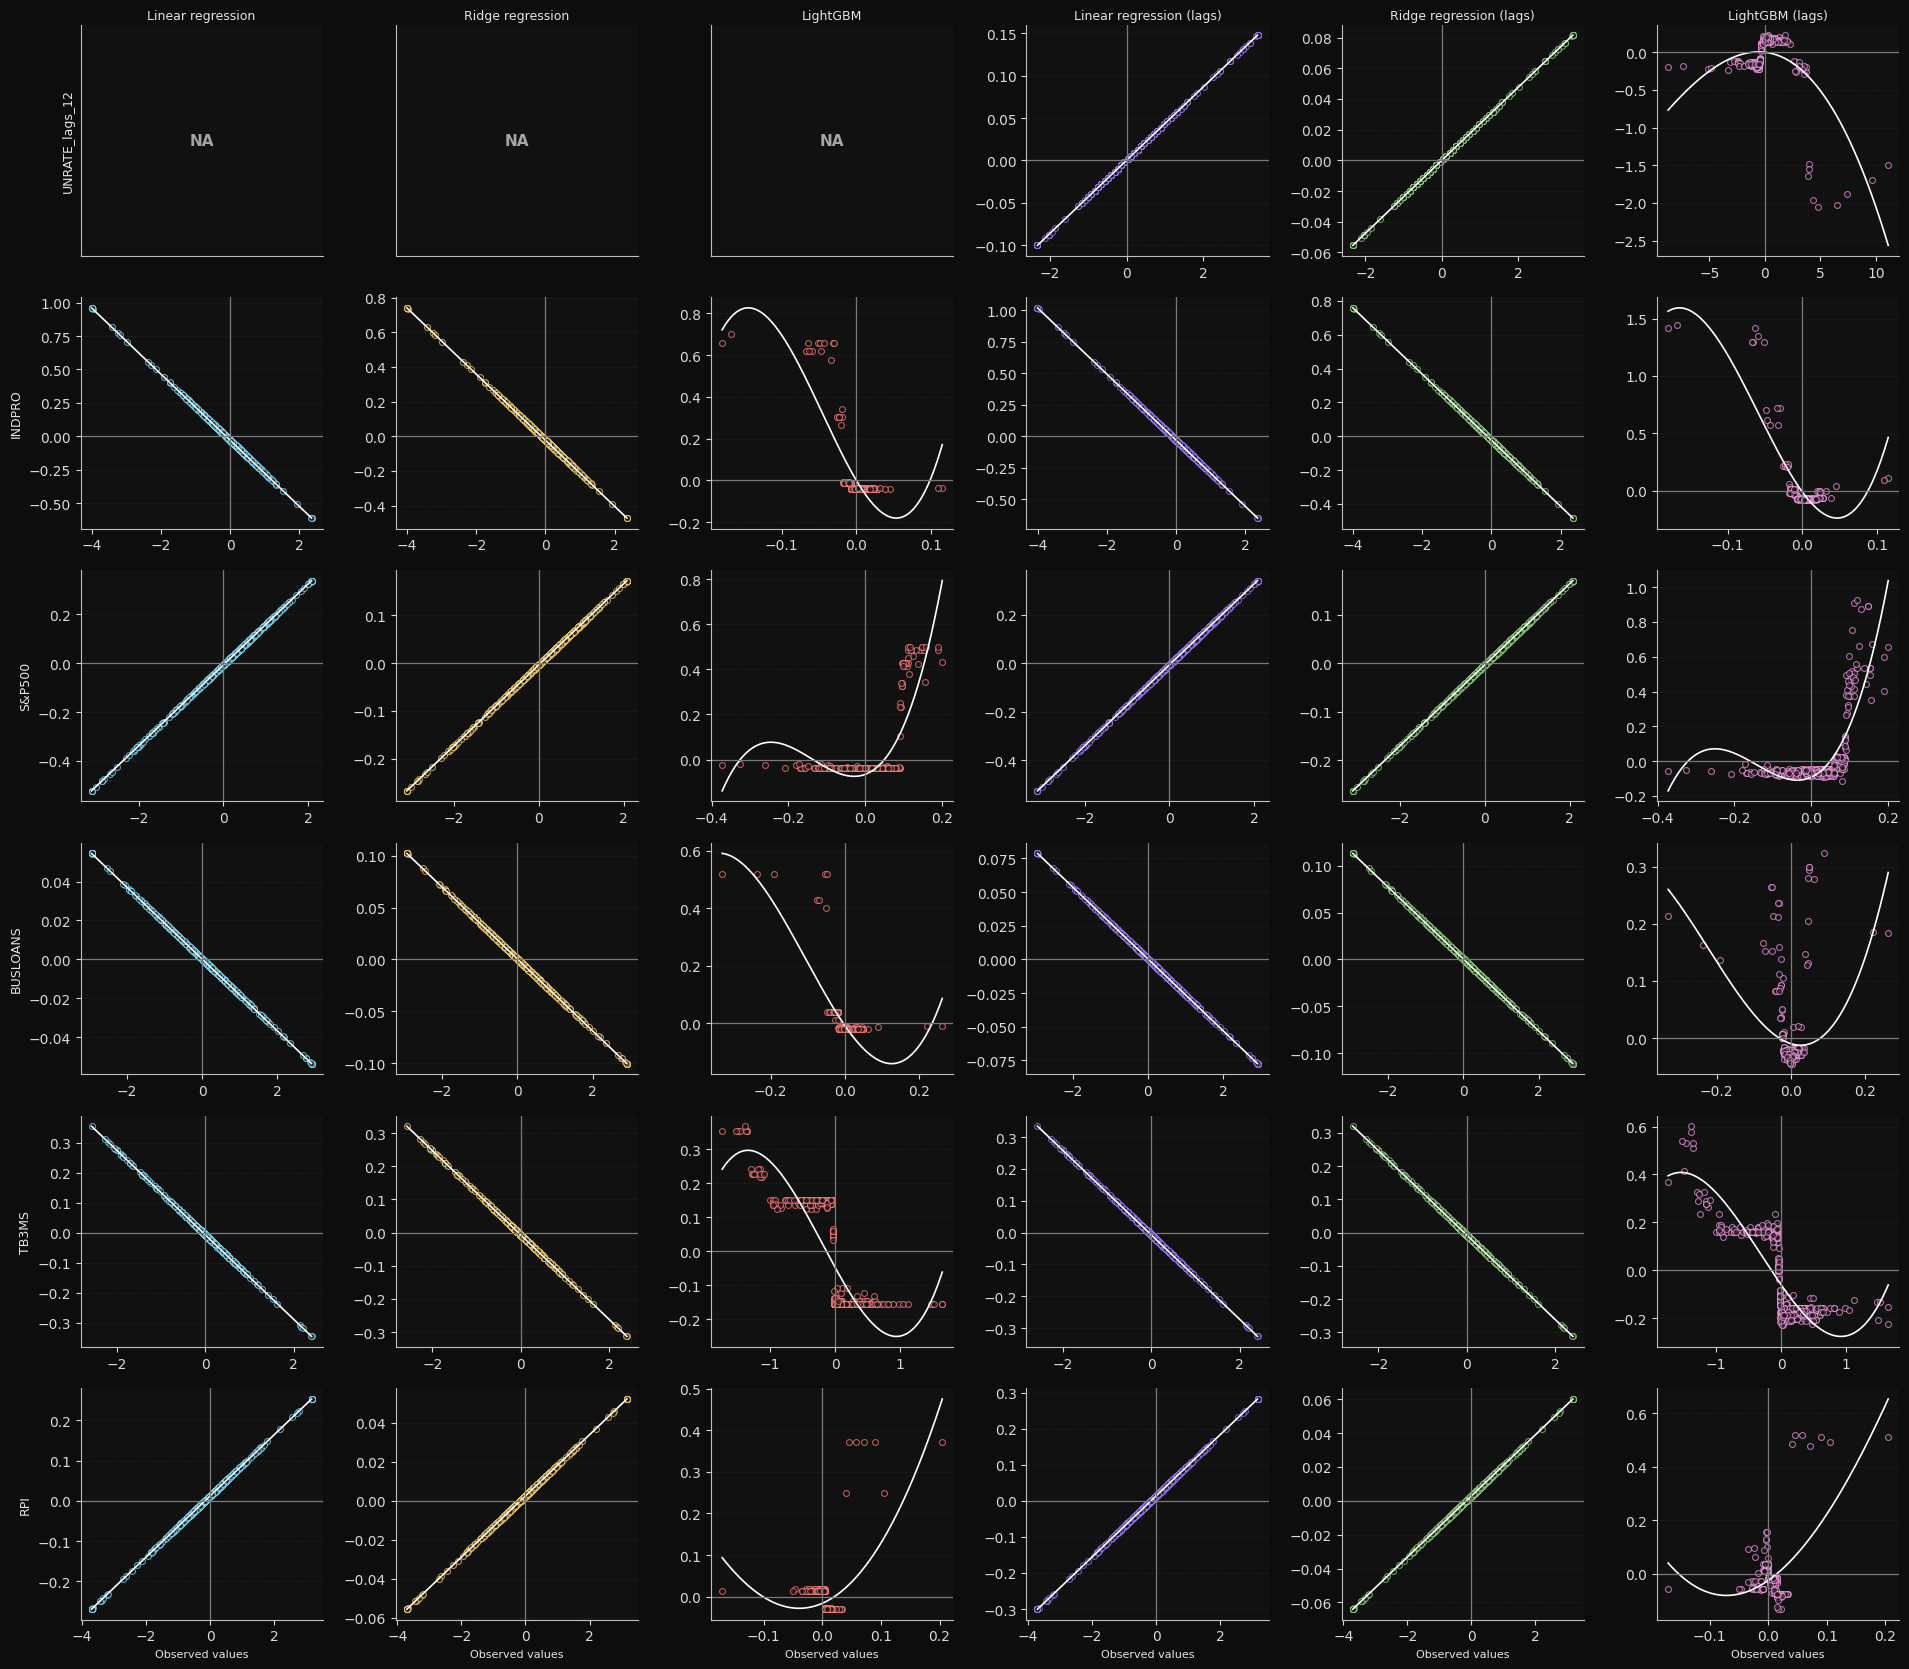

In [101]:
# ============================================================
# Functional-form plots — GRID (rows=variables, cols=models)
# Models: LinearRegression, Ridge (droites exactes), LightGBM (TreeExplainer)
# + prise en charge automatique des versions "(lags)"
# + gestion des variables manquantes par modèle (affiche "NA")
# + RÉSOLUTION D'ALIAS (ex.: "UNRATE_lags_12" → "UNRATE_lag12")
# + THEME SOMBRE (fond noir) — lisible partout
# ============================================================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ---------------------- setup DARK THEME (global)
plt.style.use("dark_background")
plt.rcParams.update({
    "figure.facecolor": "#0d0d0d",
    "axes.facecolor":   "#111111",
    "savefig.facecolor":"#0d0d0d",
    "text.color":       "#e5e5e5",
    "axes.edgecolor":   "#bfbfbf",
    "axes.labelcolor":  "#e5e5e5",
    "xtick.color":      "#d8d8d8",
    "ytick.color":      "#d8d8d8",
    "grid.color":       "#5a5a5a",
})
_DARK_LINE = "#ffffff"     # lignes de tendance
_DARK_ZERO = "#7a7a7a"     # axes 0
_DARK_NA   = "#a5a5a5"     # texte NA
_DARK_GRID = (0.25, ":")   # alpha, style

# palette contrastée pour fond noir
_DARK_COLORS = (
    "#7fdfff",  # cyan
    "#ffd166",  # jaune
    "#ff7f7f",  # rouge clair
    "#9d7aff",  # violet
    "#8bd17c",  # vert
    "#f29ae1",  # rose
)

# ---------------------- unwrap / détection modèles
def _unwrap_model(m):
    base = m
    if hasattr(base, "_base"):  # ex. _NPWrapper
        try:
            base = base._base
        except Exception:
            pass
    try:
        from sklearn.pipeline import Pipeline
        if isinstance(base, Pipeline):
            base = base.steps[-1][1]
    except Exception:
        pass
    return base

def _name_blob(model) -> str:
    cls = type(model)
    return f"{cls.__name__}|{getattr(cls, '__module__', '')}".lower()

def _is_tree_model(model) -> bool:
    blob = _name_blob(model)
    keys = ("lgbm", "lightgbm", "xgboost", "catboost", "histgradient", "randomforest", "gradientboost")
    return any(k in blob for k in keys)

# ---------------------- préproc "safe"
def _apply_prep(X: pd.DataFrame, prep):
    if prep is None:
        return X
    if hasattr(prep, "transform"):
        Xp = prep.transform(X)
        try:
            return pd.DataFrame(Xp, index=X.index, columns=X.columns)
        except Exception:
            return pd.DataFrame(Xp, index=X.index)
    Xp = X.copy()
    if isinstance(prep, dict):
        lower = prep.get("lower_wins", prep.get("lower", None))
        upper = prep.get("upper_wins", prep.get("upper", None))
        if lower is not None and upper is not None:
            lo = pd.Series(lower, index=Xp.columns) if not isinstance(lower, pd.Series) else lower.reindex(Xp.columns)
            up = pd.Series(upper, index=Xp.columns) if not isinstance(upper, pd.Series) else upper.reindex(Xp.columns)
            Xp = Xp.clip(lower=lo, upper=up, axis=1)
        if prep.get("norm", False):
            mean = prep.get("mean", None)
            std  = prep.get("std",  None)
            if mean is not None and std is not None:
                mean_s = pd.Series(mean, index=Xp.columns) if not isinstance(mean, pd.Series) else mean.reindex(Xp.columns)
                std_s  = pd.Series(std,  index=Xp.columns) if not isinstance(std,  pd.Series) else std.reindex(Xp.columns)
                Xp = (Xp - mean_s) / std_s.replace(0, 1)
    return Xp

# ---------------------- LightGBM helpers (sans import obligatoire)
def _lgbm_feature_names(model) -> list | None:
    names = getattr(model, "feature_name_", None)
    if names:
        return list(names)
    booster = getattr(model, "_Booster", None)
    if booster is not None and hasattr(booster, "feature_name"):
        try:
            return list(booster.feature_name())
        except Exception:
            pass
    return None

def _reorder_X_for_lgbm(model, X: pd.DataFrame) -> pd.DataFrame:
    names = _lgbm_feature_names(model)
    if names:
        cols = [c for c in names if c in X.columns]
        if cols:
            return X.loc[:, cols]
    return X

# ---------------------- Extraction bundle / exp_results
def _get_model_from_bundle(bundle: dict, df_all: pd.DataFrame):
    """
    Accepte un 'bundle' ou un 'exp_results'-like:
      - bundle: {models:[...], preprocs:[...], params:{features,...}, train_fit_dates:[...]}
      - exp_results: {models:[...], preprocs:[...], features:[...], train_periods:[...]}
    Retourne: model_final (déballé), prep_final, X_full (aligné & ordonné), feature_list
    """
    if bundle is None or not isinstance(bundle, dict):
        raise ValueError("Bundle/exp_results manquant ou invalide.")

    models = bundle.get("models")
    model_final = models[-1] if isinstance(models, (list, tuple)) and models else bundle.get("model") or bundle.get("final_model")
    if model_final is None:
        raise KeyError("Impossible de trouver le modèle dans le bundle/exp_results.")

    preprocs = bundle.get("preprocs", None)
    prep_final = preprocs[-1] if isinstance(preprocs, (list, tuple)) and preprocs else None

    params = bundle.get("params", {}) or {}
    features = params.get("features") or bundle.get("features")
    if not features:
        features = list(getattr(_unwrap_model(model_final), "feature_names_in_", []))
    if not features:
        raise KeyError("Features introuvables pour ce modèle.")

    if not isinstance(df_all.index, pd.DatetimeIndex):
        df_all = df_all.copy()
        df_all.index = pd.to_datetime(df_all.index)
    end_time = df_all.index.max()
    for key in ("train_fit_dates", "train_periods"):
        if key in bundle and isinstance(bundle[key], (list, tuple)) and bundle[key]:
            try:
                end_time = pd.to_datetime(bundle[key][-1])
                break
            except Exception:
                pass

    X_full = df_all.loc[:end_time, features].copy().dropna(how="any")
    base = _unwrap_model(model_final)
    if _is_tree_model(base):
        X_full = _reorder_X_for_lgbm(base, X_full)

    return base, prep_final, X_full, list(X_full.columns)

# ---------------------- SHAP / contributions
def _compute_phi(model, X: pd.DataFrame, prep=None) -> np.ndarray:
    base = _unwrap_model(model)
    # Arbres → TreeExplainer
    if _is_tree_model(base):
        Xp = _apply_prep(_reorder_X_for_lgbm(base, X), prep).astype(float)
        try:
            expl = shap.TreeExplainer(base, Xp, check_additivity=False)
            sv = expl.shap_values(Xp)
        except TypeError:
            expl = shap.TreeExplainer(base, Xp)
            sv = expl.shap_values(Xp, check_additivity=False)
        phi = sv[0] if isinstance(sv, list) else np.asarray(sv)
        if np.ndim(phi) == 3:
            phi = phi[0]
        if phi.shape[1] != Xp.shape[1]:
            raise ValueError("Dimensions SHAP incohérentes (arbres).")
        return np.asarray(phi)

    # Linéaires → contributions exactes via coef_
    coef = getattr(base, "coef_", None)
    if coef is None:
        try:
            Xp = _apply_prep(X, prep).astype(float)
            sv = shap.Explainer(base, Xp)(Xp)
            vals = getattr(sv, "values", None)
            arr = np.array(vals if vals is not None else sv)
            if arr.ndim == 3:
                arr = arr[0]
            return arr
        except Exception:
            raise RuntimeError(f"Modèle linéaire attendu (coef_ manquant) pour {type(base).__name__}.")
    Xp = _apply_prep(X, prep).astype(float)
    mu = np.nanmean(Xp, axis=0)
    Xc = Xp - mu
    phi = Xc.to_numpy() * np.asarray(coef).reshape(1, -1)
    return phi

# ---------------------- Alias & résolution de noms
_alias_map = {
    "UNRATE_lags_12": ["UNRATE_lag12", "UNRATE_lags12", "lag12_UNRATE", "UNRATE_L12", "UNRATE_LAG_12", "UNRATE_LAG12"],
    "S&P500": ["SP500", "S_P_500", "SANDP500", "SP_500", "S&P_500"],
    "OILPRICE": ["OIL_PRICE", "CRUDE_OIL", "WTI", "BRENT"],
    "BUSLOANS": ["BUS_LOANS", "BUSINESS_LOANS", "LOANS_BUSINESS"],
    "INDPRO": ["IND_PRO", "IND_PRODUCTION", "IP_INDEX"],
    "TB3MS": ["TB3M", "T3M", "TBILL3M", "TBILL_3M"],
    "RPI": ["PERSONAL_INCOME", "PI", "REAL_PI"],
}
def _resolve_feature_name(col_list, feat):
    if feat in col_list:
        return feat
    for alt in _alias_map.get(feat, []):
        if alt in col_list:
            return alt
    f = re.sub(r"[^A-Z0-9]", "", str(feat).upper())
    for col in col_list:
        c = re.sub(r"[^A-Z0-9]", "", str(col).upper())
        if c == f:
            return col
    if "UNRATE" in f and ("12" in f):
        for col in col_list:
            cu = str(col).upper()
            if "UNRATE" in cu and ("LAG12" in cu or ("LAG" in cu and "12" in cu)):
                return col
    return None

# ---------------------- Tracé en grille (fond noir)
def plot_functional_grid(models_dict, X_dict, selected_vars,
                         poly_deg_lgbm=3,
                         scatter_alpha=0.70, s=18,
                         colors=_DARK_COLORS,
                         figsize_per_cell=(3.1, 2.7),
                         sharey=False):

    model_names = list(models_dict.keys())

    # Index commun (alignement temporel)
    common_index = None
    for m in model_names:
        idx = X_dict[m].index
        common_index = idx if common_index is None else common_index.intersection(idx)

    # Taille figure
    n_rows, n_cols = len(selected_vars), len(model_names)
    fig_w = max(6.0, n_cols * figsize_per_cell[0])
    fig_h = max(6.0, n_rows * figsize_per_cell[1])
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), sharey=sharey)
    fig.patch.set_facecolor("#0d0d0d")
    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes.reshape(-1, 1)

    # Colonnes = modèles
    for c, (mname, (model, prep)) in enumerate(models_dict.items()):
        X_full_all = X_dict[mname].loc[common_index]
        base = _unwrap_model(model)
        is_linear = (hasattr(base, "coef_") and not _is_tree_model(base))

        # SHAP/contribs
        phi = np.asarray(_compute_phi(model, X_full_all, prep=prep))
        X_plot_all = _apply_prep(X_full_all, prep) if is_linear else X_full_all
        if isinstance(X_plot_all, pd.DataFrame):
            X_plot_all.columns = X_full_all.columns

        # Mapping nom→index pour ce modèle
        col_index_map = {col: j for j, col in enumerate(X_full_all.columns)}
        deg = 1 if is_linear else poly_deg_lgbm
        color_pts = colors[c % len(colors)]

        for r, feat in enumerate(selected_vars):
            ax = axes[r, c]
            ax.set_facecolor("#111111")

            # Résoudre le nom (alias éventuel)
            resolved = _resolve_feature_name(X_full_all.columns, feat)

            # Variable absente → afficher "NA"
            if resolved is None or resolved not in col_index_map:
                ax.text(0.5, 0.5, "NA", ha="center", va="center",
                        fontsize=11, fontweight="bold", color=_DARK_NA,
                        transform=ax.transAxes)
                ax.set_xticks([]); ax.set_yticks([])
                for sp in ("top", "right"):
                    ax.spines[sp].set_visible(False)
                if r == 0:
                    ax.set_title(mname, fontsize=9, pad=4, color="#e5e5e5")
                if c == 0:
                    ax.set_ylabel(feat, fontsize=9, color="#e5e5e5")
                continue

            # Sinon : tracé normal
            j = col_index_map[resolved]
            x = X_plot_all.iloc[:, j].to_numpy()
            y = phi[:, j]
            mask = ~(np.isnan(x) | np.isnan(y))
            x, y = x[mask], y[mask]

            ax.scatter(x, y, alpha=scatter_alpha, s=s,
                       facecolors="#0d0d0d", edgecolors=color_pts, linewidths=0.8)

            if len(x) > deg + 1:
                try:
                    coefs = np.polyfit(x, y, deg=deg)
                    x_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)
                    y_line = np.polyval(coefs, x_line)
                    ax.plot(x_line, y_line, color=_DARK_LINE, linewidth=1.2)
                except Exception:
                    pass

            ax.axhline(0, color=_DARK_ZERO, lw=0.9)
            ax.axvline(0, color=_DARK_ZERO, lw=0.9)
            ax.grid(axis="y", linestyle=_DARK_GRID[1], alpha=_DARK_GRID[0])

            if r == 0:
                ax.set_title(mname, fontsize=9, pad=4, color="#e5e5e5")
            if c == 0:
                ax.set_ylabel(feat, fontsize=9, color="#e5e5e5")
            if r == n_rows - 1:
                ax.set_xlabel("Observed values", fontsize=8, color="#e5e5e5")
            for spine in ("top", "right"):
                ax.spines[spine].set_visible(False)
            ax.spines["left"].set_color("#bfbfbf")
            ax.spines["bottom"].set_color("#bfbfbf")

    plt.tight_layout(h_pad=0.9, w_pad=0.9)
    return fig, axes

# ============================ USAGE (avec lags auto) ============================
# 1) Variables à tracer (alias gérés)
selected_vars = ["UNRATE_lags_12", "INDPRO", "S&P500", "BUSLOANS", "TB3MS", "RPI"]

# 2) Extraction depuis les bundles / exp_results disponibles
assert isinstance(df_stationary_test.index, pd.DatetimeIndex)
df_stationary_test = df_stationary_test.sort_index()

def _try_get(label: str, obj):
    try:
        mdl, prep, X, _ = _get_model_from_bundle(obj, df_stationary_test)
        return (label, mdl, prep, X)
    except Exception:
        return None

# --- LISTE (inclut les *lags* ; préfère bundles, puis exp_results)
candidates = [
    # Sans lags (bundles)
    ("Linear regression",        globals().get("linreg_bundle")),
    ("Ridge regression",         globals().get("ridge_bundle")),
    ("LightGBM",                 globals().get("lgbm_bundle")),
    # Avec lags (bundles)
    ("Linear regression (lags)", globals().get("linreg_lags_bundle")),
    ("Ridge regression (lags)",  globals().get("ridge_lags_bundle")),
    ("LightGBM (lags)",          globals().get("lgbm_lags_bundle")),
    # Fallbacks exp_results (si pas de bundle)
    ("Linear regression",        globals().get("exp_lin")),
    ("Ridge regression",         globals().get("exp_ridge")),
    ("LightGBM",                 globals().get("exp_lgbm")),
    ("Linear regression (lags)", globals().get("exp_lin_lags")),
    ("Ridge regression (lags)",  globals().get("exp_ridge_lags")),
    ("LightGBM (lags)",          globals().get("exp_lgbm_lags")),
]

models_dict, X_dict, seen_labels = {}, {}, set()
for label, obj in [(lbl, obj) for (lbl, obj) in candidates if obj is not None]:
    tup = _try_get(label, obj)
    if tup is not None and label not in seen_labels:
        lbl, mdl, prep, X = tup
        models_dict[lbl] = (mdl, prep)
        X_dict[lbl] = X
        seen_labels.add(lbl)

if not models_dict:
    raise RuntimeError("Aucun modèle trouvé. Fournis au moins les bundles/exp_results de base, y compris *_lags_*.")

# 3) Rapport des features manquantes par modèle (affichées en NA)
missing_report = {}
for m, X in X_dict.items():
    miss = []
    for v in selected_vars:
        if _resolve_feature_name(X.columns, v) is None:
            miss.append(v)
    if miss:
        missing_report[m] = miss

if missing_report:
    print("ℹ️ Variables absentes dans certains modèles (affichées en NA) :")
    for m, vs in missing_report.items():
        print(f" - {m}: {vs}")

# 4) Tracé (fond noir activé par défaut)
fig, axes = plot_functional_grid(
    models_dict=models_dict,
    X_dict=X_dict,
    selected_vars=selected_vars,
    poly_deg_lgbm=3,
    figsize_per_cell=(3.2, 2.8),
    sharey=False
)
plt.show()

La Figure montre comment chaque modèle relie les variables importantes au chômage.
On regarde, pour chaque variable, comment son niveau observé influence la contribution SHAP dans le modèle.
Chaque ligne correspond à une variable. Chaque colonne correspond à un modèle.
La courbe tracée résume la forme de la relation apprise.

Les modèles linéaires indiquent pratiquement les mêmes informations. Même si les modèles n’ont pas exactement les mêmes importances globales, ils apprennent presque les mêmes formes. Valable pour les deux modèles LightGBM.
Cela montre que les relations repérées ne sont pas des artefacts : elles sont stables et solides.

Pour l'exemple du passé du chômage. Tous les modèles de machine learning apprennent une forme en U inversé. Une hausse modérée du chômage peut entraîner une nouvelle hausse. Mais une très forte hausse réduit la probabilité que le chômage continue d’augmenter. Cela traduit une inertie du marché du travail.
Les modèles linéaires sont incapables d'identifier ces effets. Voilà pourquoi ils attribuent moins d'importance à la variable. 

Pour le taux d’intérêt à 3 mois (TB3MS), on retrouve la même logique.
Les modèles linéaires montrent une relation strictement décroissante : une hausse du taux entraîne systématiquement une hausse future du chômage. Ils supposent que l’effet est continu et constant.

Mais les modèles non linéaires (LightGBM, etc.) apprennent une forme plus nuancée.
L’effet du taux sur le chômage est fort dans une zone intermédiaire, puis se stabilise lorsque le taux devient très bas ou très élevé. Cela traduit un effet de seuil : la politique monétaire n’a pas la même force dans tous les régimes économiques.

Ce sont les apports réels du Machine Learning.

# Analyse

Sans inclure explicitement la récession, le modèle de gradient boosting apprend déjà une fonction non monotone du chômage retardé. La partie descendante de la courbe est principalement portée par les observations en récession, ce qui montre que le modèle internalise de fait deux régimes macroéconomiques (normal vs récession).

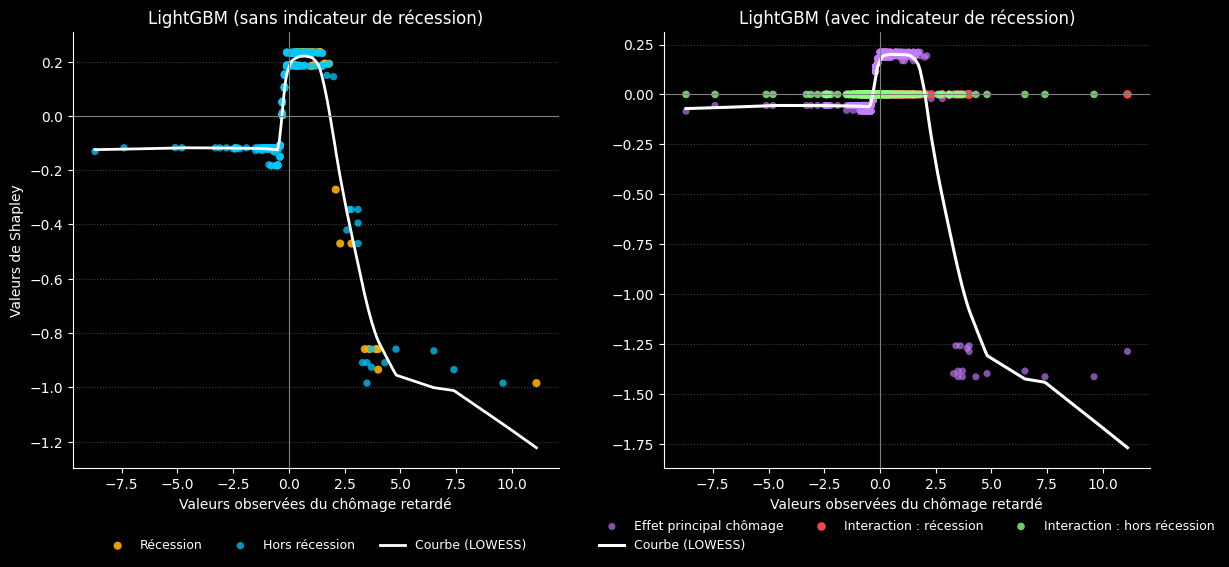

In [121]:
# ============================ Figure V (LightGBM) ============================
# Gauche : modèle SANS USREC → forme fonctionnelle de UNRATE_lag12 (LOWESS)
# Droite : modèle AVEC  USREC → points effet principal + interaction,
#          + LOWESS pour l'effet principal (pas une droite).
# Couleurs & légendes = celles utilisées précédemment.
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from statsmodels.nonparametric.smoothers_lowess import lowess

# ------------------------- utilitaires généraux -------------------------
def _unwrap_model(m):
    base = m
    if hasattr(base, "_base"):
        try: base = base._base
        except Exception: pass
    try:
        from sklearn.pipeline import Pipeline
        if isinstance(base, Pipeline):
            base = base.steps[-1][1]
    except Exception:
        pass
    return base

def _lgbm_feature_names(model):
    n = getattr(model, "feature_name_", None)
    if n: return list(n)
    b = getattr(model, "_Booster", None)
    if b is not None and hasattr(b, "feature_name"):
        try: return list(b.feature_name())
        except Exception: pass
    return None

def _reorder_X_for_lgbm(model, X: pd.DataFrame) -> pd.DataFrame:
    names = _lgbm_feature_names(model)
    if not names: return X
    cols = [c for c in names if c in X.columns]
    return X.loc[:, cols] if cols else X

def _resolve_unrate(cols):
    aliases = ["UNRATE_lag12","UNRATE_lags_12","UNRATE_lags12","lag12_UNRATE","UNRATE_L12"]
    for a in aliases:
        if a in cols: return a
    # heuristique
    for c in cols:
        u = c.upper()
        if "UNRATE" in u and ("LAG12" in u or ("LAG" in u and "12" in u)):
            return c
    return None

def _safe_end_time(bundle, fallback_ts):
    # évite l’erreur "truth value of DatetimeIndex is ambiguous"
    for k in ("train_fit_dates","train_periods"):
        seq = bundle.get(k, None)
        if isinstance(seq, (list, tuple)) and len(seq) > 0:
            try:
                return pd.to_datetime(seq[-1])
            except Exception:
                pass
    return fallback_ts

def _get_model_from_bundle(bundle: dict, df_all: pd.DataFrame):
    if bundle is None or not isinstance(bundle, dict):
        raise ValueError("Bundle manquant/invalide.")
    model_final = (bundle.get("models") or [])[-1] if bundle.get("models") else (bundle.get("model") or bundle.get("final_model"))
    if model_final is None:
        raise ValueError("Modèle introuvable dans le bundle.")
    model_final = _unwrap_model(model_final)

    preprocs = bundle.get("preprocs", None)
    prep_final = preprocs[-1] if isinstance(preprocs, (list,tuple)) and preprocs else None

    params = bundle.get("params", {}) or {}
    features = params.get("features") or bundle.get("features") \
               or list(getattr(model_final, "feature_names_in_", []))
    if not features:
        raise ValueError("Features introuvables dans le bundle.")

    end_time = _safe_end_time(bundle, df_all.index.max())
    X = df_all.loc[:end_time, features].copy().dropna(how="any")
    X = _reorder_X_for_lgbm(model_final, X)
    return model_final, prep_final, X, list(X.columns)

def _shap_values_tree(model, X: pd.DataFrame):
    Xp = _reorder_X_for_lgbm(model, X).astype(float)
    expl = shap.TreeExplainer(model, Xp)
    try:
        sv = expl.shap_values(Xp, check_additivity=False)
    except TypeError:
        sv = expl.shap_values(Xp)
    sv = sv[0] if isinstance(sv, list) else np.asarray(sv)
    if sv.ndim == 3: sv = sv[0]
    return sv

def _shap_interactions_tree(model, X: pd.DataFrame):
    Xp = _reorder_X_for_lgbm(model, X).astype(float)
    expl = shap.TreeExplainer(model, Xp)
    SI = expl.shap_interaction_values(Xp)
    SI = SI[0] if isinstance(SI, list) else np.asarray(SI)
    return SI

def _lowess_line(x, y, frac=0.35, it=0, n=250):
    x = np.asarray(x).ravel(); y = np.asarray(y).ravel()
    m = ~(np.isnan(x) | np.isnan(y))
    if m.sum() < 5: return None, None
    lo = lowess(y[m], x[m], frac=frac, it=it, return_sorted=True)
    xs = np.linspace(lo[:,0].min(), lo[:,0].max(), n)
    ys = np.interp(xs, lo[:,0], lo[:,1])
    return xs, ys

def _align_xy(a, b):
    a = np.asarray(a).ravel(); b = np.asarray(b).ravel()
    n = min(len(a), len(b))
    a, b = a[:n], b[:n]
    m = ~(np.isnan(a) | np.isnan(b))
    return a[m], b[m]

def _align_xyz(a, b, c, cast_c=None):
    a = np.asarray(a).ravel(); b = np.asarray(b).ravel(); c = np.asarray(c).ravel()
    n = min(len(a), len(b), len(c))
    a, b, c = a[:n], b[:n], c[:n]
    m = ~(np.isnan(a) | np.isnan(b) | np.isnan(c))
    a, b, c = a[m], b[m], c[m]
    if cast_c is not None: c = cast_c(c)
    return a, b, c

# ------------------------- styles (fond noir) -------------------------
plt.style.use("default")
plt.rcParams.update({
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
})

# ------------------------- fonction principale -------------------------
def plot_two_panel_lightgbm(
    *, df_all: pd.DataFrame,
    lgbm_no_rec_bundle, lgbm_with_rec_bundle,
    feature_name: str | None = None,
    recession_col: str = "USREC",
    figsize=(12.2, 6.2),
    lowess_frac_left=0.35, lowess_frac_right=0.35
):
    assert isinstance(df_all.index, pd.DatetimeIndex), "df_all doit être indexé par dates."
    df_all = df_all.sort_index()

    # couleurs (identiques à vos précédentes figures)
    col_rec_L  = "#ffb000"  # gauche: récession
    col_nrec_L = "#00c8ff"  # gauche: hors récession
    col_main_R_pts = "#c77dff"  # droite: points effet principal
    col_rec_R  = "#ff4d4d"  # droite: interaction en récession
    col_nrec_R = "#8aff80"  # droite: interaction hors récession
    curve_col  = "#ffffff"  # courbes LOWESS

    # ---------- Gauche : modèle SANS USREC ----------
    mdl0, prep0, X0, cols0 = _get_model_from_bundle(lgbm_no_rec_bundle, df_all)
    featL = feature_name or _resolve_unrate(cols0)
    if featL is None:
        raise KeyError("Feature UNRATE_lag12 (ou alias) introuvable (panneau gauche).")

    sv0 = _shap_values_tree(mdl0, X0)
    j0  = cols0.index(featL)
    xL, yL = X0[featL].to_numpy(), sv0[:, j0]
    recL = df_all.loc[X0.index, recession_col].to_numpy() if recession_col in df_all.columns else np.zeros(len(X0), int)

    # alignement & LOWESS
    xL, yL, recL = _align_xyz(xL, yL, recL, cast_c=lambda v: v.astype(int))
    xs_L, ys_L = _lowess_line(xL, yL, frac=lowess_frac_left)

    # ---------- Droite : modèle AVEC USREC ----------
    mdl1, prep1, X1, cols1 = _get_model_from_bundle(lgbm_with_rec_bundle, df_all)
    featR = feature_name or _resolve_unrate(cols1)
    if featR is None:
        raise KeyError("Feature UNRATE_lag12 (ou alias) introuvable (panneau droit).")
    if recession_col not in df_all.columns or recession_col not in cols1:
        raise KeyError(f"'{recession_col}' doit exister dans df_all et dans le modèle AVEC USREC.")

    sv1 = _shap_values_tree(mdl1, X1)
    SI1 = _shap_interactions_tree(mdl1, X1)
    jf, jr = cols1.index(featR), cols1.index(recession_col)

    xR = X1[featR].to_numpy()
    main_u = sv1[:, jf]
    inter_u_r = SI1[:, jf, jr]
    recess_flag = df_all.loc[X1.index, recession_col].to_numpy().astype(bool)

    # alignements et LOWESS (effet principal seulement, comme demandé)
    x_main, main_al = _align_xy(xR, main_u)
    xs_R, ys_R = _lowess_line(x_main, main_al, frac=lowess_frac_right)
    xI, inter_al, rflag = _align_xyz(xR, inter_u_r, recess_flag, cast_c=lambda v: v.astype(bool))

    # ------------------------- Tracé -------------------------
    fig, (axL, axR) = plt.subplots(1, 2, figsize=figsize, sharey=False)

    # GAUCHE
    axL.scatter(xL[recL==1], yL[recL==1], s=34, alpha=0.9,  color=col_rec_L,  edgecolors="none", label="Récession")
    axL.scatter(xL[recL==0], yL[recL==0], s=28, alpha=0.75, color=col_nrec_L, edgecolors="none", label="Hors récession")
    if xs_L is not None:
        axL.plot(xs_L, ys_L, color=curve_col, linewidth=2.0, label="Courbe (LOWESS)")
    axL.axhline(0, color="gray", lw=0.8); axL.axvline(0, color="gray", lw=0.8)
    axL.grid(axis="y", linestyle=":", alpha=0.25, color="white")
    axL.set_title("LightGBM (sans indicateur de récession)")
    axL.set_xlabel("Valeurs observées du chômage retardé")
    axL.set_ylabel("Valeurs de Shapley")
    axL.legend(frameon=False, fontsize=9, loc="lower center", bbox_to_anchor=(0.5, -0.22), ncol=3)

    # DROITE (effet principal + interaction, **LOWESS pour l'effet principal**)
    axR.scatter(x_main, main_al, s=26, alpha=0.65, color=col_main_R_pts, edgecolors="none", label="Effet principal chômage")
    if xs_R is not None:
        axR.plot(xs_R, ys_R, color=curve_col, linewidth=2.2, label="Courbe (LOWESS)")

    axR.scatter(xI[ rflag], inter_al[ rflag], s=38, alpha=0.95, color=col_rec_R,  edgecolors="none", label="Interaction : récession")
    axR.scatter(xI[~rflag], inter_al[~rflag], s=30, alpha=0.80, color=col_nrec_R, edgecolors="none", label="Interaction : hors récession")

    axR.axhline(0, color="gray", lw=0.8); axR.axvline(0, color="gray", lw=0.8)
    axR.grid(axis="y", linestyle=":", alpha=0.25, color="white")
    axR.set_title("LightGBM (avec indicateur de récession)")
    axR.set_xlabel("Valeurs observées du chômage retardé")
    axR.legend(frameon=False, fontsize=9, loc="lower center", bbox_to_anchor=(0.5, -0.22), ncol=3)

    for ax in (axL, axR):
        for s in ("top", "right"):
            ax.spines[s].set_visible(False)

    plt.tight_layout()
    return fig, (axL, axR)

# ============================ APPEL EXEMPLE ============================
# Récupération des bundles depuis l'espace global.
no_rec_bundle  = globals().get("lgbm_nousrec_lags_bundle")
with_rec_bundle = globals().get("lgbm_lags_bundle") or globals().get("lgbm_bundle")

if no_rec_bundle is None or with_rec_bundle is None:
    raise RuntimeError("⚠️ Fournissez: lgbm_nousrec_lags_bundle ET (lgbm_lags_bundle ou lgbm_bundle).")

# Détection de la colonne UNRATE_lag12 (alias acceptés) et de USREC
_all_cols = list(df_stationary_test.columns)
feat_guess = None
for c in _all_cols:
    u = c.upper()
    if "UNRATE" in u and ("LAG12" in u or ("LAG" in u and "12" in u)):
        feat_guess = c; break
if feat_guess is None:
    feat_guess = "UNRATE_lag12"  # alias par défaut si présent dans les bundles

USREC_COL = "USREC" if "USREC" in _all_cols else ("USREC_lag12" if "USREC_lag12" in _all_cols else "USREC")

# Tracé final
fig, axes = plot_two_panel_lightgbm(
    df_all=df_stationary_test,
    lgbm_no_rec_bundle=no_rec_bundle,
    lgbm_with_rec_bundle=with_rec_bundle,
    feature_name=feat_guess,
    recession_col=USREC_COL,
    figsize=(12.6, 5.8),
    lowess_frac_left=0.35,
    lowess_frac_right=0.35
)
plt.show()

Le graphique représente la relation entre le chômage retardé et sa contribution à la prédiction du modèle (valeurs de Shapley). On observe une forme en U inversé :
- une hausse modérée du chômage passé tend à entraîner une hausse future,
- tandis que des niveaux déjà très élevés de chômage sont associés à un effet marginal décroissant.

Cette forme traduit une inertie du marché du travail : lorsque le chômage dépasse un certain seuil, il devient plus difficile de revenir rapidement à la normale. C’est l’idée d’hystérèse.

Lorsque l’on met en évidence les périodes de récession, on voit qu’elles se concentrent précisément dans la partie décroissante de la courbe. Pourtant, le modèle n’avait pas reçu l’indicateur de récession comme variable d’entrée.

Cela signifie que LightGBM a appris implicitement l’effet des récessions à partir des seules évolutions du chômage. Autrement dit, il a identifié deux régimes économiques :
- un régime normal, où les variations sont modérées,
- un régime de récession, où une hausse du chômage a un effet plus marqué.

Pour confirmer cela, on ajoute un indicateur de récession et on décompose la prédiction en :
- effet principal du chômage retardé,
- interaction entre chômage retardé et récession.

Deux résultats ressortent :
- L’effet principal conserve la forme en U inversé. La non-linéarité est donc structurelle.
- L’interaction montre que pendant les récessions, l’effet du chômage passé est nettement plus négatif, alors qu’hors récession, cette interaction est quasi nulle.

Enfin, l’ajout explicite de l’indicateur de récession n’améliore presque pas la précision du modèle sur la question de récession. 
→ Le modèle avait déjà intégré le rôle des récessions dans sa structure interne.
→ Telle est la puissance du Machine Learning. 